In [312]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from scipy.linalg import inv
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ============================================================================
# HELPER FUNCTION TO SAVE PLOTS
# ============================================================================
# Create images directory if it doesn't exist
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)

# Counter for automatic naming if filename not provided
_plot_counter = 0

def save_figure(fig, filename=None, dpi=150, bbox_inches='tight'):
    """
    Save a matplotlib figure to the images directory.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    filename : str, optional
        Filename (without extension). If None, uses auto-generated name.
    dpi : int, default=150
        Resolution for saved image
    bbox_inches : str, default='tight'
        Bounding box setting for saved image
    """
    global _plot_counter
    if filename is None:
        filename = f'plot_{_plot_counter:03d}'
        _plot_counter += 1
    
    # Ensure filename doesn't have extension
    filename = filename.replace('.png', '').replace('.jpg', '').replace('.pdf', '')
    
    filepath = images_dir / f'{filename}.png'
    fig.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, facecolor='white')
    print(f"  💾 Saved: {filepath}")

print("="*80)
print("SIMPLE ML MODEL FOR GEOPOLITICAL PERIOD CLASSIFICATION")
print("="*80)

SIMPLE ML MODEL FOR GEOPOLITICAL PERIOD CLASSIFICATION


In [313]:
# ============================================================================
# DATA LOADING
# ============================================================================

# Load processed features with labels
data_path = Path('data/processed_features_with_labels.csv')
df = pd.read_csv(data_path, parse_dates=['date'])

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

# Display first few rows
print(f"\n{'='*80}")
print("First 5 rows:")
print(f"{'='*80}")
print(df.head())

Loaded data shape: (1990, 40)
Date range: 2019-02-13 01:00:00+00:00 to 2026-02-06 01:00:00+00:00

Label distribution:
label
2019-Tension              152
Israel-Hamas-Pre-War       84
Israel-Hamas-War           70
Normal                    252
Normal-COVID              430
Normal-Tense              406
Post-War Close             51
Post-War Late              52
Pre-War Close              51
Pre-War Early              51
Russia-Ukraine-Pre-War    103
Russia-Ukraine-War        247
Unlabeled                  31
War                        10
Name: count, dtype: int64

First 5 rows:
                       date  WTI_price  BRENT_price   label     spread  \
0 2019-02-13 01:00:00+00:00  53.733952    63.341571  Normal   9.607619   
1 2019-02-14 01:00:00+00:00  54.226238    64.314619  Normal  10.088381   
2 2019-02-15 01:00:00+00:00  54.945714    65.352000  Normal  10.406286   
3 2019-02-18 01:00:00+00:00  55.941000    66.381000  Normal  10.440000   
4 2019-02-19 01:00:00+00:00  55.909905    66.

In [314]:
# ============================================================================
# DATA PREPARATION: TRAIN/TEST SPLIT
# ============================================================================

# ============================================================================
# TRAINING DATA (2024-2025 ONLY)
# ============================================================================
# Training period: Only 2024-2025 (Iran-related war periods)
# This includes: Normal-Tense, Pre-War Early/Close, War, Post-War Close/Late

train_mask = (
    (df['date'] >= pd.Timestamp('2024-01-01', tz='UTC')) & 
    (df['date'] < pd.Timestamp('2026-01-01', tz='UTC')) & 
    (df['label'].isin(['Normal-Tense', 'Pre-War Early', 'Pre-War Close', 
                       'War', 'Post-War Close', 'Post-War Late']))
)

df_train = df[train_mask].copy()

# ============================================================================
# TEST DATA - ALL OTHER PERIODS (DISJOINT)
# ============================================================================
# Each test set is a separate, disjoint period that should be plotted separately

# Test 1: Normal (2019-01 to 2019-06) - Pre-tension baseline test
df_test_normal_2019 = df[(df['date'] >= pd.Timestamp('2019-01-01', tz='UTC')) & 
                         (df['date'] <= pd.Timestamp('2019-06-30', tz='UTC')) & 
                         (df['label'] == 'Normal')].copy()

# Test 2: 2019-Tension (2019-07 to 2020-01) - Iran-Saudi tension escalation
df_test_2019_tension = df[(df['date'] >= pd.Timestamp('2019-07-01', tz='UTC')) & 
                          (df['date'] <= pd.Timestamp('2020-01-31', tz='UTC')) & 
                          (df['label'] == '2019-Tension')].copy()

# Test 3: Normal-COVID (2020-02 to 2021-09) - COVID impact test
df_test_covid = df[(df['date'] >= pd.Timestamp('2020-02-01', tz='UTC')) & 
                   (df['date'] < pd.Timestamp('2021-10-01', tz='UTC')) & 
                   (df['label'] == 'Normal-COVID')].copy()

# Test 4: Russia-Ukraine Pre-War (2021-10-01 to 2022-02-23)
df_test_ru_prewar = df[(df['date'] >= pd.Timestamp('2021-10-01', tz='UTC')) & 
                       (df['date'] < pd.Timestamp('2022-02-24', tz='UTC')) & 
                       (df['label'] == 'Russia-Ukraine-Pre-War')].copy()

# Test 5: Russia-Ukraine War (2022-02-24 to 2022-12-31)
df_test_ru_war = df[(df['date'] >= pd.Timestamp('2022-02-24', tz='UTC')) & 
                    (df['date'] <= pd.Timestamp('2022-12-31', tz='UTC')) & 
                    (df['label'] == 'Russia-Ukraine-War')].copy()

# Test 6: Normal (2023-01 to 2023-06) - Post-Russia-Ukraine baseline test
df_test_normal_2023 = df[(df['date'] >= pd.Timestamp('2023-01-01', tz='UTC')) & 
                         (df['date'] <= pd.Timestamp('2023-06-30', tz='UTC')) & 
                         (df['label'] == 'Normal')].copy()

# Test 7: Israel-Hamas Pre-War (2023-07-01 to 2023-10-06)
df_test_im_prewar = df[(df['date'] >= pd.Timestamp('2023-07-01', tz='UTC')) & 
                       (df['date'] < pd.Timestamp('2023-10-07', tz='UTC')) & 
                       (df['label'] == 'Israel-Hamas-Pre-War')].copy()

# Test 8: Israel-Hamas War (2023-10-07 to 2023-12-31)
df_test_im_war = df[(df['date'] >= pd.Timestamp('2023-10-07', tz='UTC')) & 
                    (df['date'] <= pd.Timestamp('2023-12-31', tz='UTC')) & 
                    (df['label'] == 'Israel-Hamas-War')].copy()

# Test 9: 2026+ (Unlabeled) - Future test data
df_test_2026 = df[df['date'] >= pd.Timestamp('2026-01-01', tz='UTC')].copy()

print(f"{'='*80}")
print("TRAIN/TEST SPLIT")
print(f"{'='*80}")
print(f"\nTraining data (2024-2025 only - Iran-related war periods):")
print(f"  Shape: {df_train.shape}")
print(f"  Date range: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"  Label distribution:")
print(df_train['label'].value_counts().sort_index())

print(f"\n{'='*80}")
print("TEST DATA (All other periods - disjoint sets)")
print(f"{'='*80}")
test_sets = {
    'Normal (2019 H1)': df_test_normal_2019,
    '2019-Tension': df_test_2019_tension,
    'Normal-COVID': df_test_covid,
    'Russia-Ukraine-Pre-War': df_test_ru_prewar,
    'Russia-Ukraine-War': df_test_ru_war,
    'Normal (2023 H1)': df_test_normal_2023,
    'Israel-Hamas-Pre-War': df_test_im_prewar,
    'Israel-Hamas-War': df_test_im_war,
    '2026+ (Unlabeled)': df_test_2026
}

for test_name, test_df in test_sets.items():
    if len(test_df) > 0:
        print(f"\n{test_name}:")
        print(f"  Shape: {test_df.shape}")
        print(f"  Date range: {test_df['date'].min()} to {test_df['date'].max()}")
        print(f"  Labels: {test_df['label'].unique()}")

# Get rolling z-score features - these adapt to current regime
# Includes: spread, spread_vol (24h/5d/30d), WTI_return (1d/5d/30d), WTI_price_vol (24h/5d/30d), WTI_abs_change, BRENT_abs_change
zscore_rolling_features = [col for col in df.columns if col.endswith('_zscore_rolling')]
print(f"\n{'='*80}")
print(f"FEATURES FOR MODELING ({len(zscore_rolling_features)} rolling z-scores)")
print(f"{'='*80}")
print("Using rolling z-scores (30-day window) - adapts to current regime")
print("Better for detecting relative changes compared to global z-scores")
for feat in sorted(zscore_rolling_features):
    print(f"  - {feat}")

# Prepare features and labels for training
X_train = df_train[zscore_rolling_features].values
y_train = df_train['label'].values

# Prepare features and labels for all test sets
test_data = {
    'test_normal_2019': (df_test_normal_2019, 'Normal'),
    'test_2019_tension': (df_test_2019_tension, '2019-Tension'),
    'test_covid': (df_test_covid, 'Normal-COVID'),
    'test_ru_prewar': (df_test_ru_prewar, 'Russia-Ukraine-Pre-War'),
    'test_ru_war': (df_test_ru_war, 'Russia-Ukraine-War'),
    'test_normal_2023': (df_test_normal_2023, 'Normal'),
    'test_im_prewar': (df_test_im_prewar, 'Israel-Hamas-Pre-War'),
    'test_im_war': (df_test_im_war, 'Israel-Hamas-War'),
    'test_2026': (df_test_2026, 'Unlabeled')
}

# Extract features and labels for each test set
X_test_dict = {}
y_test_dict = {}
for test_name, (test_df, expected_label) in test_data.items():
    if len(test_df) > 0:
        X_test_dict[test_name] = test_df[zscore_rolling_features].values
        y_test_dict[test_name] = test_df['label'].values
    else:
        X_test_dict[test_name] = np.array([]).reshape(0, len(zscore_rolling_features))
        y_test_dict[test_name] = np.array([])

# Check for NaN values
print(f"\n{'='*80}")
print("DATA QUALITY CHECK")
print(f"{'='*80}")
print(f"Training data - NaN count: {np.isnan(X_train).sum()}")

for test_name in test_data.keys():
    if len(X_test_dict[test_name]) > 0:
        nan_count = np.isnan(X_test_dict[test_name]).sum()
        print(f"Test {test_name} - NaN count: {nan_count}")

# Remove rows with NaN if any
train_valid_mask = ~np.isnan(X_train).any(axis=1)
X_train = X_train[train_valid_mask]
y_train = y_train[train_valid_mask]

# Remove NaN from all test sets
for test_name in X_test_dict.keys():
    if len(X_test_dict[test_name]) > 0:
        test_valid_mask = ~np.isnan(X_test_dict[test_name]).any(axis=1)
        X_test_dict[test_name] = X_test_dict[test_name][test_valid_mask]
        y_test_dict[test_name] = y_test_dict[test_name][test_valid_mask]

print(f"\nAfter removing NaN:")
print(f"  Training samples: {len(X_train)}")
for test_name, (_, expected_label) in test_data.items():
    if len(X_test_dict[test_name]) > 0:
        print(f"  Test {test_name} samples: {len(X_test_dict[test_name])} (expected: {expected_label})")

# Encode labels to numeric (only for training)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

print(f"\nLabel encoding (training classes):")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

print(f"\n⚠️  Note:")
print(f"  - Test sets 2018, COVID, Russia-Ukraine, and Israel-Hamas: Labeled - can evaluate accuracy")
print(f"  - Test 2026: Unlabeled - can only make predictions, not evaluate accuracy")

TRAIN/TEST SPLIT

Training data (2024-2025 only - Iran-related war periods):
  Shape: (621, 40)
  Date range: 2024-01-02 01:00:00+00:00 to 2025-12-31 01:00:00+00:00
  Label distribution:
label
Normal-Tense      406
Post-War Close     51
Post-War Late      52
Pre-War Close      51
Pre-War Early      51
War                10
Name: count, dtype: int64

TEST DATA (All other periods - disjoint sets)

Normal (2019 H1):
  Shape: (98, 40)
  Date range: 2019-02-13 01:00:00+00:00 to 2019-06-28 00:00:00+00:00
  Labels: ['Normal']

2019-Tension:
  Shape: (152, 40)
  Date range: 2019-07-01 00:00:00+00:00 to 2020-01-30 01:00:00+00:00
  Labels: ['2019-Tension']

Normal-COVID:
  Shape: (430, 40)
  Date range: 2020-02-03 01:00:00+00:00 to 2021-09-30 00:00:00+00:00
  Labels: ['Normal-COVID']

Russia-Ukraine-Pre-War:
  Shape: (103, 40)
  Date range: 2021-10-01 00:00:00+00:00 to 2022-02-23 01:00:00+00:00
  Labels: ['Russia-Ukraine-Pre-War']

Russia-Ukraine-War:
  Shape: (247, 40)
  Date range: 2022-02-24 

In [315]:
# ============================================================================
# MODEL TRAINING: MULTIPLE SIMPLE MODELS
# ============================================================================

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True)
}

trained_models = {}
train_scores = {}
test_scores = {}
all_test_predictions = {}  # Store predictions for all models and test sets
all_test_probabilities = {}  # Store probabilities for all models and test sets

print(f"{'='*80}")
print("TRAINING MODELS")
print(f"{'='*80}")

for name, model in models.items():
    print(f"\n{'─'*80}")
    print(f"Training {name}...")
    print(f"{'─'*80}")
    
    # Train model
    model.fit(X_train, y_train_encoded)
    trained_models[name] = model
    
    # Predictions for training
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    train_scores[name] = train_acc
    
    # Label mapping: Map test set labels to closest training labels
    # This allows us to compute accuracy and confusion matrices for test sets
    label_mapping = {
        'Normal': 'Normal-Tense',  # Normal periods map to Normal-Tense (closest match)
        '2019-Tension': 'Pre-War Early',  # Tension period maps to Pre-War Early
        'Normal-COVID': 'Normal-Tense',  # COVID normal maps to Normal-Tense
        'Russia-Ukraine-Pre-War': 'Pre-War Early',  # Pre-war maps to Pre-War Early
        'Russia-Ukraine-War': 'War',  # War maps to War
        'Israel-Hamas-Pre-War': 'Pre-War Early',  # Pre-war maps to Pre-War Early
        'Israel-Hamas-War': 'War',  # War maps to War
        'Unlabeled': None  # Cannot map unlabeled data
    }
    
    # Predictions for all test sets
    test_predictions = {}
    test_probabilities = {}
    test_accuracies = {}
    
    for test_name, (_, expected_label) in test_data.items():
        if len(X_test_dict[test_name]) > 0:
            # Make predictions and probabilities
            y_test_pred = model.predict(X_test_dict[test_name])
            y_test_proba = model.predict_proba(X_test_dict[test_name])
            test_predictions[test_name] = y_test_pred
            test_probabilities[test_name] = y_test_proba
            
            # Calculate accuracy using label mapping
            mapped_label = label_mapping.get(expected_label)
            if mapped_label is not None and mapped_label in label_encoder.classes_:
                # Map test labels to training labels
                y_test_labels = y_test_dict[test_name]
                y_test_mapped = np.array([label_mapping.get(label, mapped_label) for label in y_test_labels])
                y_test_encoded = label_encoder.transform(y_test_mapped)
                test_acc = accuracy_score(y_test_encoded, y_test_pred)
                test_accuracies[test_name] = test_acc
            else:
                test_accuracies[test_name] = None  # Cannot evaluate (unlabeled or unknown label)
        else:
            test_predictions[test_name] = np.array([])
            test_probabilities[test_name] = np.array([])
            test_accuracies[test_name] = None
    
    test_scores[name] = test_accuracies
    all_test_predictions[name] = test_predictions
    all_test_probabilities[name] = test_probabilities
    
    print(f"  Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"\n  Test Set Accuracies (using label mapping):")
    print(f"    Label Mapping:")
    for test_label, train_label in label_mapping.items():
        if train_label is not None:
            print(f"      {test_label} -> {train_label}")
    print()
    for test_name, (_, expected_label) in test_data.items():
        if len(X_test_dict[test_name]) > 0:
            acc = test_accuracies[test_name]
            mapped_label = label_mapping.get(expected_label, 'N/A')
            if acc is not None:
                acc_str = f"{acc:.4f} ({acc*100:.2f}%)"
                mapping_str = f" (mapped: {mapped_label})" if mapped_label != 'N/A' else ""
                print(f"    {test_name}: {acc_str}{mapping_str} - {len(X_test_dict[test_name])} samples (expected: {expected_label})")
            else:
                print(f"    {test_name}: N/A (unlabeled/unknown) - {len(X_test_dict[test_name])} samples (expected: {expected_label})")
    
    # Classification report (only for training set)
    print(f"\n  Classification Report (Training Set):")
    print(classification_report(
        y_train_encoded, 
        y_train_pred, 
        target_names=label_encoder.classes_,
        digits=3
    ))

print(f"\n{'='*80}")
print("MODEL COMPARISON")
print(f"{'='*80}")

# Create summary table
print(f"\n{'Model':<25} {'Train Acc':<12}", end="")
for test_name, (_, expected_label) in test_data.items():
    if len(X_test_dict[test_name]) > 0:
        print(f" {test_name[:15]:<15}", end="")
print()

print(f"{'-'*25} {'-'*12}", end="")
for test_name, (_, expected_label) in test_data.items():
    if len(X_test_dict[test_name]) > 0:
        print(f" {'-'*15}", end="")
print()

for name in models.keys():
    print(f"{name:<25} {train_scores[name]:<12.4f}", end="")
    for test_name, (_, expected_label) in test_data.items():
        if len(X_test_dict[test_name]) > 0:
            acc = test_scores[name].get(test_name)
            acc_str = f"{acc:.4f}" if acc is not None else "N/A"
            print(f" {acc_str:<15}", end="")
    print()

print(f"\n⚠️  Notes:")
print(f"  - Test sets with known labels (in training): accuracy can be calculated")
print(f"  - Test sets with unknown labels (not in training): predictions made but accuracy cannot be calculated")
print(f"  - Each test set is a separate, disjoint period and should be plotted separately")

TRAINING MODELS

────────────────────────────────────────────────────────────────────────────────
Training Random Forest...
────────────────────────────────────────────────────────────────────────────────
  Training Accuracy: 0.9694 (96.94%)

  Test Set Accuracies (using label mapping):
    Label Mapping:
      Normal -> Normal-Tense
      2019-Tension -> Pre-War Early
      Normal-COVID -> Normal-Tense
      Russia-Ukraine-Pre-War -> Pre-War Early
      Russia-Ukraine-War -> War
      Israel-Hamas-Pre-War -> Pre-War Early
      Israel-Hamas-War -> War

    test_normal_2019: 0.0612 (6.12%) (mapped: Normal-Tense) - 98 samples (expected: Normal)
    test_2019_tension: 0.1118 (11.18%) (mapped: Pre-War Early) - 152 samples (expected: 2019-Tension)
    test_covid: 0.6744 (67.44%) (mapped: Normal-Tense) - 430 samples (expected: Normal-COVID)
    test_ru_prewar: 0.1650 (16.50%) (mapped: Pre-War Early) - 103 samples (expected: Russia-Ukraine-Pre-War)
    test_ru_war: 0.1984 (19.84%) (mapped: W

CONFUSION MATRICES FOR ALL TEST SETS

Label Mapping (Test Label -> Training Label):
  Normal -> Normal-Tense
  2019-Tension -> Pre-War Early
  Normal-COVID -> Normal-Tense
  Russia-Ukraine-Pre-War -> Pre-War Early
  Russia-Ukraine-War -> War
  Israel-Hamas-Pre-War -> Pre-War Early
  Israel-Hamas-War -> War

  💾 Saved: images/confusion_matrix_Random Forest_all_tests.png


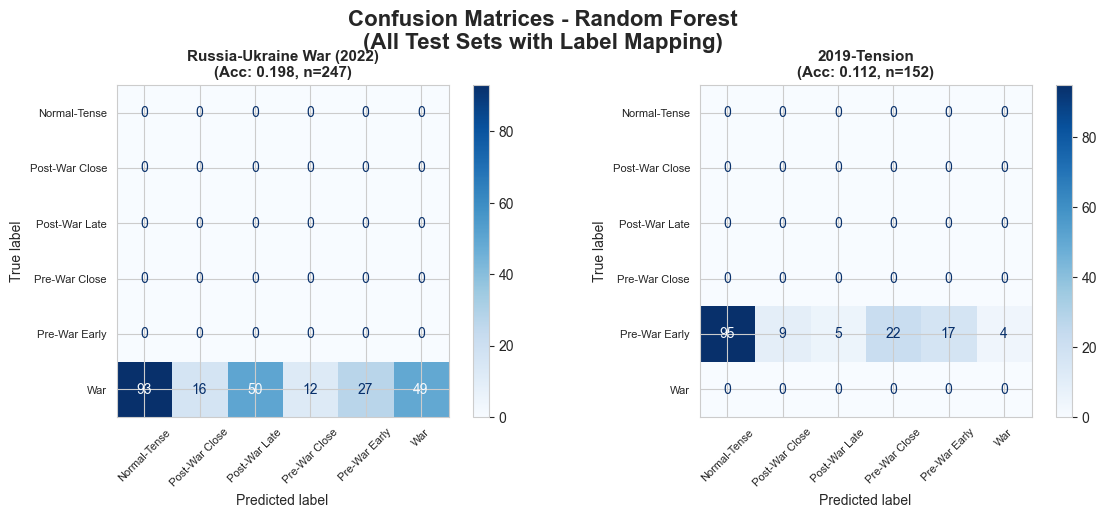


Random Forest - Test Set Accuracies (with label mapping):
  Russia-Ukraine War (2022): 0.1984 (19.84%) - 247 samples
  2019-Tension: 0.1118 (11.18%) - 152 samples

  💾 Saved: images/confusion_matrix_Logistic Regression_all_tests.png


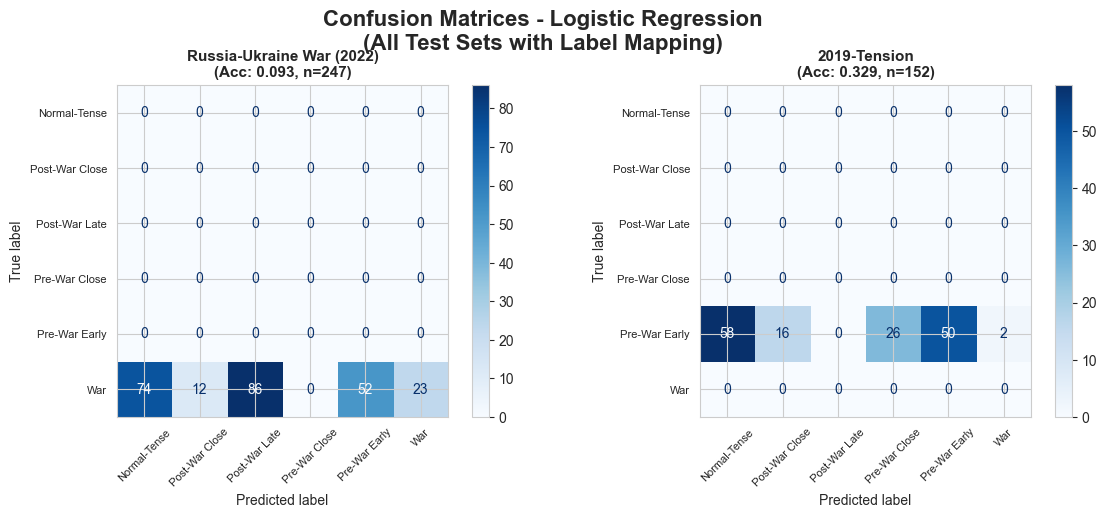


Logistic Regression - Test Set Accuracies (with label mapping):
  Russia-Ukraine War (2022): 0.0931 (9.31%) - 247 samples
  2019-Tension: 0.3289 (32.89%) - 152 samples

  💾 Saved: images/confusion_matrix_SVM (RBF)_all_tests.png


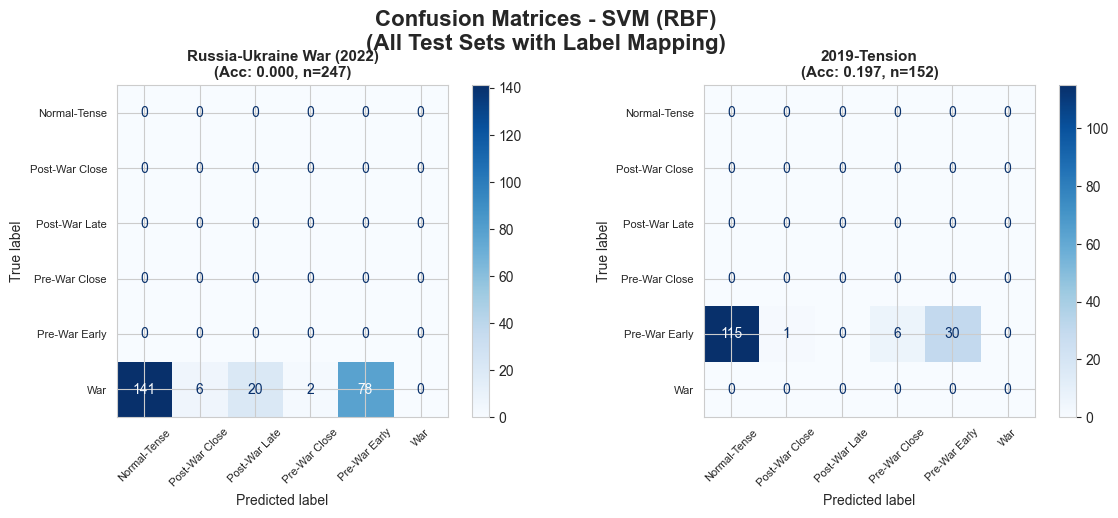


SVM (RBF) - Test Set Accuracies (with label mapping):
  Russia-Ukraine War (2022): 0.0000 (0.00%) - 247 samples
  2019-Tension: 0.1974 (19.74%) - 152 samples



In [316]:
# ============================================================================
# CONFUSION MATRICES FOR ALL TEST SETS (Using Label Mapping)
# ============================================================================

# Label mapping: Map test set labels to closest training labels
label_mapping = {
    'Normal': 'Normal-Tense',  # Normal periods map to Normal-Tense (closest match)
    '2019-Tension': 'Pre-War Early',  # Tension period maps to Pre-War Early
    'Normal-COVID': 'Normal-Tense',  # COVID normal maps to Normal-Tense
    'Russia-Ukraine-Pre-War': 'Pre-War Early',  # Pre-war maps to Pre-War Early
    'Russia-Ukraine-War': 'War',  # War maps to War
    'Israel-Hamas-Pre-War': 'Pre-War Early',  # Pre-war maps to Pre-War Early
    'Israel-Hamas-War': 'War',  # War maps to War
    'Unlabeled': None  # Cannot map unlabeled data
}

print(f"{'='*80}")
print("CONFUSION MATRICES FOR ALL TEST SETS")
print(f"{'='*80}")
print(f"\nLabel Mapping (Test Label -> Training Label):")
for test_label, train_label in label_mapping.items():
    if train_label is not None:
        print(f"  {test_label} -> {train_label}")
print()

# Filter test_set_info to only include keys that exist in X_test_dict
# This prevents KeyError if test_set_info has old keys like 'test_2018'
if 'test_set_info' not in globals():
    test_set_info = {}
else:
    test_set_info = {k: v for k, v in test_set_info.items() if k in X_test_dict}

test_sets_with_labels = [t for t in test_set_info.keys() 
                        if t != 'test_2026' and t in X_test_dict and len(X_test_dict[t]) > 0]

# Create confusion matrices for each model and each test set
n_models = len(trained_models)
n_test_sets = len(test_sets_with_labels)

if n_test_sets > 0:
    # Create a figure for each model
    for model_idx, (model_name, model) in enumerate(trained_models.items()):
        # Calculate number of rows and columns for subplots
        n_cols = min(3, n_test_sets)
        n_rows = (n_test_sets + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
        fig.suptitle(f'Confusion Matrices - {model_name}\n(All Test Sets with Label Mapping)', 
                     fontsize=16, fontweight='bold')
        
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        for test_idx, test_name in enumerate(test_sets_with_labels):
            if test_idx < len(axes):
                ax = axes[test_idx]
                test_df, test_display_name, expected_label = test_set_info[test_name]
                
                # Get predictions for this test set
                if test_name in all_test_predictions[model_name]:
                    y_test_pred = all_test_predictions[model_name][test_name]
                    y_test_labels = y_test_dict[test_name]
                    
                    # Map test labels to training labels
                    mapped_label = label_mapping.get(expected_label)
                    if mapped_label is not None and mapped_label in label_encoder.classes_:
                        y_test_mapped = np.array([label_mapping.get(label, mapped_label) for label in y_test_labels])
                        y_test_encoded = label_encoder.transform(y_test_mapped)
                        
                        # Create confusion matrix
                        cm = confusion_matrix(y_test_encoded, y_test_pred, labels=range(len(label_encoder.classes_)))
                        
                        # Display
                        disp = ConfusionMatrixDisplay(
                            confusion_matrix=cm,
                            display_labels=label_encoder.classes_
                        )
                        disp.plot(ax=ax, cmap='Blues', values_format='d')
                        
                        # Calculate accuracy
                        acc = accuracy_score(y_test_encoded, y_test_pred)
                        
                        ax.set_title(f'{test_display_name}\n(Acc: {acc:.3f}, n={len(y_test_pred)})', 
                                   fontsize=11, fontweight='bold')
                        ax.tick_params(axis='x', rotation=45, labelsize=8)
                        ax.tick_params(axis='y', rotation=0, labelsize=8)
                    else:
                        ax.text(0.5, 0.5, f'Cannot map\n{expected_label}', 
                               ha='center', va='center', transform=ax.transAxes)
                        ax.set_title(test_display_name, fontsize=11)
                else:
                    ax.text(0.5, 0.5, 'No predictions', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(test_display_name, fontsize=11)
        
        # Hide unused subplots
        for idx in range(n_test_sets, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        save_figure(fig, filename=f'confusion_matrix_{model_name}_all_tests')
        plt.show()
        
        # Print summary statistics
        print(f"\n{model_name} - Test Set Accuracies (with label mapping):")
        for test_name in test_sets_with_labels:
            test_df, test_display_name, expected_label = test_set_info[test_name]
            if test_name in all_test_predictions[model_name]:
                y_test_pred = all_test_predictions[model_name][test_name]
                y_test_labels = y_test_dict[test_name]
                mapped_label = label_mapping.get(expected_label)
                if mapped_label is not None and mapped_label in label_encoder.classes_:
                    y_test_mapped = np.array([label_mapping.get(label, mapped_label) for label in y_test_labels])
                    y_test_encoded = label_encoder.transform(y_test_mapped)
                    acc = accuracy_score(y_test_encoded, y_test_pred)
                    print(f"  {test_display_name}: {acc:.4f} ({acc*100:.2f}%) - {len(y_test_pred)} samples")
        print()

else:
    print("No test sets with labels available for confusion matrices.")

  💾 Saved: images/confusion_matrix_training_set.png


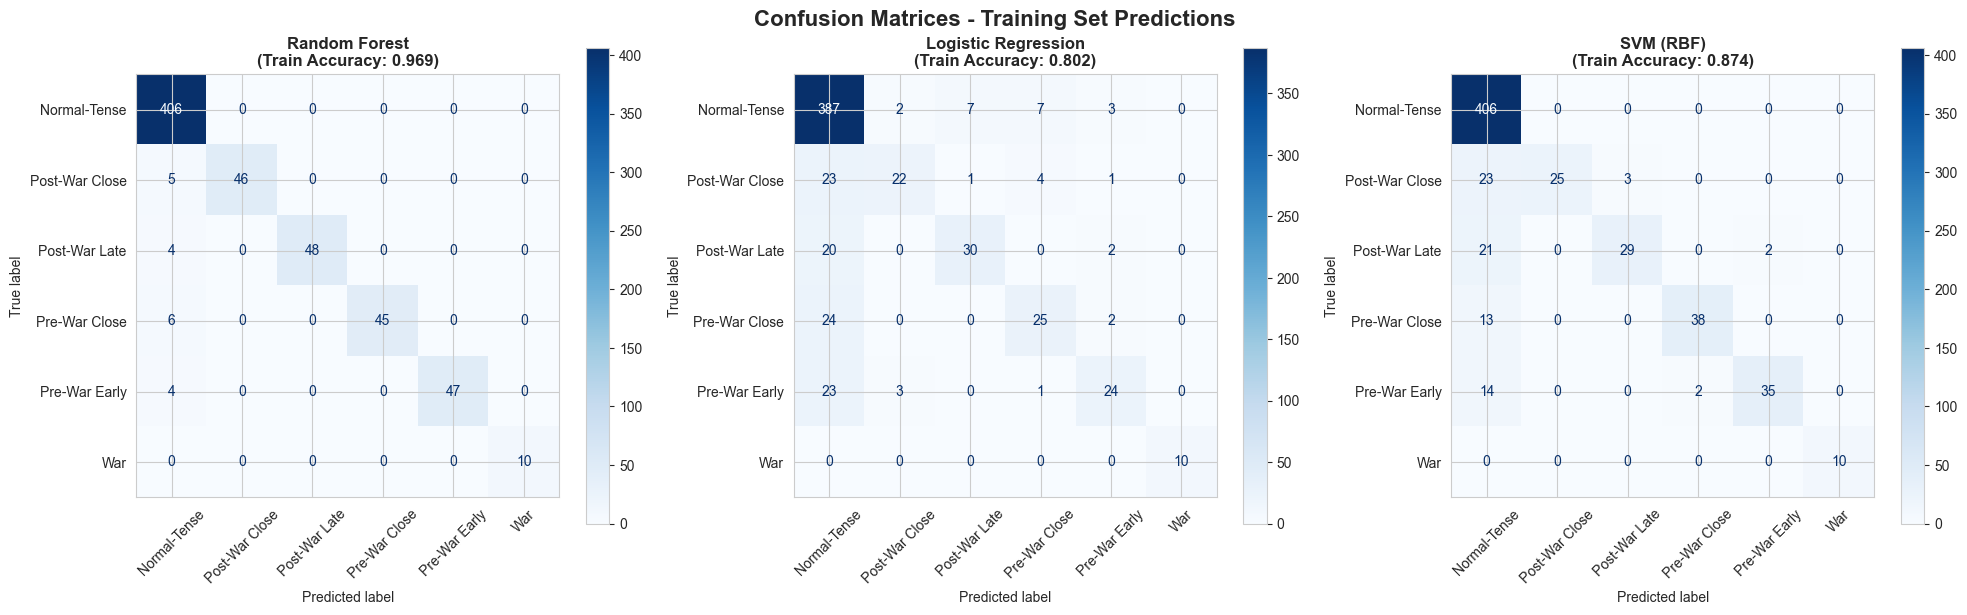


⚠️  Note: Test set (2026) is unlabeled - cannot create confusion matrix.


In [317]:
# ============================================================================
# VISUALIZATION: CONFUSION MATRICES (Training Set Only)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices - Training Set Predictions', fontsize=16, fontweight='bold')

for idx, (name, model) in enumerate(trained_models.items()):
    ax = axes[idx]
    
    # Get predictions for training set
    y_train_pred = model.predict(X_train)
    
    # Confusion matrix
    cm = confusion_matrix(y_train_encoded, y_train_pred)
    
    # Display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_
    )
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'{name}\n(Train Accuracy: {train_scores[name]:.3f})', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
save_figure(fig, filename='confusion_matrix_training_set')
plt.show()

print(f"\n⚠️  Note: Test set (2026) is unlabeled - cannot create confusion matrix.")

FEATURE IMPORTANCE (Random Forest)
                         feature  importance
WTI_price_vol_30d_zscore_rolling    0.217699
   spread_vol_30d_zscore_rolling    0.202645
           spread_zscore_rolling    0.138930
   WTI_return_30d_zscore_rolling    0.117093
 WTI_price_vol_5d_zscore_rolling    0.064883
    spread_vol_5d_zscore_rolling    0.063397
WTI_price_vol_24h_zscore_rolling    0.048871
    WTI_return_5d_zscore_rolling    0.042369
   spread_vol_24h_zscore_rolling    0.035693
 BRENT_abs_change_zscore_rolling    0.025967
   WTI_abs_change_zscore_rolling    0.022405
    WTI_return_1d_zscore_rolling    0.020049
  💾 Saved: images/model_feature_importance.png


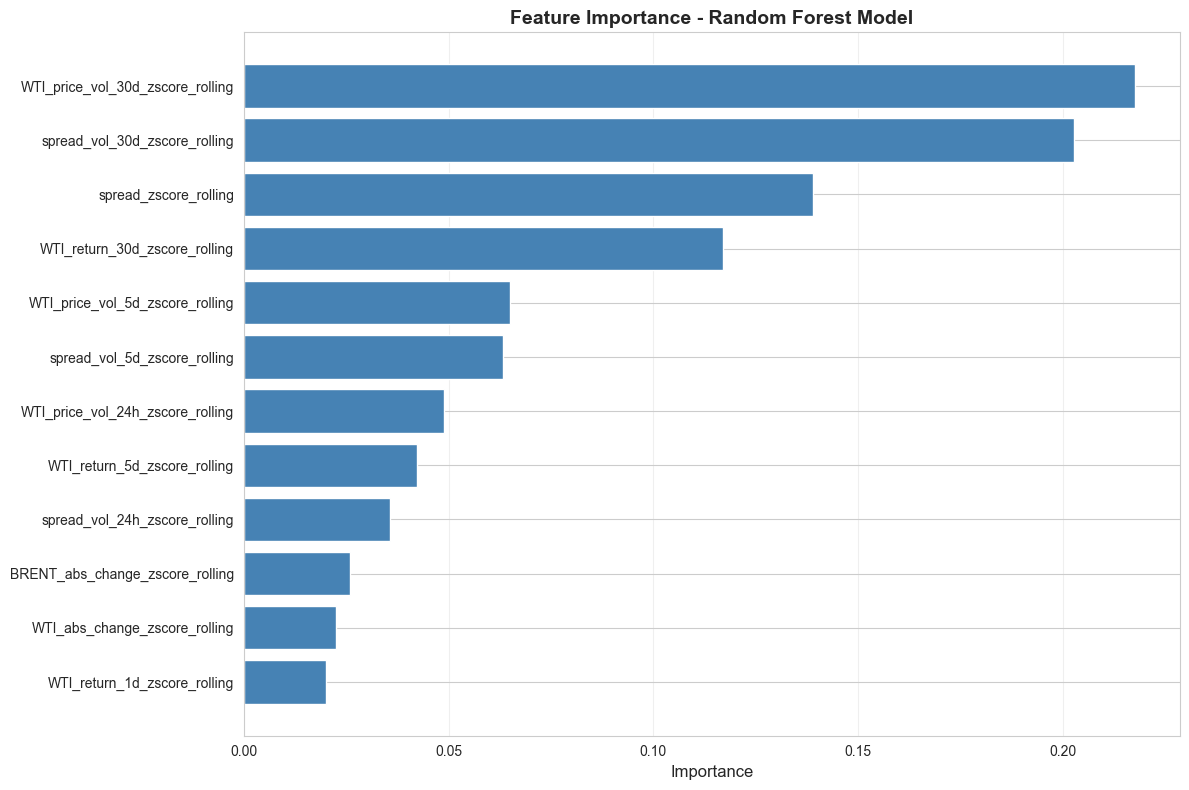

In [318]:
# ============================================================================
# FEATURE IMPORTANCE (Random Forest)
# ============================================================================

if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    
    # Use the features that were actually used for training (rolling z-scores)
    # Make sure zscore_rolling_features is defined
    if 'zscore_rolling_features' not in locals() or len(zscore_rolling_features) == 0:
        # Try to get it from df if available
        if 'df' in locals():
            zscore_rolling_features = [col for col in df.columns if col.endswith('_zscore_rolling')]
        else:
            print("⚠️  Error: Cannot find zscore_rolling_features. Make sure data preparation cell has been run.")
            zscore_rolling_features = []
    
    # Check that lengths match
    if len(zscore_rolling_features) != len(feature_importance):
        print(f"⚠️  Warning: Feature count mismatch!")
        print(f"  zscore_rolling_features: {len(zscore_rolling_features)}")
        print(f"  feature_importance: {len(feature_importance)}")
        print(f"  Using first {min(len(zscore_rolling_features), len(feature_importance))} features")
        min_len = min(len(zscore_rolling_features), len(feature_importance))
        zscore_rolling_features = zscore_rolling_features[:min_len]
        feature_importance = feature_importance[:min_len]
    
    if len(zscore_rolling_features) > 0 and len(feature_importance) > 0:
        # Create DataFrame for easier visualization
        importance_df = pd.DataFrame({
            'feature': zscore_rolling_features,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        print(f"{'='*80}")
        print("FEATURE IMPORTANCE (Random Forest)")
        print(f"{'='*80}")
        print(importance_df.to_string(index=False))
        
        # Visualize
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
        ax.set_yticks(range(len(importance_df)))
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance', fontsize=12)
        ax.set_title('Feature Importance - Random Forest Model', fontsize=14, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        save_figure(fig, filename='model_feature_importance')
        plt.show()
    else:
        print("⚠️  Cannot display feature importance - no features available")
else:
    print("Random Forest model not found in trained_models")

PREDICTIONS FOR KEY PERIODS (Simplified)

────────────────────────────────────────────────────────────────────────────────
Model: Random Forest
────────────────────────────────────────────────────────────────────────────────

  Iran-Related War (Training): 215 predictions
    Predicted label distribution:
      Normal-Tense: 19 (8.8%)
      Post-War Close: 46 (21.4%)
      Post-War Late: 48 (22.3%)
      Pre-War Close: 45 (20.9%)
      Pre-War Early: 47 (21.9%)
      War: 10 (4.7%)

  Russia-Ukraine War (2022): 247 predictions
    Expected label: Russia-Ukraine-War
    Predicted label distribution:
      Normal-Tense: 93 (37.7%)
      Post-War Close: 16 (6.5%)
      Post-War Late: 50 (20.2%)
      Pre-War Close: 12 (4.9%)
      Pre-War Early: 27 (10.9%)
      War: 49 (19.8%)

  2019-Tension: 152 predictions
    Expected label: 2019-Tension
    Predicted label distribution:
      Normal-Tense: 95 (62.5%)
      Post-War Close: 9 (5.9%)
      Post-War Late: 5 (3.3%)
      Pre-War Close: 2


  Iran-Related War (Training): 215 predictions
    Predicted label distribution:
      Normal-Tense: 90 (41.9%)
      Post-War Close: 25 (11.6%)
      Post-War Late: 31 (14.4%)
      Pre-War Close: 30 (14.0%)
      Pre-War Early: 29 (13.5%)
      War: 10 (4.7%)

  Russia-Ukraine War (2022): 247 predictions
    Expected label: Russia-Ukraine-War
    Predicted label distribution:
      Normal-Tense: 74 (30.0%)
      Post-War Close: 12 (4.9%)
      Post-War Late: 86 (34.8%)
      Pre-War Early: 52 (21.1%)
      War: 23 (9.3%)

  2019-Tension: 152 predictions
    Expected label: 2019-Tension
    Predicted label distribution:
      Normal-Tense: 58 (38.2%)
      Post-War Close: 16 (10.5%)
      Pre-War Close: 26 (17.1%)
      Pre-War Early: 50 (32.9%)
      War: 2 (1.3%)

  2026+ (Unlabeled): 31 predictions
    Expected label: Unlabeled
    Predicted label distribution:
      Normal-Tense: 19 (61.3%)
      Post-War Late: 12 (38.7%)

─────────────────────────────────────────────────────────

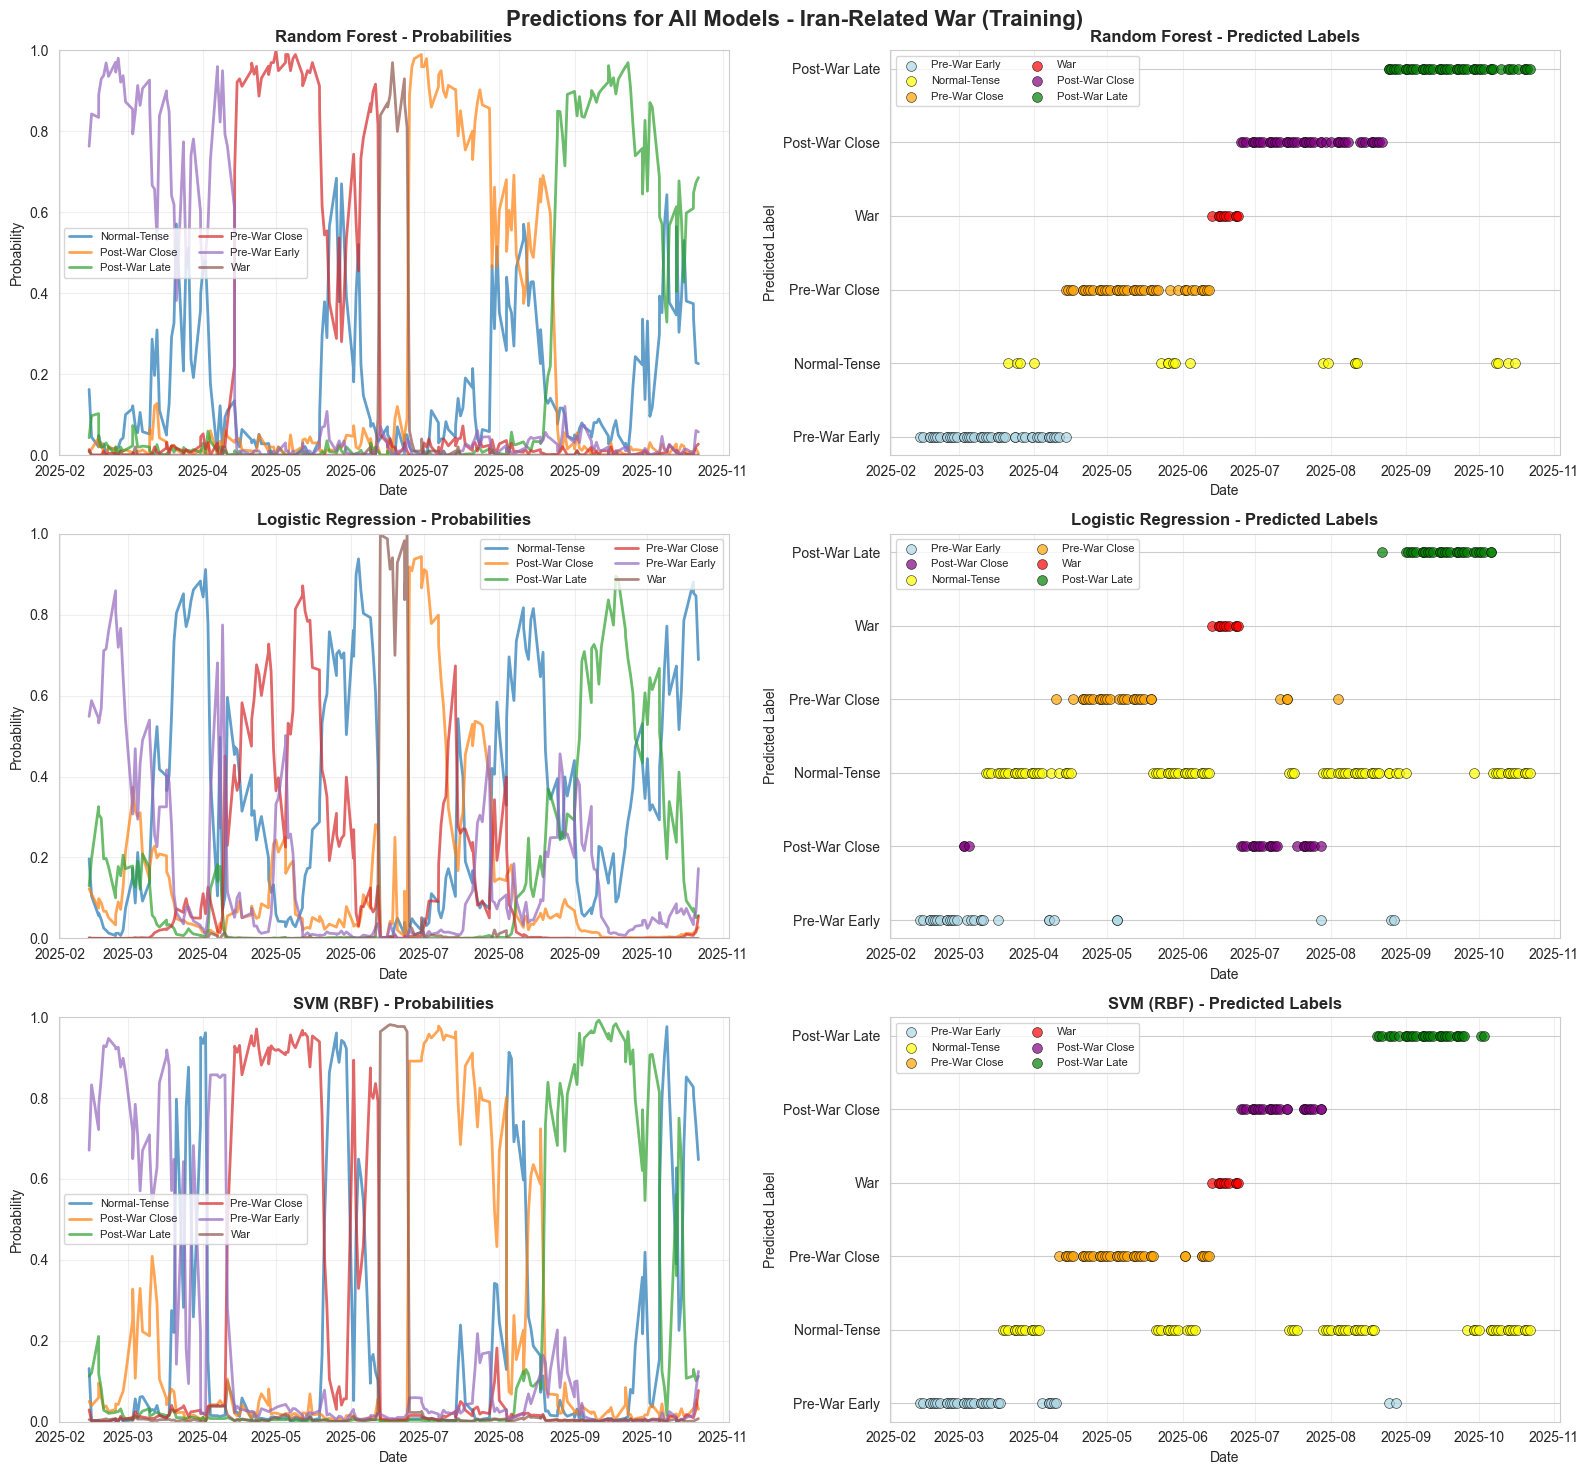

  💾 Saved: images/predictions_2026.png


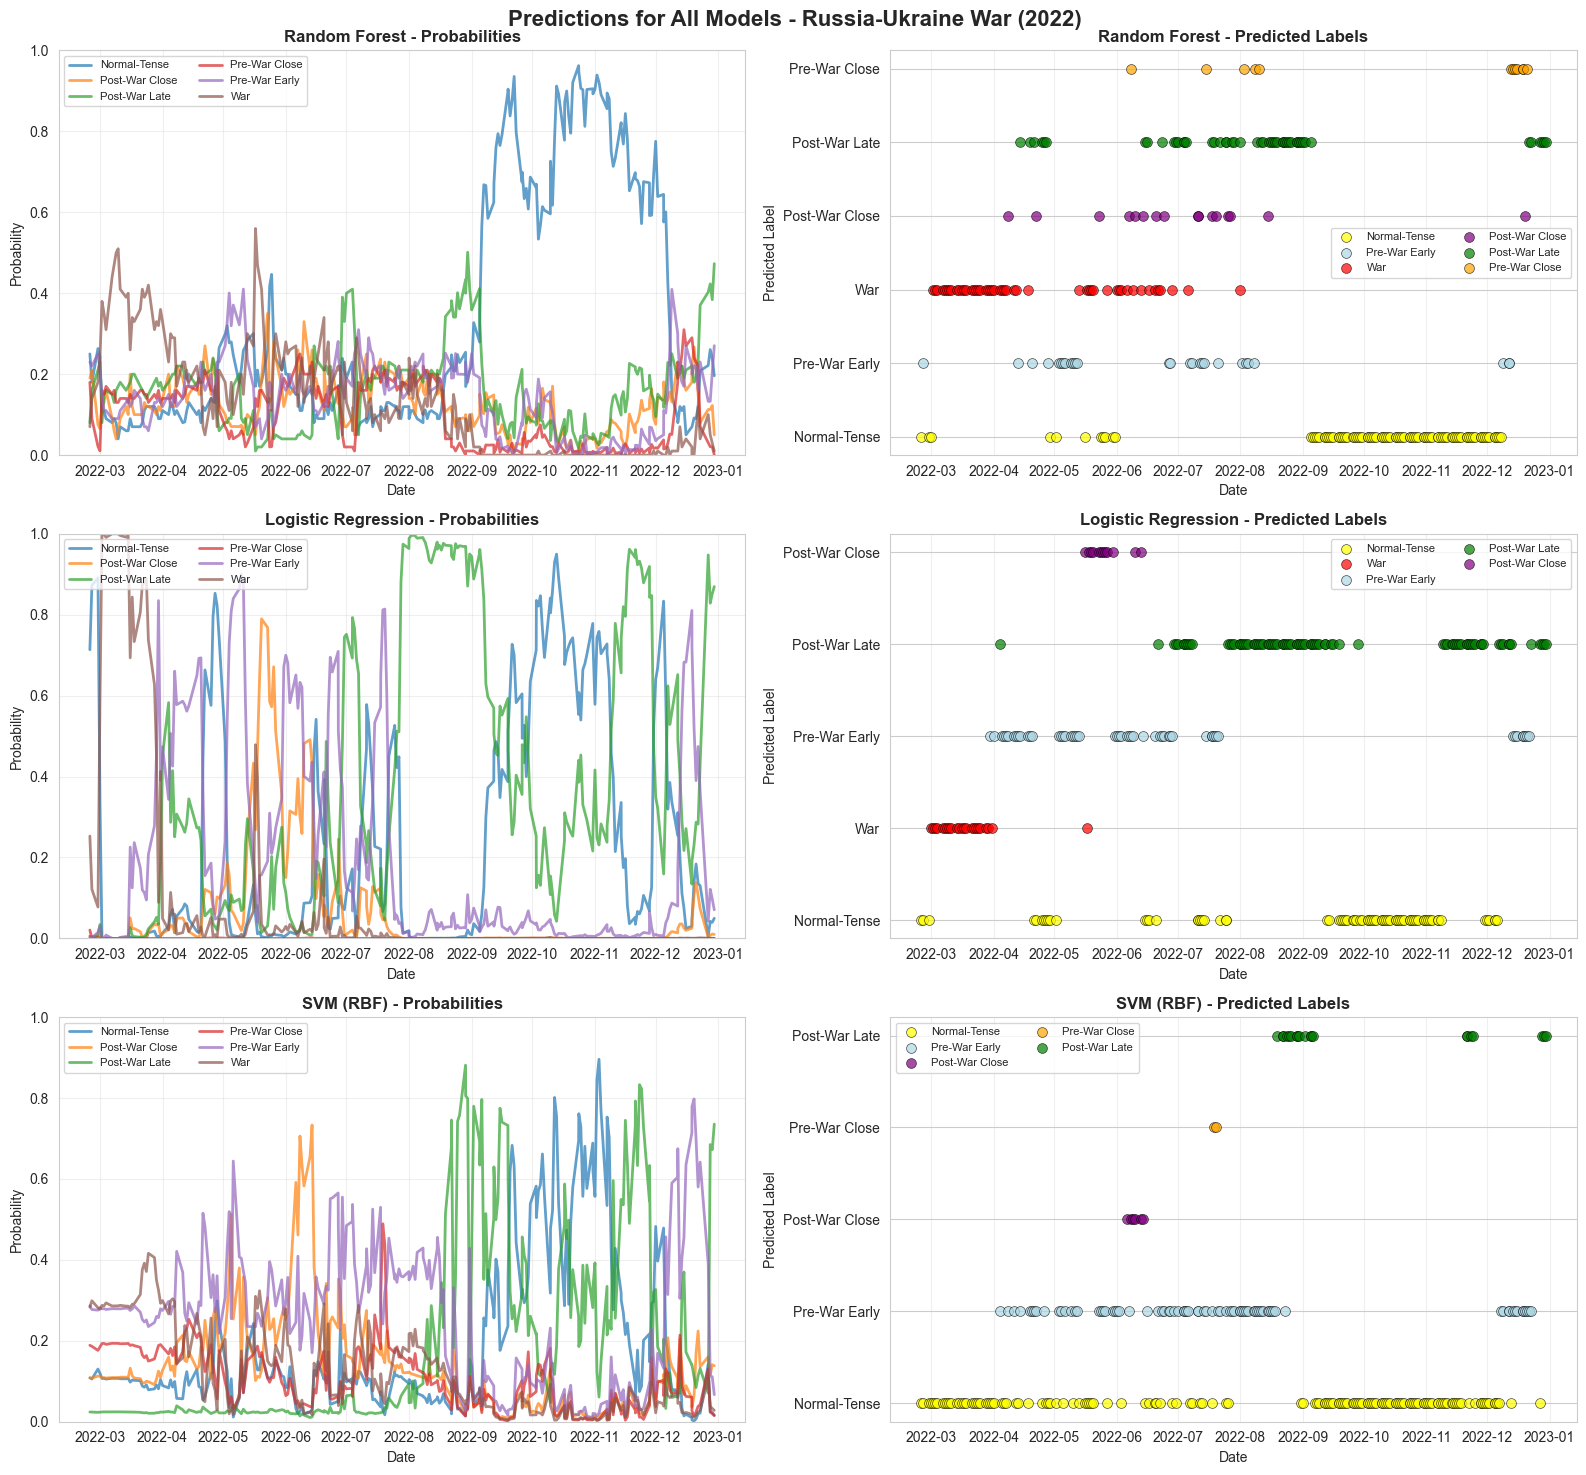

  💾 Saved: images/predictions_2026.png


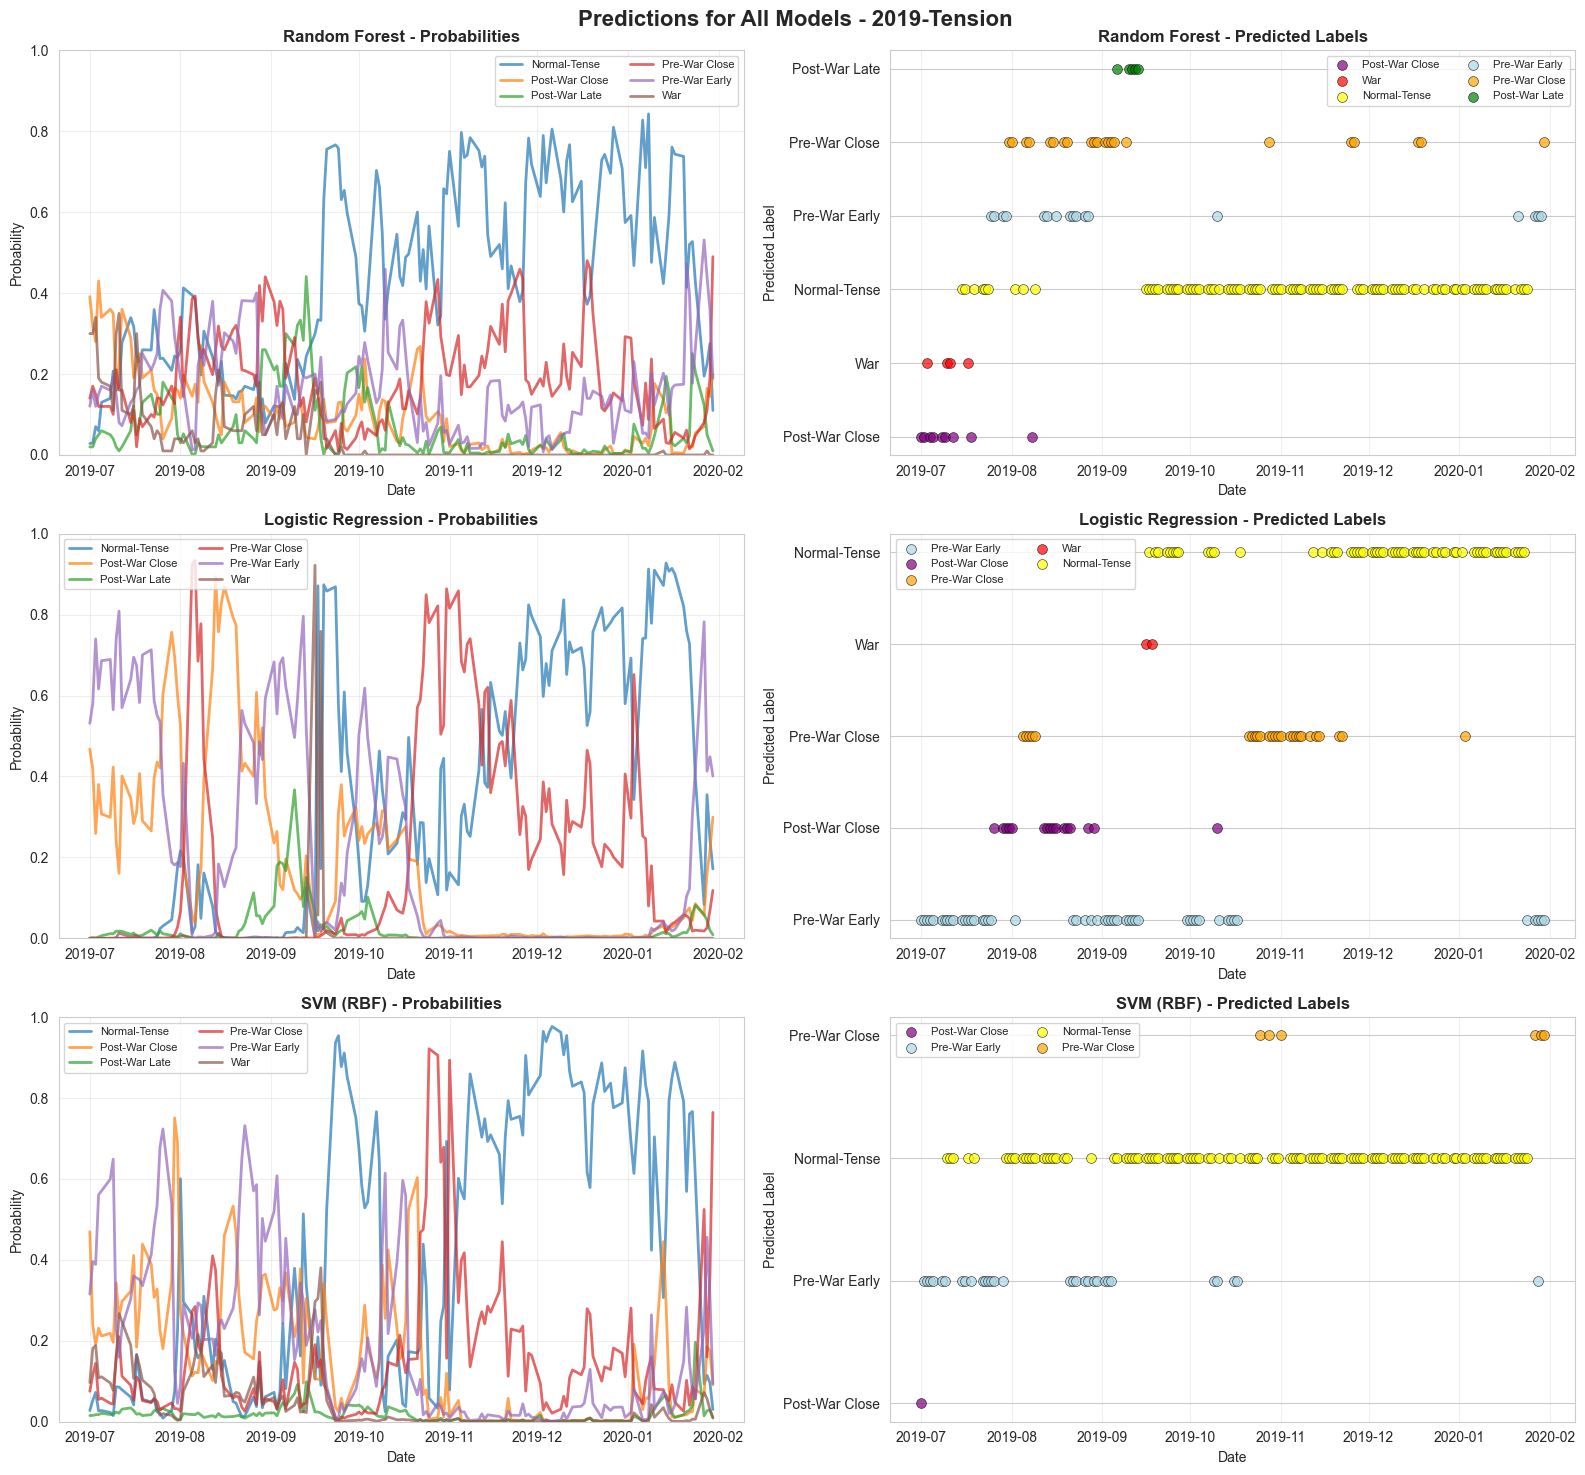

  💾 Saved: images/predictions_2026.png


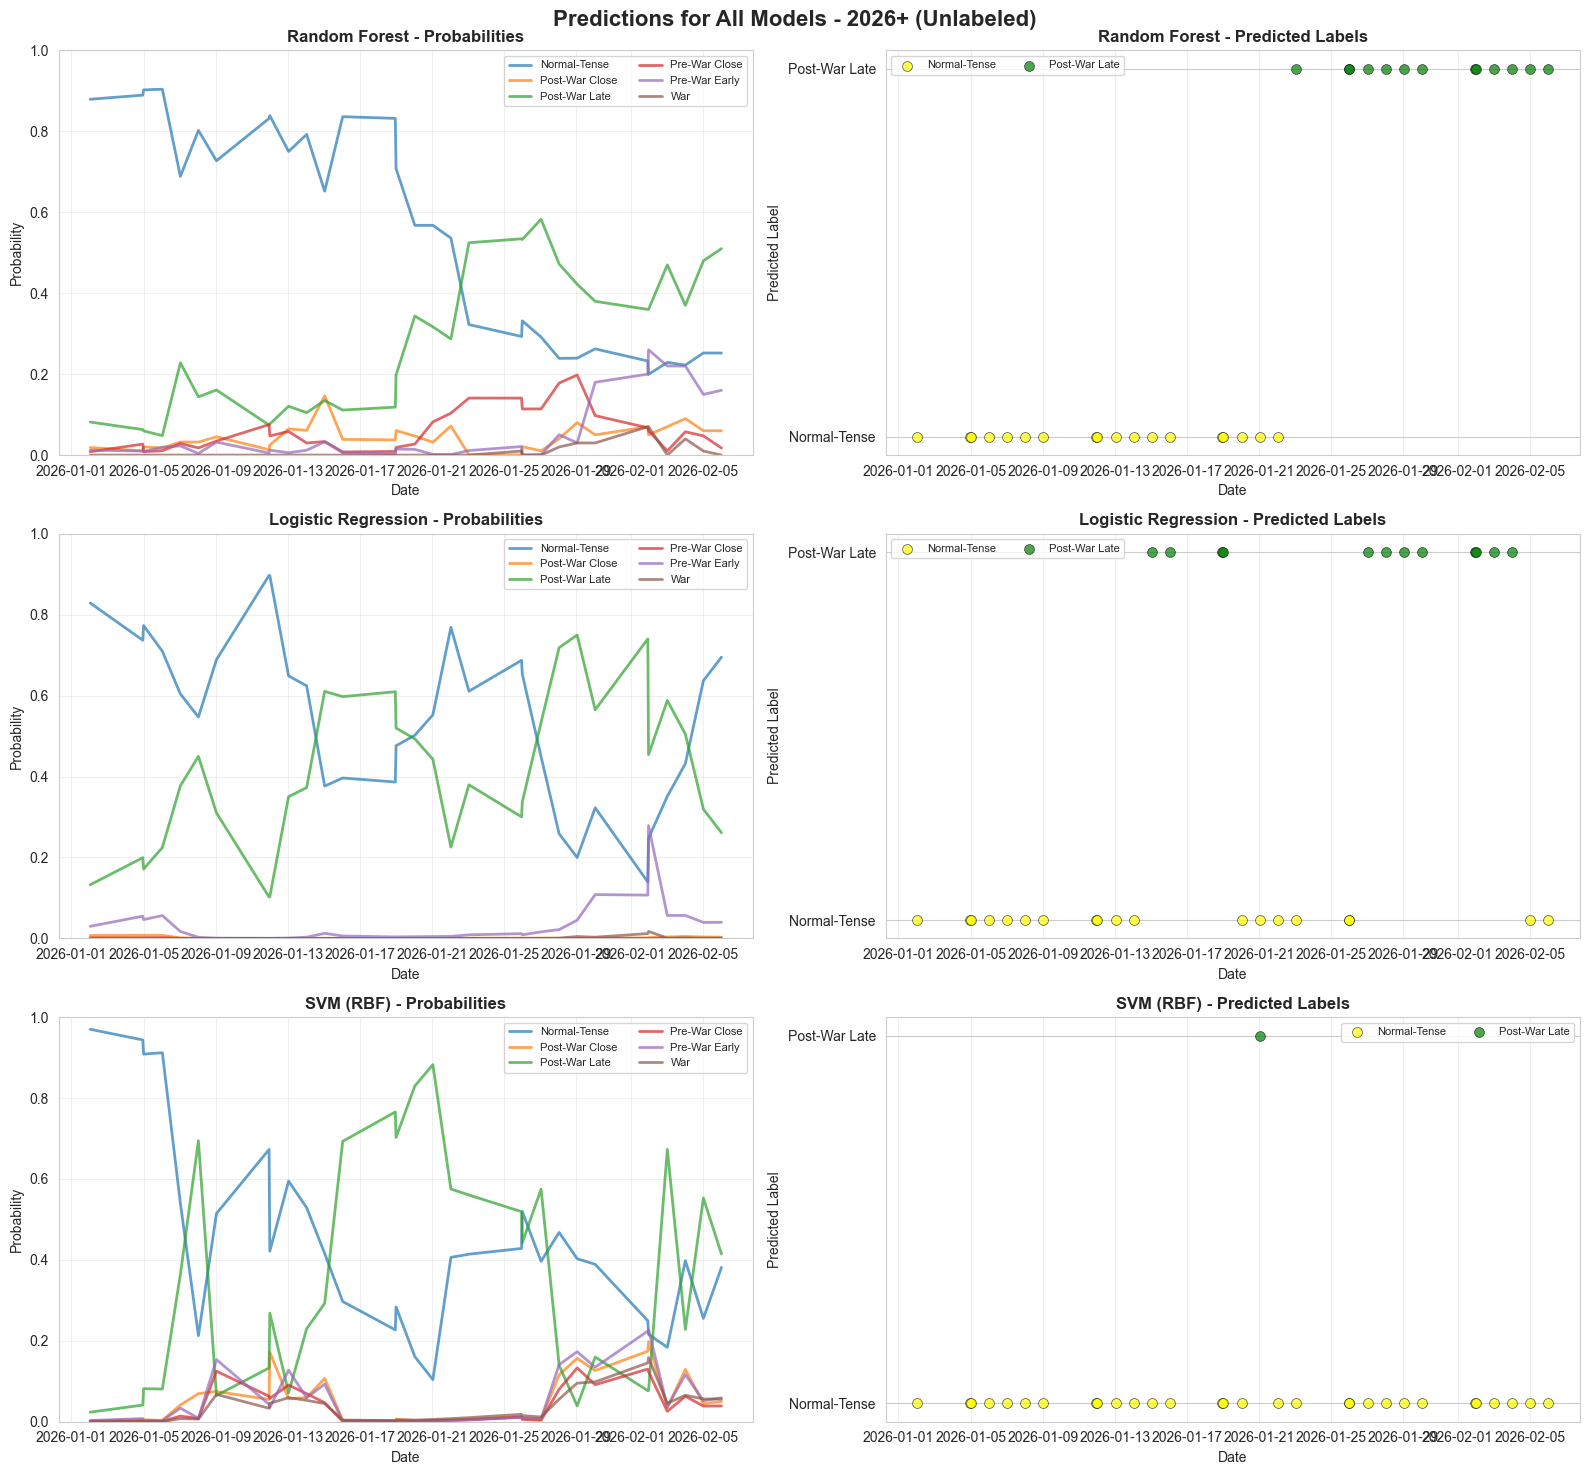


PREDICTIONS COMPLETE


In [319]:
# ============================================================================
# PREDICTIONS FOR KEY PERIODS (SIMPLIFIED)
# ============================================================================
# Focus: War (Iran), Russian War, 2019 Tension, 2026

print(f"{'='*80}")
print("PREDICTIONS FOR KEY PERIODS (Simplified)")
print(f"{'='*80}")

# Label colors for visualization
label_colors = {
    'Normal': 'gray',
    'Normal-Tense': 'yellow',
    'Pre-War Early': 'lightblue',
    'Pre-War Close': 'orange',
    'War': 'red',
    'Russia-Ukraine-War': 'crimson',
    '2019-Tension': 'orangered',
    'Post-War Close': 'purple',
    'Post-War Late': 'green',
    'Unlabeled': 'black'
}

# Get Iran-related war periods from training data
iran_war_labels = ['Pre-War Early', 'Pre-War Close', 'War', 'Post-War Close', 'Post-War Late']
df_train_iran = df_train[df_train['label'].isin(iran_war_labels)].copy()

# Focus on only 4 key periods
test_set_info = {
    'test_ru_war': (df_test_ru_war, 'Russia-Ukraine War (2022)', 'Russia-Ukraine-War'),
    'test_2019_tension': (df_test_2019_tension, '2019-Tension', '2019-Tension'),
    'test_2026': (df_test_2026, '2026+ (Unlabeled)', 'Unlabeled')
}

# Store predictions for all models and all test sets
all_predictions = {}  # {model_name: {test_name: results_df}}

# Process predictions for all models
for model_name in trained_models.keys():
    print(f"\n{'─'*80}")
    print(f"Model: {model_name}")
    print(f"{'─'*80}")
    
    all_predictions[model_name] = {}
    
    # Process Iran war training data separately (not in X_test_dict)
    if len(df_train_iran) > 0:
        X_train_iran = df_train_iran[zscore_rolling_features].values
        y_train_iran_pred = trained_models[model_name].predict(X_train_iran)
        y_train_iran_proba = trained_models[model_name].predict_proba(X_train_iran)
        
        results_df_iran = df_train_iran.copy()
        results_df_iran['predicted_label'] = label_encoder.inverse_transform(y_train_iran_pred)
        results_df_iran['predicted_label_encoded'] = y_train_iran_pred
        
        for i, label in enumerate(label_encoder.classes_):
            results_df_iran[f'prob_{label}'] = y_train_iran_proba[:, i]
        
        results_df_iran['test_set'] = 'Iran-Related War (Training)'
        results_df_iran['test_name'] = 'train_iran_war'
        
        all_predictions[model_name]['train_iran_war'] = results_df_iran
        print(f"\n  Iran-Related War (Training): {len(results_df_iran)} predictions")
        print(f"    Predicted label distribution:")
        pred_dist = results_df_iran['predicted_label'].value_counts().sort_index()
        for label, count in pred_dist.items():
            print(f"      {label}: {count} ({count/len(results_df_iran)*100:.1f}%)")
    
    # Process test sets (these are in X_test_dict)
    for test_name, (test_df, test_display_name, expected_label) in test_set_info.items():
        if test_name in X_test_dict and len(X_test_dict[test_name]) > 0:
            # Get stored predictions and probabilities
            y_test_pred = all_test_predictions[model_name][test_name]
            y_test_proba = all_test_probabilities[model_name][test_name]
            
            # Create results DataFrame
            results_df = test_df.copy()
            results_df['predicted_label'] = label_encoder.inverse_transform(y_test_pred)
            results_df['predicted_label_encoded'] = y_test_pred
            
            # Add probability columns
            for i, label in enumerate(label_encoder.classes_):
                results_df[f'prob_{label}'] = y_test_proba[:, i]
            
            results_df['test_set'] = test_display_name
            results_df['test_name'] = test_name
            
            # Store results
            all_predictions[model_name][test_name] = results_df
            
            # Print summary
            print(f"\n  {test_display_name}: {len(results_df)} predictions")
            print(f"    Expected label: {expected_label}")
            print(f"    Predicted label distribution:")
            pred_dist = results_df['predicted_label'].value_counts().sort_index()
            for label, count in pred_dist.items():
                print(f"      {label}: {count} ({count/len(results_df)*100:.1f}%)")
        else:
            print(f"\n  {test_display_name}: No data")
            all_predictions[model_name][test_name] = pd.DataFrame()

# ============================================================================
# VISUALIZATION: PREDICTED PROBABILITIES FOR KEY PERIODS
# ============================================================================

n_models = len(trained_models)
# Include training data in visualization
all_periods = ['train_iran_war'] + list(test_set_info.keys())
all_periods = [p for p in all_periods if p in all_predictions[list(trained_models.keys())[0]]]

# Create separate figure for each period
for period_name in all_periods:
    # Get display name
    if period_name == 'train_iran_war':
        display_name = 'Iran-Related War (Training)'
    else:
        _, display_name, _ = test_set_info[period_name]
    
    # Create figure for this period
    fig, axes = plt.subplots(n_models, 2, figsize=(16, 5*n_models))
    fig.suptitle(f'Predictions for All Models - {display_name}', fontsize=16, fontweight='bold')
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for idx, model_name in enumerate(trained_models.keys()):
        if period_name in all_predictions[model_name] and len(all_predictions[model_name][period_name]) > 0:
            results_df = all_predictions[model_name][period_name].copy()
            results_df = results_df.sort_values('date')
            
            # Plot 1: Probabilities
            ax = axes[idx, 0]
            for label in label_encoder.classes_:
                if f'prob_{label}' in results_df.columns:
                    ax.plot(results_df['date'], results_df[f'prob_{label}'], 
                           label=label, linewidth=2, alpha=0.7)
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('Probability', fontsize=10)
            ax.set_title(f'{model_name} - Probabilities', fontsize=12, fontweight='bold')
            ax.legend(loc='best', fontsize=8, ncol=2)
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, 1])
            
            # Plot 2: Predicted labels
            ax = axes[idx, 1]
            unique_labels = results_df['predicted_label'].unique()
            for label in unique_labels:
                mask = results_df['predicted_label'] == label
                ax.scatter(results_df[mask]['date'], 
                          [label]*mask.sum(),
                          c=label_colors.get(label, 'black'),
                          label=label, alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('Predicted Label', fontsize=10)
            ax.set_title(f'{model_name} - Predicted Labels', fontsize=12, fontweight='bold')
            ax.legend(loc='best', fontsize=8, ncol=2)
            ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    save_figure(fig, filename=f'predictions_{test_name.replace("test_", "")}')
    plt.show()

print(f"\n{'='*80}")
print("PREDICTIONS COMPLETE")
print(f"{'='*80}")

MAHALANOBIS DISTANCE ANALYSIS

Using global z-scores for Mahalanobis distance (12 features)

Using Normal-Tense periods only (from training data) for Mahalanobis distance baseline
  Baseline samples: 406 / 406 Normal-Tense samples
  Removed 0 samples with NaN/inf values

Thresholds (based on Normal-Tense baseline):
  90th percentile: 4.5407
  95th percentile: 5.1382
  99th percentile: 6.5123

Iran: Pre-War Early:
  Valid samples: 51 / 51
  Mean distance: 4.6418
  Max distance: 11.6239

Iran: Pre-War Close:
  Valid samples: 51 / 51
  Mean distance: 4.5747
  Max distance: 7.6380

Iran: War:
  Valid samples: 10 / 10
  Mean distance: 10.2164
  Max distance: 16.4260

Iran: Post-War Close:
  Valid samples: 51 / 51
  Mean distance: 4.4992
  Max distance: 10.4237

Iran: Post-War Late:
  Valid samples: 52 / 52
  Mean distance: 3.2072
  Max distance: 4.6360

Normal (2019 H1):
  Valid samples: 98 / 98
  Mean distance: 13.0126

2019-Tension:
  Valid samples: 152 / 152
  Mean distance: 8.9194

Russ

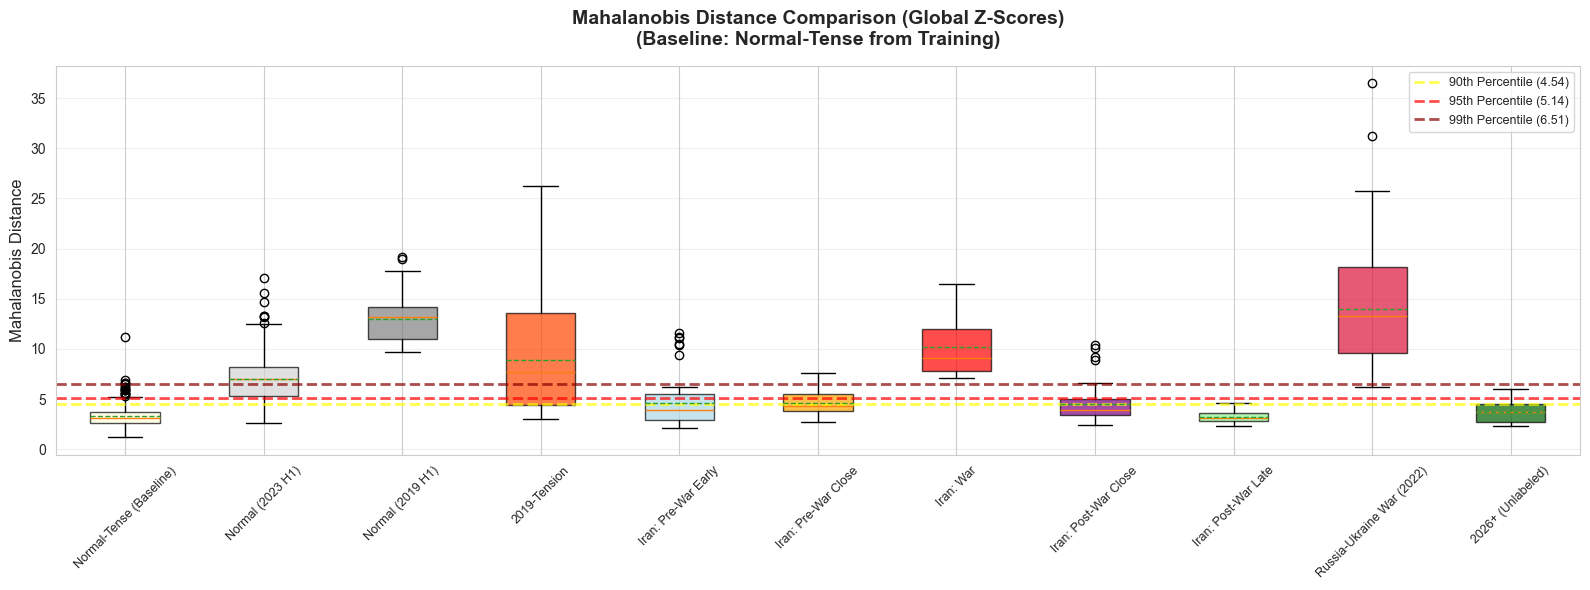

  💾 Saved: images/mahalanobis_timeseries_iran_periods.png


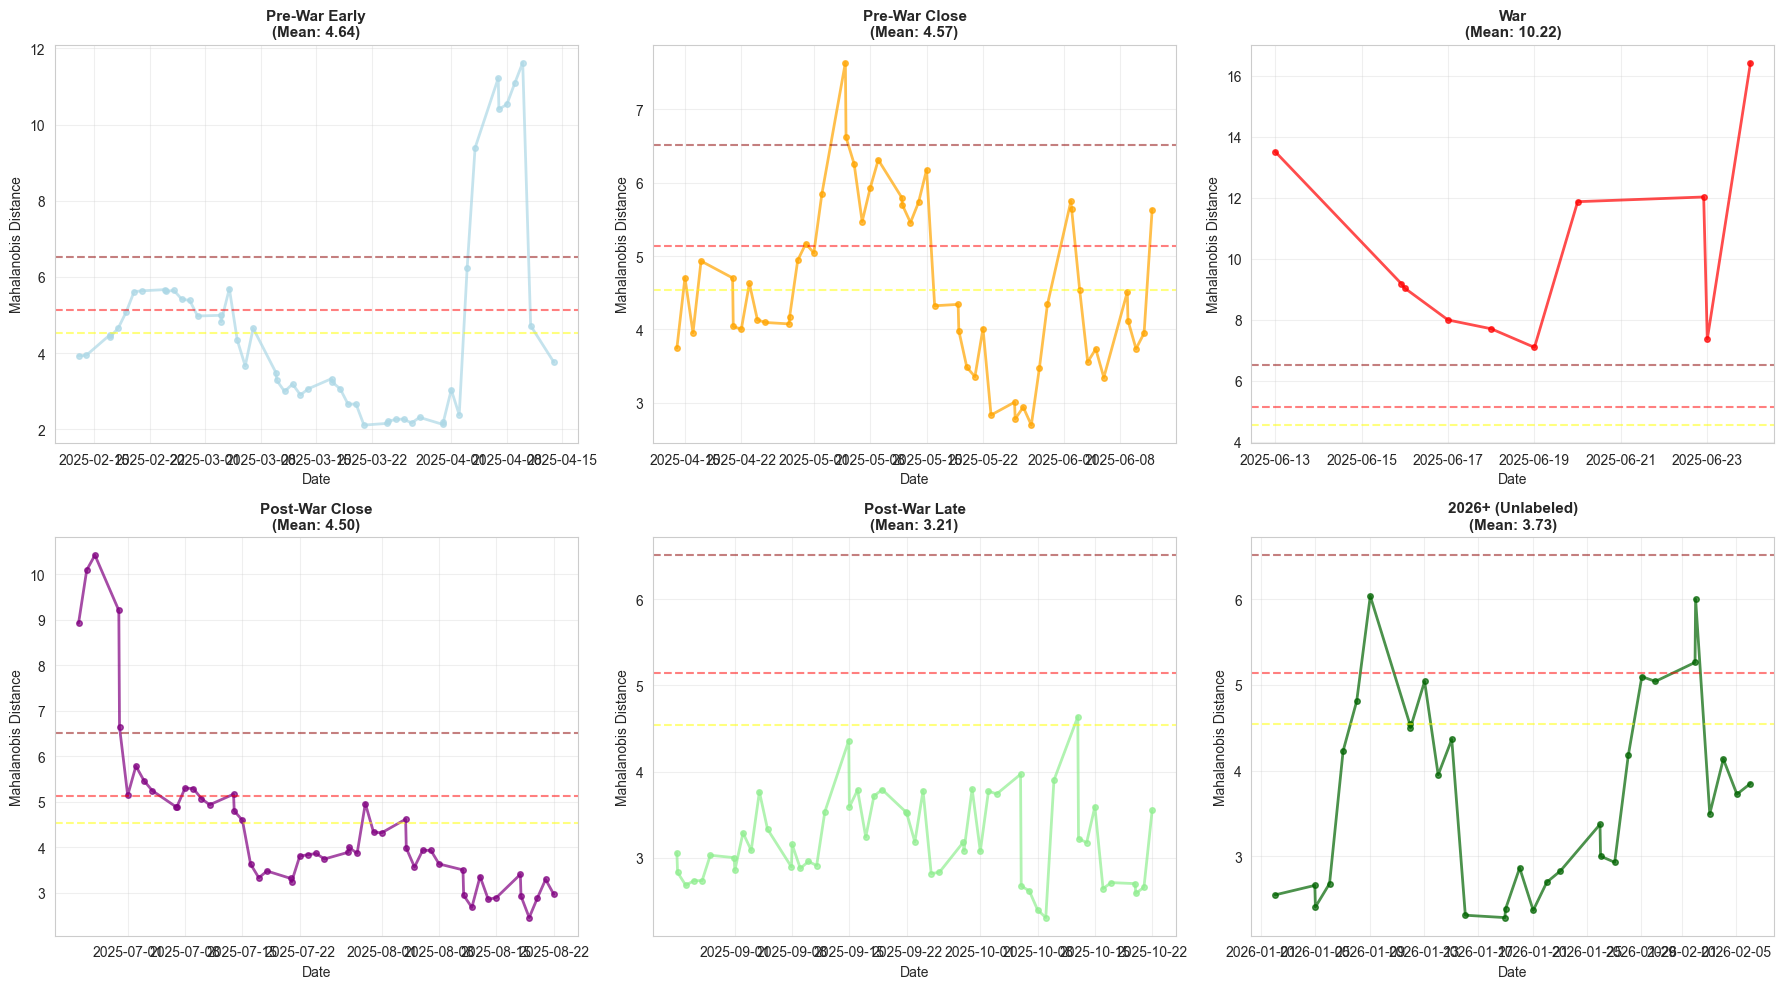

In [320]:
# ============================================================================
# MAHALANOBIS DISTANCE: ANOMALY DETECTION (Using Normal-Tense Baseline)
# ============================================================================

print(f"{'='*80}")
print("MAHALANOBIS DISTANCE ANALYSIS")
print(f"{'='*80}")

# Use global z-scores for Mahalanobis distance
zscore_global_features = [col for col in df.columns if col.endswith('_zscore_global')]
print(f"\nUsing global z-scores for Mahalanobis distance ({len(zscore_global_features)} features)")

# Use only "Normal-Tense" from training set as baseline
normal_tense_mask = df_train['label'] == 'Normal-Tense'
baseline_label = "Normal-Tense periods only (from training data)"

X_train_normal_tense = df_train[normal_tense_mask][zscore_global_features].values

# Remove any rows with NaN or inf values
valid_mask = ~(np.isnan(X_train_normal_tense).any(axis=1) | np.isinf(X_train_normal_tense).any(axis=1))
X_train_normal_tense = X_train_normal_tense[valid_mask]

print(f"\nUsing {baseline_label} for Mahalanobis distance baseline")
print(f"  Baseline samples: {len(X_train_normal_tense)} / {len(df_train[normal_tense_mask])} Normal-Tense samples")
print(f"  Removed {len(df_train[normal_tense_mask]) - len(X_train_normal_tense)} samples with NaN/inf values")

if len(X_train_normal_tense) < 2:
    raise ValueError("Not enough valid Normal-Tense samples for Mahalanobis distance calculation!")

# Calculate mean and covariance from Normal-Tense periods only
train_mean = np.mean(X_train_normal_tense, axis=0)
train_cov = np.cov(X_train_normal_tense.T)

# Check for NaN/inf in covariance matrix
if np.isnan(train_cov).any() or np.isinf(train_cov).any():
    print("Warning: Covariance matrix contains NaN/inf. Replacing with identity matrix...")
    train_cov = np.eye(train_cov.shape[0])

# Handle potential singular matrix (add small regularization)
try:
    train_cov_inv = inv(train_cov)
    # Check for NaN/inf in inverse
    if np.isnan(train_cov_inv).any() or np.isinf(train_cov_inv).any():
        raise np.linalg.LinAlgError("Inverse contains NaN/inf")
except (np.linalg.LinAlgError, ValueError):
    # If matrix is singular or contains NaN/inf, add regularization
    print("Warning: Covariance matrix is singular or contains NaN/inf. Adding regularization...")
    train_cov_inv = inv(train_cov + np.eye(train_cov.shape[0]) * 1e-6)

# Calculate Mahalanobis distance function
def calculate_mahalanobis_distances(X_test_data, train_mean, train_cov_inv):
    """Calculate Mahalanobis distances for a test set"""
    # Remove NaN/inf values
    valid_mask = ~(np.isnan(X_test_data).any(axis=1) | np.isinf(X_test_data).any(axis=1))
    X_test_clean = X_test_data[valid_mask]
    
    if len(X_test_clean) == 0:
        return np.array([])
    
    mahalanobis_distances = []
    for i in range(len(X_test_clean)):
        test_point = X_test_clean[i]
        try:
            # Check for NaN/inf in test point
            if np.isnan(test_point).any() or np.isinf(test_point).any():
                mahalanobis_distances.append(np.nan)
                continue
            
            # Calculate difference from mean
            diff = test_point - train_mean
            # Check for NaN/inf in diff
            if np.isnan(diff).any() or np.isinf(diff).any():
                mahalanobis_distances.append(np.nan)
                continue
            
            # Calculate Mahalanobis distance: sqrt(diff^T * cov_inv * diff)
            dist = np.sqrt(diff.T @ train_cov_inv @ diff)
            
            # Check if result is valid
            if np.isnan(dist) or np.isinf(dist):
                mahalanobis_distances.append(np.nan)
            else:
                mahalanobis_distances.append(dist)
        except Exception as e:
            # Fallback: use Euclidean distance if Mahalanobis fails
            dist = np.linalg.norm(test_point - train_mean)
            mahalanobis_distances.append(dist if not (np.isnan(dist) or np.isinf(dist)) else np.nan)
    
    return np.array(mahalanobis_distances)

# Calculate thresholds from baseline data
baseline_distances = calculate_mahalanobis_distances(X_train_normal_tense, train_mean, train_cov_inv)
baseline_distances = baseline_distances[~np.isnan(baseline_distances)]  # Remove NaN values

if len(baseline_distances) > 0:
    threshold_90 = np.percentile(baseline_distances, 90)
    threshold_95 = np.percentile(baseline_distances, 95)
    threshold_99 = np.percentile(baseline_distances, 99)
    
    print(f"\nThresholds (based on Normal-Tense baseline):")
    print(f"  90th percentile: {threshold_90:.4f}")
    print(f"  95th percentile: {threshold_95:.4f}")
    print(f"  99th percentile: {threshold_99:.4f}")
else:
    print("\n⚠️  Warning: Could not calculate thresholds - no valid baseline distances")
    threshold_90 = threshold_95 = threshold_99 = np.nan

# Calculate Mahalanobis distances for ALL periods (separated)
mahal_dfs = []
all_mahalanobis_distances = []

# 1. Iran War periods from training data - SEPARATE EACH LABEL
iran_labels = ['Pre-War Early', 'Pre-War Close', 'War', 'Post-War Close', 'Post-War Late']
for label in iran_labels:
    df_period = df_train[df_train['label'] == label].copy()
    if len(df_period) > 0:
        X_period = df_period[zscore_global_features].values
        mahalanobis_distances = calculate_mahalanobis_distances(X_period, train_mean, train_cov_inv)
        
        mahal_df_period = df_period.copy()
        mahal_df_period['mahalanobis_distance'] = mahalanobis_distances
        mahal_df_period['test_set'] = f'Iran: {label}'
        mahal_df_period['test_name'] = f'train_{label.replace(" ", "_").replace("-", "_")}'
        
        # Remove NaN values
        mahal_df_period = mahal_df_period[~mahal_df_period['mahalanobis_distance'].isna()]
        
        if len(mahal_df_period) > 0:
            mahal_dfs.append(mahal_df_period)
            valid_distances = mahalanobis_distances[~np.isnan(mahalanobis_distances)]
            all_mahalanobis_distances.extend(valid_distances)
            
            print(f"\nIran: {label}:")
            print(f"  Valid samples: {len(valid_distances)} / {len(mahalanobis_distances)}")
            print(f"  Mean distance: {valid_distances.mean():.4f}")
            print(f"  Max distance: {valid_distances.max():.4f}")

# 2. Normal periods from test sets (for comparison)
if 'test_normal_2019' in X_test_dict and len(X_test_dict['test_normal_2019']) > 0:
    # Need to get features from DataFrame, not X_test_dict (which uses rolling z-scores)
    mahalanobis_distances_normal = calculate_mahalanobis_distances(
        df_test_normal_2019[zscore_global_features].values, train_mean, train_cov_inv
    )
    
    mahal_df_normal = df_test_normal_2019.copy()
    mahal_df_normal['mahalanobis_distance'] = mahalanobis_distances_normal
    mahal_df_normal['test_set'] = 'Normal (2019 H1)'
    mahal_df_normal['test_name'] = 'test_normal_2019'
    
    # Remove NaN values
    mahal_df_normal = mahal_df_normal[~mahal_df_normal['mahalanobis_distance'].isna()]
    
    if len(mahal_df_normal) > 0:
        mahal_dfs.append(mahal_df_normal)
        valid_distances = mahalanobis_distances_normal[~np.isnan(mahalanobis_distances_normal)]
        all_mahalanobis_distances.extend(valid_distances)
        
        print(f"\nNormal (2019 H1):")
        print(f"  Valid samples: {len(valid_distances)} / {len(mahalanobis_distances_normal)}")
        print(f"  Mean distance: {valid_distances.mean():.4f}")

# 3. 2019 Tension
if 'test_2019_tension' in X_test_dict and len(X_test_dict['test_2019_tension']) > 0:
    mahalanobis_distances_2019 = calculate_mahalanobis_distances(
        df_test_2019_tension[zscore_global_features].values, train_mean, train_cov_inv
    )
    
    mahal_df_2019 = df_test_2019_tension.copy()
    mahal_df_2019['mahalanobis_distance'] = mahalanobis_distances_2019
    mahal_df_2019['test_set'] = '2019-Tension'
    mahal_df_2019['test_name'] = 'test_2019_tension'
    
    # Remove NaN values
    mahal_df_2019 = mahal_df_2019[~mahal_df_2019['mahalanobis_distance'].isna()]
    
    if len(mahal_df_2019) > 0:
        mahal_dfs.append(mahal_df_2019)
        valid_distances = mahalanobis_distances_2019[~np.isnan(mahalanobis_distances_2019)]
        all_mahalanobis_distances.extend(valid_distances)
        
        print(f"\n2019-Tension:")
        print(f"  Valid samples: {len(valid_distances)} / {len(mahalanobis_distances_2019)}")
        print(f"  Mean distance: {valid_distances.mean():.4f}")

# 4. Russia-Ukraine War (2022)
if 'test_ru_war' in X_test_dict and len(X_test_dict['test_ru_war']) > 0:
    mahalanobis_distances_ru = calculate_mahalanobis_distances(
        df_test_ru_war[zscore_global_features].values, train_mean, train_cov_inv
    )
    
    mahal_df_ru = df_test_ru_war.copy()
    mahal_df_ru['mahalanobis_distance'] = mahalanobis_distances_ru
    mahal_df_ru['test_set'] = 'Russia-Ukraine War (2022)'
    mahal_df_ru['test_name'] = 'test_ru_war'
    
    # Remove NaN values
    mahal_df_ru = mahal_df_ru[~mahal_df_ru['mahalanobis_distance'].isna()]
    
    if len(mahal_df_ru) > 0:
        mahal_dfs.append(mahal_df_ru)
        valid_distances = mahalanobis_distances_ru[~np.isnan(mahalanobis_distances_ru)]
        all_mahalanobis_distances.extend(valid_distances)
        
        print(f"\nRussia-Ukraine War (2022):")
        print(f"  Valid samples: {len(valid_distances)} / {len(mahalanobis_distances_ru)}")
        print(f"  Mean distance: {valid_distances.mean():.4f}")

# 5. 2026+ (Unlabeled)
if 'test_2026' in X_test_dict and len(X_test_dict['test_2026']) > 0:
    mahalanobis_distances_2026 = calculate_mahalanobis_distances(
        df_test_2026[zscore_global_features].values, train_mean, train_cov_inv
    )
    
    mahal_df_2026 = df_test_2026.copy()
    mahal_df_2026['mahalanobis_distance'] = mahalanobis_distances_2026
    mahal_df_2026['test_set'] = '2026+ (Unlabeled)'
    mahal_df_2026['test_name'] = 'test_2026'
    
    # Remove NaN values
    mahal_df_2026 = mahal_df_2026[~mahal_df_2026['mahalanobis_distance'].isna()]
    
    if len(mahal_df_2026) > 0:
        mahal_dfs.append(mahal_df_2026)
        valid_distances = mahalanobis_distances_2026[~np.isnan(mahalanobis_distances_2026)]
        all_mahalanobis_distances.extend(valid_distances)
        
        print(f"\n2026+ (Unlabeled):")
        print(f"  Valid samples: {len(valid_distances)} / {len(mahalanobis_distances_2026)}")
        print(f"  Mean distance: {valid_distances.mean():.4f}")

# Combine all Mahalanobis distance DataFrames
if len(mahal_dfs) > 0:
    mahal_df = pd.concat(mahal_dfs, ignore_index=True)
    
    print(f"\n{'='*80}")
    print("SUMMARY")
    print(f"{'='*80}")
    print(f"Total valid Mahalanobis distances: {len(all_mahalanobis_distances)}")
    if len(all_mahalanobis_distances) > 0:
        print(f"Overall mean: {np.mean(all_mahalanobis_distances):.4f}")
        print(f"Overall max: {np.max(all_mahalanobis_distances):.4f}")
else:
    mahal_df = pd.DataFrame()
    print("\n⚠️  Warning: No Mahalanobis distances calculated!")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

if len(mahal_df) > 0 and not np.isnan(threshold_90):
    # Plot 1: Box plot comparing all periods
    fig1, ax1 = plt.subplots(1, 1, figsize=(16, 6))
    
    box_data = []
    box_labels = []
    colors_list = []
    
    # Color mapping for all periods
    period_colors = {
        'Normal-Tense (Baseline)': 'lightyellow',
        'Normal (2019 H1)': 'gray',
        'Normal (2023 H1)': 'lightgray',
        '2019-Tension': 'orangered',
        'Iran: Pre-War Early': 'lightblue',
        'Iran: Pre-War Close': 'orange',
        'Iran: War': 'red',
        'Iran: Post-War Close': 'purple',
        'Iran: Post-War Late': 'lightgreen',
        'Russia-Ukraine War (2022)': 'crimson',
        '2026+ (Unlabeled)': 'darkgreen'
    }
    
    # First, add Normal-Tense baseline from training data
    if 'Normal-Tense' in df_train['label'].unique():
        normal_tense_data = df_train[df_train['label'] == 'Normal-Tense'].copy()
        if len(normal_tense_data) > 0:
            X_normal_tense = normal_tense_data[zscore_global_features].values
            mahalanobis_distances_normal_tense = calculate_mahalanobis_distances(
                X_normal_tense, train_mean, train_cov_inv
            )
            mahalanobis_distances_normal_tense = mahalanobis_distances_normal_tense[~np.isnan(mahalanobis_distances_normal_tense)]
            
            if len(mahalanobis_distances_normal_tense) > 0:
                box_data.append(mahalanobis_distances_normal_tense)
                box_labels.append('Normal-Tense (Baseline)')
                colors_list.append(period_colors.get('Normal-Tense (Baseline)', 'lightyellow'))
                
                print(f"\nNormal-Tense (Baseline):")
                print(f"  Valid samples: {len(mahalanobis_distances_normal_tense)} / {len(normal_tense_data)}")
                print(f"  Mean distance: {mahalanobis_distances_normal_tense.mean():.4f}")
                print(f"  Max distance: {mahalanobis_distances_normal_tense.max():.4f}")
    
    # Add Normal (2023 H1) if available
    if 'test_normal_2023' in X_test_dict and len(X_test_dict['test_normal_2023']) > 0:
        mahalanobis_distances_normal_2023 = calculate_mahalanobis_distances(
            df_test_normal_2023[zscore_global_features].values, train_mean, train_cov_inv
        )
        mahalanobis_distances_normal_2023 = mahalanobis_distances_normal_2023[~np.isnan(mahalanobis_distances_normal_2023)]
        
        if len(mahalanobis_distances_normal_2023) > 0:
            box_data.append(mahalanobis_distances_normal_2023)
            box_labels.append('Normal (2023 H1)')
            colors_list.append(period_colors.get('Normal (2023 H1)', 'lightgray'))
            
            print(f"\nNormal (2023 H1):")
            print(f"  Valid samples: {len(mahalanobis_distances_normal_2023)} / {len(df_test_normal_2023)}")
            print(f"  Mean distance: {mahalanobis_distances_normal_2023.mean():.4f}")
            print(f"  Max distance: {mahalanobis_distances_normal_2023.max():.4f}")
    
    # Order periods logically - start with baseline and normal periods
    period_order = [
        'Normal (2019 H1)',
        '2019-Tension',
        'Iran: Pre-War Early',
        'Iran: Pre-War Close',
        'Iran: War',
        'Iran: Post-War Close',
        'Iran: Post-War Late',
        'Russia-Ukraine War (2022)',
        '2026+ (Unlabeled)'
    ]
    
    for period_name in period_order:
        if period_name in mahal_df['test_set'].unique():
            period_data = mahal_df[mahal_df['test_set'] == period_name]
            period_mahal = period_data['mahalanobis_distance'].values
            period_mahal = period_mahal[~np.isnan(period_mahal)]
            
            if len(period_mahal) > 0:
                box_data.append(period_mahal)
                box_labels.append(period_name)
                colors_list.append(period_colors.get(period_name, 'gray'))
    
    if len(box_data) > 0:
        bp = ax1.boxplot(box_data, labels=box_labels, patch_artist=True, showmeans=True, meanline=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors_list):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Add threshold lines
        ax1.axhline(y=threshold_90, color='yellow', linestyle='--', linewidth=2, 
                   label=f'90th Percentile ({threshold_90:.2f})', alpha=0.7)
        ax1.axhline(y=threshold_95, color='red', linestyle='--', linewidth=2, 
                   label=f'95th Percentile ({threshold_95:.2f})', alpha=0.7)
        ax1.axhline(y=threshold_99, color='darkred', linestyle='--', linewidth=2, 
                   label=f'99th Percentile ({threshold_99:.2f})', alpha=0.7)
        
        ax1.set_ylabel('Mahalanobis Distance', fontsize=12)
        ax1.set_title('Mahalanobis Distance Comparison (Global Z-Scores)\n(Baseline: Normal-Tense from Training)', 
                     fontsize=14, fontweight='bold', pad=15)
        ax1.tick_params(axis='x', rotation=45, labelsize=9)
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        save_figure(fig1, filename='mahalanobis_boxplot_all_periods')
        plt.show()
    
    # Plot 2: Time series for key periods (grouped)
    # 2x3 grid: 5 Iran war periods + 1 for 2026
    fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
    axes2 = axes2.flatten()
    
    # Iran war periods
    iran_periods = [
        ('Iran: Pre-War Early', 'lightblue'),
        ('Iran: Pre-War Close', 'orange'),
        ('Iran: War', 'red'),
        ('Iran: Post-War Close', 'purple'),
        ('Iran: Post-War Late', 'lightgreen')
    ]
    
    for idx, (period_name, color) in enumerate(iran_periods):
        if idx < len(axes2):
            ax = axes2[idx]
            period_data = mahal_df[mahal_df['test_set'] == period_name].copy()
            
            if len(period_data) > 0:
                period_data = period_data.sort_values('date')
                period_data = period_data[~period_data['mahalanobis_distance'].isna()]
                
                if len(period_data) > 0:
                    ax.plot(period_data['date'], period_data['mahalanobis_distance'], 
                           color=color, linewidth=2, alpha=0.7, marker='o', markersize=4)
                    
                    # Add threshold lines
                    ax.axhline(y=threshold_90, color='yellow', linestyle='--', linewidth=1.5, alpha=0.5)
                    ax.axhline(y=threshold_95, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
                    ax.axhline(y=threshold_99, color='darkred', linestyle='--', linewidth=1.5, alpha=0.5)
                    
                    ax.set_xlabel('Date', fontsize=10)
                    ax.set_ylabel('Mahalanobis Distance', fontsize=10)
                    ax.set_title(f'{period_name.replace("Iran: ", "")}\n(Mean: {period_data["mahalanobis_distance"].mean():.2f})', 
                               fontsize=11, fontweight='bold')
                    ax.grid(True, alpha=0.3)
                else:
                    ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(period_name.replace('Iran: ', ''), fontsize=11)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(period_name.replace('Iran: ', ''), fontsize=11)
    
    # Subplot 6: 2026 (Unlabeled) - dedicated plot
    ax = axes2[5]
    period_data_2026 = mahal_df[mahal_df['test_set'] == '2026+ (Unlabeled)'].copy()
    
    if len(period_data_2026) > 0:
        period_data_2026 = period_data_2026.sort_values('date')
        period_data_2026 = period_data_2026[~period_data_2026['mahalanobis_distance'].isna()]
        
        if len(period_data_2026) > 0:
            ax.plot(period_data_2026['date'], period_data_2026['mahalanobis_distance'], 
                   color='darkgreen', linewidth=2, alpha=0.7, marker='o', markersize=4)
            
            # Add threshold lines
            ax.axhline(y=threshold_90, color='yellow', linestyle='--', linewidth=1.5, alpha=0.5)
            ax.axhline(y=threshold_95, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
            ax.axhline(y=threshold_99, color='darkred', linestyle='--', linewidth=1.5, alpha=0.5)
            
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('Mahalanobis Distance', fontsize=10)
            ax.set_title(f'2026+ (Unlabeled)\n(Mean: {period_data_2026["mahalanobis_distance"].mean():.2f})', 
                       fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('2026+ (Unlabeled)', fontsize=11)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('2026+ (Unlabeled)', fontsize=11)
    
    save_figure(fig2, filename='mahalanobis_timeseries_iran_periods')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Cannot create visualizations - insufficient data or thresholds not calculated")

In [321]:
# ============================================================================
# ADD TRAINING DATA PERIODS (Iran-Related War) TO COMBINED RISK
# ============================================================================

print(f"\n{'─'*80}")
print("ADDING TRAINING DATA PERIODS (Iran-Related War) TO COMBINED RISK")
print(f"{'─'*80}")

# Get Iran-related war periods from training data
iran_war_labels = ['Pre-War Early', 'Pre-War Close', 'War', 'Post-War Close', 'Post-War Late']
df_train_iran = df_train[df_train['label'].isin(iran_war_labels)].copy()

if len(df_train_iran) > 0:
    print(f"\nFound {len(df_train_iran)} training data points with Iran-related war labels")
    print(f"Label distribution:")
    print(df_train_iran['label'].value_counts().sort_index())
    
    # Calculate Mahalanobis distances for training Iran periods
    X_train_iran = df_train_iran[zscore_global_features].values
    mahalanobis_distances_train_iran = calculate_mahalanobis_distances(X_train_iran, train_mean, train_cov_inv)
    
    # Create mahal_df for training periods
    mahal_df_train_iran = df_train_iran.copy()
    mahal_df_train_iran['mahalanobis_distance'] = mahalanobis_distances_train_iran
    mahal_df_train_iran['test_set'] = 'Training (Iran-Related War Periods)'
    mahal_df_train_iran['test_name'] = 'train_iran'
    
    # Get predictions for training data periods
    risk_df_train_iran_list = []
    for model_name, model in trained_models.items():
        # Predict on training Iran periods
        X_train_iran_features = df_train_iran[zscore_global_features].values
        y_train_iran_proba = model.predict_proba(X_train_iran_features)
        
        # Create results DataFrame
        results_train_iran = df_train_iran[['date']].copy()
        results_train_iran['test_set'] = 'Training (Iran-Related War Periods)'
        
        # Add probability columns
        for i, class_name in enumerate(label_encoder.classes_):
            results_train_iran[f'prob_{class_name}'] = y_train_iran_proba[:, i]
        
        # Calculate pre-war and war probabilities
        if 'prob_Pre-War Early' in results_train_iran.columns and 'prob_Pre-War Close' in results_train_iran.columns:
            pre_war_prob_train = results_train_iran['prob_Pre-War Early'] + results_train_iran['prob_Pre-War Close']
        else:
            pre_war_prob_train = pd.Series(0.0, index=results_train_iran.index)
        
        if 'prob_War' in results_train_iran.columns:
            war_prob_train = results_train_iran['prob_War']
        else:
            war_prob_train = pd.Series(0.0, index=results_train_iran.index)
        
        # Create risk DataFrame
        risk_df_train_iran = pd.DataFrame({
            'date': results_train_iran['date'].values,
            'test_set': 'Training (Iran-Related War Periods)',
            'test_name': 'train_iran',
            f'{model_name}_pre_war': pre_war_prob_train.values,
            f'{model_name}_war': war_prob_train.values
        })
        risk_df_train_iran_list.append(risk_df_train_iran)
    
    # Combine risk DataFrames for training
    if len(risk_df_train_iran_list) > 0:
        risk_df_train_iran_combined = risk_df_train_iran_list[0]
        for df in risk_df_train_iran_list[1:]:
            risk_df_train_iran_combined = risk_df_train_iran_combined.merge(
                df, on=['date', 'test_set', 'test_name'], how='outer', suffixes=('', '_dup')
            )
            # Remove duplicate columns if any
            for col in risk_df_train_iran_combined.columns:
                if col.endswith('_dup'):
                    risk_df_train_iran_combined = risk_df_train_iran_combined.drop(columns=[col])
        
        # Calculate max pre-war and war probabilities
        model_cols_pre_war_train = [col for col in risk_df_train_iran_combined.columns if col.endswith('_pre_war')]
        model_cols_war_train = [col for col in risk_df_train_iran_combined.columns if col.endswith('_war')]
        
        if len(model_cols_pre_war_train) > 0:
            risk_df_train_iran_combined['max_pre_war_probability'] = risk_df_train_iran_combined[model_cols_pre_war_train].max(axis=1)
        else:
            risk_df_train_iran_combined['max_pre_war_probability'] = 0.0
        
        if len(model_cols_war_train) > 0:
            risk_df_train_iran_combined['max_war_probability'] = risk_df_train_iran_combined[model_cols_war_train].max(axis=1)
        else:
            risk_df_train_iran_combined['max_war_probability'] = 0.0
        
        # Calculate combined geopolitical risk (weight war higher)
        risk_df_train_iran_combined['max_geopolitical_risk'] = np.maximum(
            risk_df_train_iran_combined['max_pre_war_probability'],
            np.minimum(risk_df_train_iran_combined['max_war_probability'] * 1.2, 1.0)
        )
        
        # Merge with Mahalanobis distances
        # Normalize dates for merging
        mahal_df_train_iran['date_merge'] = pd.to_datetime(mahal_df_train_iran['date'])
        if mahal_df_train_iran['date_merge'].dt.tz is not None:
            mahal_df_train_iran['date_merge'] = mahal_df_train_iran['date_merge'].dt.tz_localize(None)
        # Normalize to date only (remove time component) for better matching
        mahal_df_train_iran['date_merge'] = mahal_df_train_iran['date_merge'].dt.normalize()
        
        risk_df_train_iran_combined['date_merge'] = pd.to_datetime(risk_df_train_iran_combined['date'])
        if risk_df_train_iran_combined['date_merge'].dt.tz is not None:
            risk_df_train_iran_combined['date_merge'] = risk_df_train_iran_combined['date_merge'].dt.tz_localize(None)
        # Normalize to date only (remove time component) for better matching
        risk_df_train_iran_combined['date_merge'] = risk_df_train_iran_combined['date_merge'].dt.normalize()
        
        # Debug: Check if dates match
        print(f"\nDebug - Merge preparation:")
        print(f"  mahal_df_train_iran rows: {len(mahal_df_train_iran)}")
        print(f"  risk_df_train_iran_combined rows: {len(risk_df_train_iran_combined)}")
        print(f"  mahal_df_train_iran date range: {mahal_df_train_iran['date_merge'].min()} to {mahal_df_train_iran['date_merge'].max()}")
        print(f"  risk_df_train_iran_combined date range: {risk_df_train_iran_combined['date_merge'].min()} to {risk_df_train_iran_combined['date_merge'].max()}")
        
        # Make sure label column is preserved in the merge
        # Include all columns from mahal_df_train_iran (which has label) and merge risk data
        combined_risk_train_iran = mahal_df_train_iran.merge(
            risk_df_train_iran_combined[['date_merge', 'max_pre_war_probability', 'max_war_probability', 'max_geopolitical_risk']],
            left_on='date_merge', right_on='date_merge', how='inner'
        )
        
        print(f"  After merge - combined_risk_train_iran rows: {len(combined_risk_train_iran)}")
        
        if len(combined_risk_train_iran) == 0:
            print(f"  ⚠️  WARNING: Merge resulted in 0 rows!")
            print(f"     This means dates don't match between mahal_df and risk_df")
            print(f"     Trying outer merge to see what's different...")
            # Try outer merge to see what's different
            combined_risk_train_iran_debug = mahal_df_train_iran.merge(
                risk_df_train_iran_combined[['date_merge', 'max_pre_war_probability', 'max_war_probability', 'max_geopolitical_risk']],
                left_on='date_merge', right_on='date_merge', how='outer', indicator=True
            )
            print(f"     Outer merge result: {len(combined_risk_train_iran_debug)} rows")
            print(f"     Left only: {(combined_risk_train_iran_debug['_merge'] == 'left_only').sum()}")
            print(f"     Right only: {(combined_risk_train_iran_debug['_merge'] == 'right_only').sum()}")
            print(f"     Both: {(combined_risk_train_iran_debug['_merge'] == 'both').sum()}")
            # If outer merge has matches, use it
            if (combined_risk_train_iran_debug['_merge'] == 'both').sum() > 0:
                combined_risk_train_iran = combined_risk_train_iran_debug[combined_risk_train_iran_debug['_merge'] == 'both'].drop(columns=['_merge'])
                print(f"     ✓ Using outer merge result with {len(combined_risk_train_iran)} matching rows")
        
        # test_set should already be in mahal_df_train_iran, but ensure it's there
        if 'test_set' not in combined_risk_train_iran.columns:
            combined_risk_train_iran['test_set'] = 'Training (Iran-Related War Periods)'
        
        # Calculate combined risk score for training periods
        # Use the SAME normalization as test sets (from original combined_risk)
        if 'combined_risk' in locals() and len(combined_risk) > 0:
            mahal_min = combined_risk['mahalanobis_distance'].min()
            mahal_max = combined_risk['mahalanobis_distance'].max()
        else:
            mahal_min = combined_risk_train_iran['mahalanobis_distance'].min()
            mahal_max = combined_risk_train_iran['mahalanobis_distance'].max()
        
        mahal_normalized_train = (combined_risk_train_iran['mahalanobis_distance'] - mahal_min) / (mahal_max - mahal_min + 1e-10)
        combined_risk_train_iran['combined_risk_score'] = (mahal_normalized_train + combined_risk_train_iran['max_geopolitical_risk']) / 2
        
        # Append to combined_risk
        if 'combined_risk' in locals() and len(combined_risk) > 0:
            combined_risk = pd.concat([combined_risk, combined_risk_train_iran], ignore_index=True)
            print(f"\n✓ Successfully added {len(combined_risk_train_iran)} training data points to combined_risk")
            print(f"  Total combined_risk rows: {len(combined_risk)}")
        else:
            combined_risk = combined_risk_train_iran.copy()
            print(f"\n✓ Created combined_risk with {len(combined_risk)} training data points")
    else:
        print(f"\n⚠️  No risk data created for training periods")
else:
    print(f"\n⚠️  No training data found with Iran-related war labels")
    print(f"   Expected labels: {iran_war_labels}")



────────────────────────────────────────────────────────────────────────────────
ADDING TRAINING DATA PERIODS (Iran-Related War) TO COMBINED RISK
────────────────────────────────────────────────────────────────────────────────

Found 215 training data points with Iran-related war labels
Label distribution:
label
Post-War Close    51
Post-War Late     52
Pre-War Close     51
Pre-War Early     51
War               10
Name: count, dtype: int64

Debug - Merge preparation:
  mahal_df_train_iran rows: 215
  risk_df_train_iran_combined rows: 215
  mahal_df_train_iran date range: 2025-02-13 00:00:00 to 2025-10-22 00:00:00
  risk_df_train_iran_combined date range: 2025-02-13 00:00:00 to 2025-10-22 00:00:00
  After merge - combined_risk_train_iran rows: 215

✓ Successfully added 215 training data points to combined_risk
  Total combined_risk rows: 5375


ADDITIONAL INSIGHTS ANALYSIS

────────────────────────────────────────────────────────────────────────────────
MODEL AGREEMENT ANALYSIS (Test Sets Only)
────────────────────────────────────────────────────────────────────────────────

Model Agreement Statistics (Test Sets Only):
  Total days analyzed: 430
  Average agreement: 72.8%
  Days with 100% agreement: 151 / 430
  Days with disagreement: 279 / 430


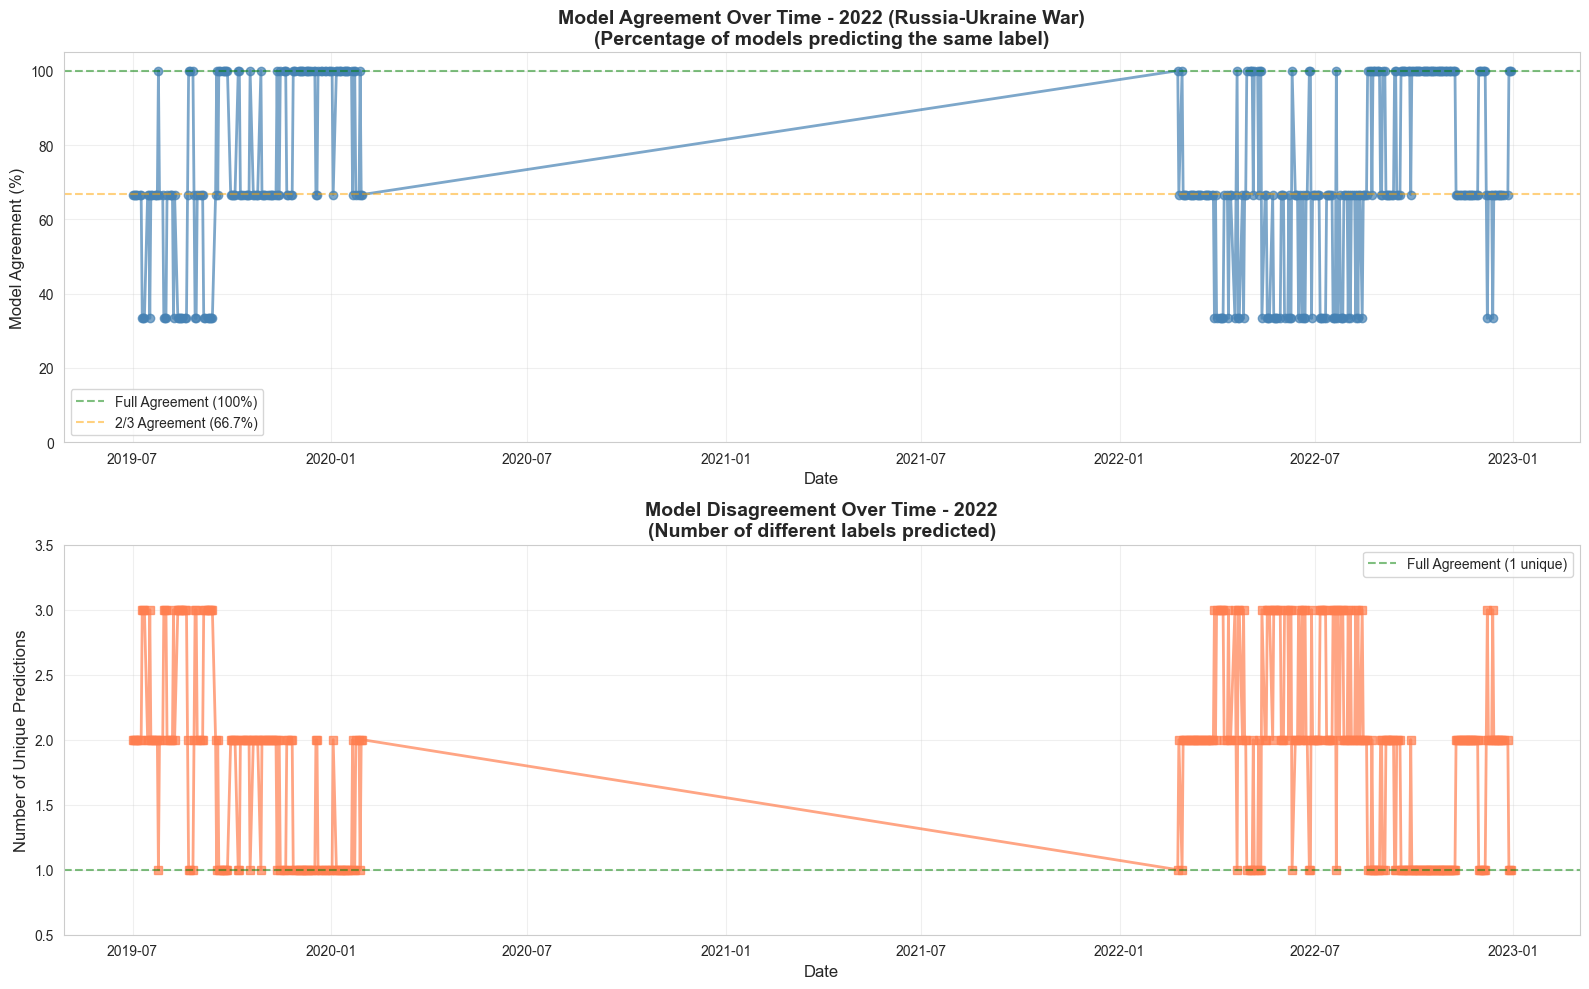

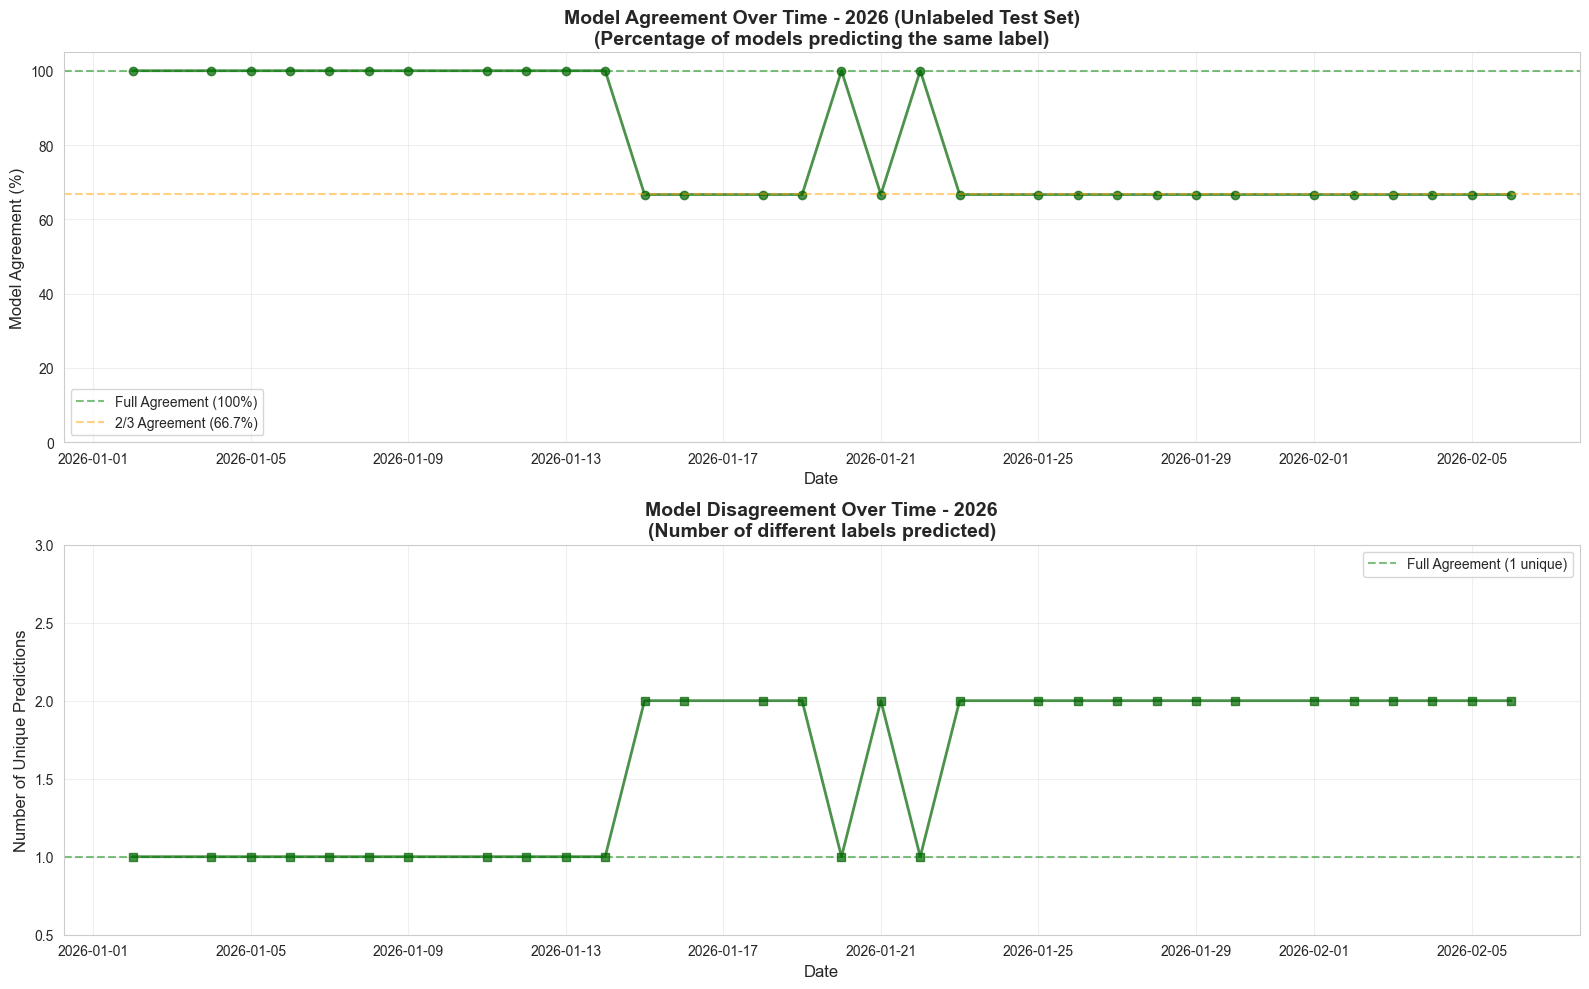


────────────────────────────────────────────────────────────────────────────────
FEATURE CONTRIBUTION TO MAHALANOBIS DISTANCE
────────────────────────────────────────────────────────────────────────────────

Analyzing top 5 most anomalous days:

  2022-03-07 (Russia-Ukraine War (2022)) (Mahal Distance: 36.48):
    - WTI_price_vol_24h_zscore_global: value=11.57, deviation=11.84
    - BRENT_abs_change_zscore_global: value=11.85, deviation=12.12
    - WTI_abs_change_zscore_global: value=10.71, deviation=10.95

  2022-03-10 (Russia-Ukraine War (2022)) (Mahal Distance: 31.23):
    - WTI_price_vol_24h_zscore_global: value=9.44, deviation=9.70
    - BRENT_abs_change_zscore_global: value=9.97, deviation=10.23
    - spread_vol_24h_zscore_global: value=7.71, deviation=8.19

  2019-09-16 (2019-Tension) (Mahal Distance: 26.28):
    - spread_vol_24h_zscore_global: value=5.17, deviation=5.64
    - BRENT_abs_change_zscore_global: value=5.90, deviation=6.16
    - WTI_abs_change_zscore_global: value=4

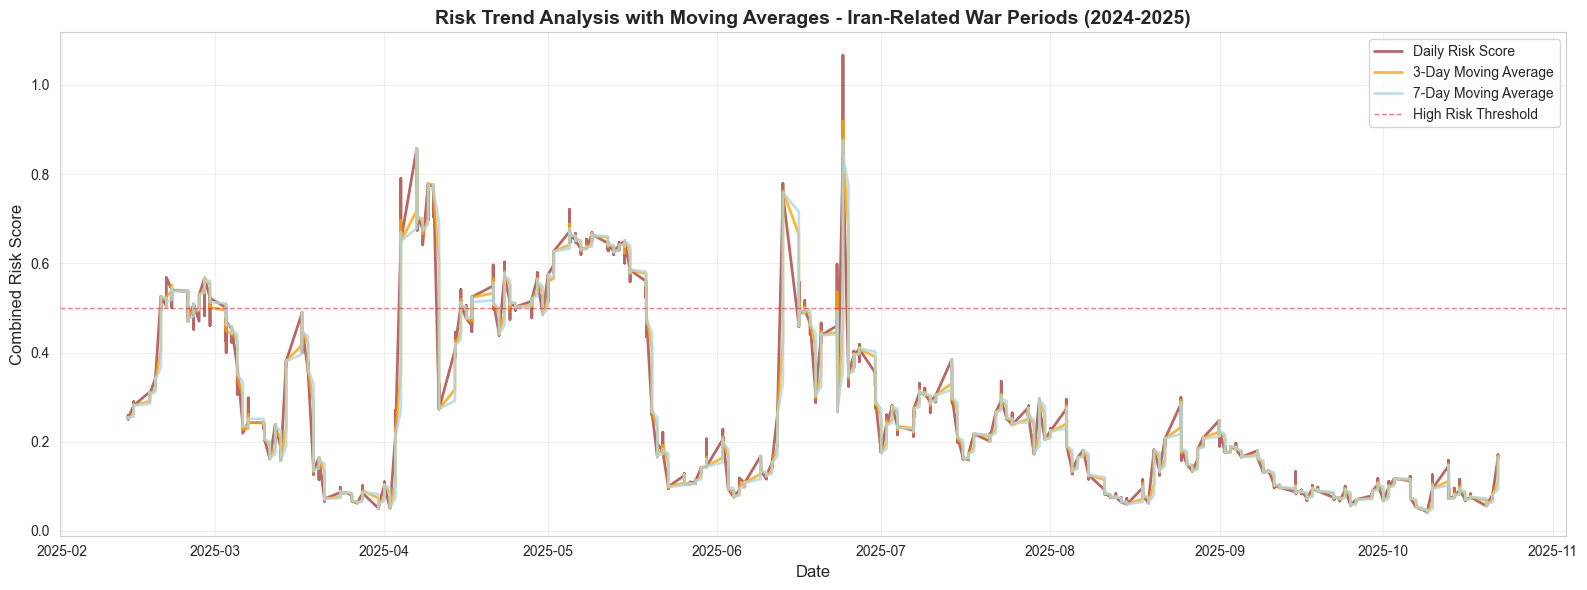


⚠️  No data found for 2026 (Unlabeled)

────────────────────────────────────────────────────────────────────────────────
CORRELATION BETWEEN RISK INDICATORS
────────────────────────────────────────────────────────────────────────────────

ADDITIONAL INSIGHTS ANALYSIS COMPLETE


In [322]:
# ============================================================================
# ADDITIONAL INSIGHTS: MODEL AGREEMENT & FEATURE CONTRIBUTION
# ============================================================================

print(f"{'='*80}")
print("ADDITIONAL INSIGHTS ANALYSIS")
print(f"{'='*80}")

# ============================================================================
# 1. MODEL AGREEMENT ANALYSIS (Test Sets Only)
# ============================================================================

print(f"\n{'─'*80}")
print("MODEL AGREEMENT ANALYSIS (Test Sets Only)")
print(f"{'─'*80}")

# Only analyze test sets (exclude training data)
test_set_names = ['test_ru_war', 'test_2019_tension', 'test_2026']  # Only test sets from all_predictions

# Combine test sets for each model
combined_model_predictions = {}
for model_name in all_predictions.keys():
    model_test_dfs = []
    for test_name in test_set_names:
        if test_name in all_predictions[model_name] and len(all_predictions[model_name][test_name]) > 0:
            model_test_dfs.append(all_predictions[model_name][test_name].copy())
    
    if len(model_test_dfs) > 0:
        combined_df = pd.concat(model_test_dfs, ignore_index=True)
        dates = pd.to_datetime(combined_df['date'])
        if dates.dt.tz is not None:
            dates = dates.dt.tz_localize(None)
        combined_df['date_normalized'] = dates.dt.normalize()
        combined_model_predictions[model_name] = combined_df.sort_values('date').reset_index(drop=True)
    else:
        combined_model_predictions[model_name] = pd.DataFrame()

# Get unique dates across all models
all_dates = set()
for model_df in combined_model_predictions.values():
    if len(model_df) > 0 and 'date_normalized' in model_df.columns:
        all_dates.update(model_df['date_normalized'].values)
all_dates = sorted(list(all_dates))

# Collect predictions for each date
agreement_data = []
for date in all_dates:
    predictions_for_date = []
    for model_name, model_df in combined_model_predictions.items():
        if len(model_df) > 0 and 'date_normalized' in model_df.columns:
            date_mask = model_df['date_normalized'] == date
            if date_mask.any():
                predictions_for_date.append(model_df.loc[date_mask, 'predicted_label'].iloc[0])
    
    if len(predictions_for_date) > 0:
        unique_preds = len(set(predictions_for_date))
        most_common = max(set(predictions_for_date), key=predictions_for_date.count)
        agreement_pct = predictions_for_date.count(most_common) / len(predictions_for_date) * 100
        
        agreement_data.append({
            'date': date,
            'num_models': len(predictions_for_date),
            'unique_predictions': unique_preds,
            'agreement_pct': agreement_pct,
            'most_common_pred': most_common
        })

agreement_df = pd.DataFrame(agreement_data)

if len(agreement_df) == 0:
    print(f"\n⚠️  Warning: No agreement data found.")
else:
    print(f"\nModel Agreement Statistics (Test Sets Only):")
    print(f"  Total days analyzed: {len(agreement_df)}")
    print(f"  Average agreement: {agreement_df['agreement_pct'].mean():.1f}%")
    print(f"  Days with 100% agreement: {(agreement_df['agreement_pct'] == 100).sum()} / {len(agreement_df)}")
    print(f"  Days with disagreement: {(agreement_df['unique_predictions'] > 1).sum()} / {len(agreement_df)}")

# Split by date for visualization
if len(agreement_df) > 0:
    agreement_dates = pd.to_datetime(agreement_df['date'])
    if agreement_dates.dt.tz is not None:
        agreement_dates = agreement_dates.dt.tz_localize(None)
    test_2026_start = pd.Timestamp('2026-01-01')
    mask_2022 = agreement_dates < test_2026_start
    mask_2026 = agreement_dates >= test_2026_start
    agreement_df_2022 = agreement_df[mask_2022].copy()
    agreement_df_2026 = agreement_df[mask_2026].copy()
    
    # Plot for 2022 (Russia-Ukraine War)
    if len(agreement_df_2022) > 0:
        fig1, axes1 = plt.subplots(2, 1, figsize=(16, 10))
        ax = axes1[0]
        ax.plot(agreement_df_2022['date'], agreement_df_2022['agreement_pct'], 
               marker='o', linewidth=2, markersize=6, color='steelblue', alpha=0.7)
        ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Full Agreement (100%)')
        ax.axhline(y=66.7, color='orange', linestyle='--', alpha=0.5, label='2/3 Agreement (66.7%)')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Model Agreement (%)', fontsize=12)
        ax.set_title('Model Agreement Over Time - 2022 (Russia-Ukraine War)\n(Percentage of models predicting the same label)', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 105])
        
        ax = axes1[1]
        ax.plot(agreement_df_2022['date'], agreement_df_2022['unique_predictions'], 
               marker='s', linewidth=2, markersize=6, color='coral', alpha=0.7)
        ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Full Agreement (1 unique)')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Number of Unique Predictions', fontsize=12)
        ax.set_title('Model Disagreement Over Time - 2022\n(Number of different labels predicted)', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5, max(3, agreement_df_2022['unique_predictions'].max() + 0.5)])
        plt.tight_layout()
        plt.show()
    
    # Plot for 2026
    if len(agreement_df_2026) > 0:
        fig_agreement_2026, axes2 = plt.subplots(2, 1, figsize=(16, 10))
        ax = axes2[0]
        ax.plot(agreement_df_2026['date'], agreement_df_2026['agreement_pct'], 
               marker='o', linewidth=2, markersize=6, color='darkgreen', alpha=0.7)
        ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Full Agreement (100%)')
        ax.axhline(y=66.7, color='orange', linestyle='--', alpha=0.5, label='2/3 Agreement (66.7%)')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Model Agreement (%)', fontsize=12)
        ax.set_title('Model Agreement Over Time - 2026 (Unlabeled Test Set)\n(Percentage of models predicting the same label)', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 105])
        
        ax = axes2[1]
        ax.plot(agreement_df_2026['date'], agreement_df_2026['unique_predictions'], 
               marker='s', linewidth=2, markersize=6, color='darkgreen', alpha=0.7)
        ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Full Agreement (1 unique)')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Number of Unique Predictions', fontsize=12)
        ax.set_title('Model Disagreement Over Time - 2026\n(Number of different labels predicted)', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5, max(3, agreement_df_2026['unique_predictions'].max() + 0.5)])
        plt.tight_layout()
        plt.show()

# ============================================================================
# 2. FEATURE CONTRIBUTION TO ANOMALIES
# ============================================================================

print(f"\n{'─'*80}")
print("FEATURE CONTRIBUTION TO MAHALANOBIS DISTANCE")
print(f"{'─'*80}")

if 'mahal_df' in locals() and len(mahal_df) > 0 and 'train_mean' in locals() and 'train_cov' in locals():
    top_anomalies = mahal_df.nlargest(5, 'mahalanobis_distance')
    print(f"\nAnalyzing top 5 most anomalous days:")
    
    for idx, row in top_anomalies.iterrows():
        date = row['date']
        test_set = row.get('test_set', 'Unknown')
        
        # Get feature values from mahal_df (should have all zscore_global_features)
        features_for_date = None
        if all(col in mahal_df.columns for col in zscore_global_features):
            date_mask = mahal_df['date'] == date
            if date_mask.any():
                features_for_date = mahal_df.loc[date_mask, zscore_global_features].iloc[0]
        
        if features_for_date is not None:
            deviations = np.abs(features_for_date.values - train_mean)
            feature_stds = np.sqrt(np.diag(train_cov))
            normalized_deviations = deviations / (feature_stds + 1e-10)
            top_indices = np.argsort(normalized_deviations)[-3:][::-1]
            
            test_set_str = f" ({test_set})" if test_set != 'Unknown' else ""
            print(f"\n  {date.strftime('%Y-%m-%d')}{test_set_str} (Mahal Distance: {row['mahalanobis_distance']:.2f}):")
            for feat_idx in top_indices:
                feat_name = zscore_global_features[feat_idx]
                feat_value = features_for_date.iloc[feat_idx]
                deviation = deviations[feat_idx]
                print(f"    - {feat_name}: value={feat_value:.2f}, deviation={deviation:.2f}")
        else:
            print(f"\n  {date.strftime('%Y-%m-%d')} (Mahal Distance: {row['mahalanobis_distance']:.2f}): Feature data not found")
else:
    print(f"\n⚠️  Mahalanobis distance data or training statistics not available")

# ============================================================================
# 3. RISK TREND ANALYSIS
# ============================================================================

print(f"\n{'─'*80}")
print("RISK TREND ANALYSIS")
print(f"{'─'*80}")

if 'combined_risk' in locals() and len(combined_risk) > 0:
    # First, check what test_set values actually exist
    if 'test_set' in combined_risk.columns:
        print(f"\nAvailable test_set values in combined_risk:")
        print(combined_risk['test_set'].value_counts())
    
    # Filter by actual test_set values that exist
    def get_period_data(combined_risk, period_name):
        """Get data for a specific period by checking actual test_set values"""
        if 'test_set' not in combined_risk.columns:
            return pd.DataFrame()
        
        # Check what test_set values contain the period name
        all_test_sets = combined_risk['test_set'].unique()
        matching_sets = [ts for ts in all_test_sets if period_name.lower() in str(ts).lower()]
        
        if len(matching_sets) > 0:
            return combined_risk[combined_risk['test_set'].isin(matching_sets)].copy()
        
        # Fallback: date-based filtering
        if 'date' in combined_risk.columns:
            dates = pd.to_datetime(combined_risk['date'])
            if dates.dt.tz is not None:
                dates = dates.dt.tz_localize(None)
            
            if '2022' in period_name or 'russia' in period_name.lower():
                mask = (dates >= pd.Timestamp('2021-10-01')) & (dates <= pd.Timestamp('2022-12-31'))
            elif 'iran' in period_name.lower() or 'training' in period_name.lower():
                mask = (dates >= pd.Timestamp('2024-01-01')) & (dates < pd.Timestamp('2026-01-01'))
            elif '2026' in period_name:
                mask = dates >= pd.Timestamp('2026-01-01')
            else:
                return pd.DataFrame()
            
            return combined_risk[mask].copy()
        
        return pd.DataFrame()
    
    # Get data for each period
    combined_risk_2022 = get_period_data(combined_risk, '2022')
    combined_risk_iran = get_period_data(combined_risk, 'iran')
    combined_risk_2026 = get_period_data(combined_risk, '2026')
    
    # Analyze and plot trends
    def analyze_risk_trend(risk_df, period_name, color):
        if len(risk_df) == 0:
            print(f"\n⚠️  No data found for {period_name}")
            return
        
        risk_sorted = risk_df.sort_values('date').copy()
        risk_sorted['risk_ma_3d'] = risk_sorted['combined_risk_score'].rolling(window=3, min_periods=1).mean()
        risk_sorted['risk_ma_7d'] = risk_sorted['combined_risk_score'].rolling(window=7, min_periods=1).mean()
        risk_sorted['risk_trend'] = risk_sorted['combined_risk_score'].diff()
        
        print(f"\nRisk Trend Statistics - {period_name}:")
        print(f"  Current risk: {risk_sorted['combined_risk_score'].iloc[-1]:.4f}")
        print(f"  3-day average: {risk_sorted['risk_ma_3d'].iloc[-1]:.4f}")
        print(f"  7-day average: {risk_sorted['risk_ma_7d'].iloc[-1]:.4f}")
        trend_val = risk_sorted['risk_trend'].tail(3).mean()
        trend_dir = '↑ Increasing' if trend_val > 0 else '↓ Decreasing'
        print(f"  Recent trend (last 3 days): {trend_val:.4f} ({trend_dir})")
        
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(risk_sorted['date'], risk_sorted['combined_risk_score'], 
               linewidth=2, color=color, alpha=0.6, label='Daily Risk Score')
        ax.plot(risk_sorted['date'], risk_sorted['risk_ma_3d'], 
               linewidth=2, color='orange', alpha=0.8, label='3-Day Moving Average')
        ax.plot(risk_sorted['date'], risk_sorted['risk_ma_7d'], 
               linewidth=2, color='lightblue', alpha=0.8, label='7-Day Moving Average')
        ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High Risk Threshold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Combined Risk Score', fontsize=12)
        ax.set_title(f'Risk Trend Analysis with Moving Averages - {period_name}', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Analyze each period
    analyze_risk_trend(combined_risk_2022, '2022 (Russia-Ukraine War)', 'darkblue')
    analyze_risk_trend(combined_risk_iran, 'Iran-Related War Periods (2024-2025)', 'darkred')
    analyze_risk_trend(combined_risk_2026, '2026 (Unlabeled)', 'darkgreen')
else:
    print(f"\n⚠️  Combined risk data not available")

# ============================================================================
# 4. CORRELATION BETWEEN RISK INDICATORS
# ============================================================================

print(f"\n{'─'*80}")
print("CORRELATION BETWEEN RISK INDICATORS")
print(f"{'─'*80}")

if 'combined_risk' in locals() and len(combined_risk) > 0:
    # Check required columns
    required_cols = ['mahalanobis_distance', 'max_pre_war_probability', 'combined_risk_score']
    if not all(col in combined_risk.columns for col in required_cols):
        print(f"\n⚠️  Missing required columns. Available columns: {list(combined_risk.columns)}")
    else:
        # Helper function to analyze correlation for a period
        def analyze_correlation(period_data, period_name):
            if len(period_data) == 0:
                print(f"\n⚠️  No {period_name} data found for correlation analysis")
                return None
            
            risk_corr_df = period_data[required_cols].copy()
            
            # Normalize Mahalanobis distance
            mahal_min = risk_corr_df['mahalanobis_distance'].min()
            mahal_max = risk_corr_df['mahalanobis_distance'].max()
            if mahal_max > mahal_min:
                risk_corr_df['mahalanobis_normalized'] = (risk_corr_df['mahalanobis_distance'] - mahal_min) / (mahal_max - mahal_min)
            else:
                risk_corr_df['mahalanobis_normalized'] = 0.0
            
            # Calculate correlation
            corr_matrix = risk_corr_df[['mahalanobis_normalized', 'max_pre_war_probability', 'combined_risk_score']].corr()
            
            print(f"\nCorrelation Matrix - {period_name}:")
            print(corr_matrix.round(3).to_string())
            
            # Visualize
            fig, ax = plt.subplots(figsize=(10, 8))
            im = ax.imshow(corr_matrix.values, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
            ax.set_xticks(range(len(corr_matrix.columns)))
            ax.set_yticks(range(len(corr_matrix.columns)))
            ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
            ax.set_yticklabels(corr_matrix.columns)
            ax.set_title(f'Correlation Between Risk Indicators - {period_name}', fontsize=14, fontweight='bold')
            
            for i in range(len(corr_matrix.columns)):
                for j in range(len(corr_matrix.columns)):
                    text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}',
                                 ha="center", va="center", color="black", fontweight='bold')
            
            plt.colorbar(im, ax=ax, label='Correlation Coefficient')
            plt.tight_layout()
            plt.show()
            
            # Interpretation
            mahal_prewar_corr = corr_matrix.loc['mahalanobis_normalized', 'max_pre_war_probability']
            corr_type = 'Positive' if mahal_prewar_corr > 0 else 'Negative'
            interpretation = 'Anomalies tend to coincide with pre-war predictions' if mahal_prewar_corr > 0 else 'Anomalies and pre-war predictions are independent/opposite'
            print(f"\nInterpretation - {period_name}:")
            print(f"  - Mahalanobis (normalized) vs Pre-War Risk: {mahal_prewar_corr:.3f}")
            print(f"    ({corr_type} correlation: {interpretation})")
            
            return corr_matrix
        
        # Analyze correlations for each period
        if len(combined_risk_2022) > 0:
            analyze_correlation(combined_risk_2022, '2022 (Russia-Ukraine War)')
        if len(combined_risk_2026) > 0:
            analyze_correlation(combined_risk_2026, '2026 (Unlabeled)')
else:
    print(f"\n⚠️  Combined risk data not available")

print(f"\n{'='*80}")
print("ADDITIONAL INSIGHTS ANALYSIS COMPLETE")
print(f"{'='*80}")


2026 UNLABELED DATA - COMPREHENSIVE RISK ASSESSMENT

────────────────────────────────────────────────────────────────────────────────
2026 DATA SUMMARY
────────────────────────────────────────────────────────────────────────────────

Total days: 31
Date range: 2026-01-02 00:00:00 to 2026-02-06 00:00:00
Unique dates: 31

────────────────────────────────────────────────────────────────────────────────
PREDICTED LABELS BY MODEL
────────────────────────────────────────────────────────────────────────────────

Random Forest:
  Normal-Tense: 18 days (58.1%)
  Post-War Close: 0 days (0.0%)
  Post-War Late: 13 days (41.9%)
  Pre-War Close: 0 days (0.0%)
  Pre-War Early: 0 days (0.0%)
  War: 0 days (0.0%)

Logistic Regression:
  Normal-Tense: 19 days (61.3%)
  Post-War Close: 0 days (0.0%)
  Post-War Late: 12 days (38.7%)
  Pre-War Close: 0 days (0.0%)
  Pre-War Early: 0 days (0.0%)
  War: 0 days (0.0%)

SVM (RBF):
  Normal-Tense: 30 days (96.8%)
  Post-War Close: 0 days (0.0%)
  Post-War Late:

  💾 Saved: images/2026_predicted_labels_timeline.png


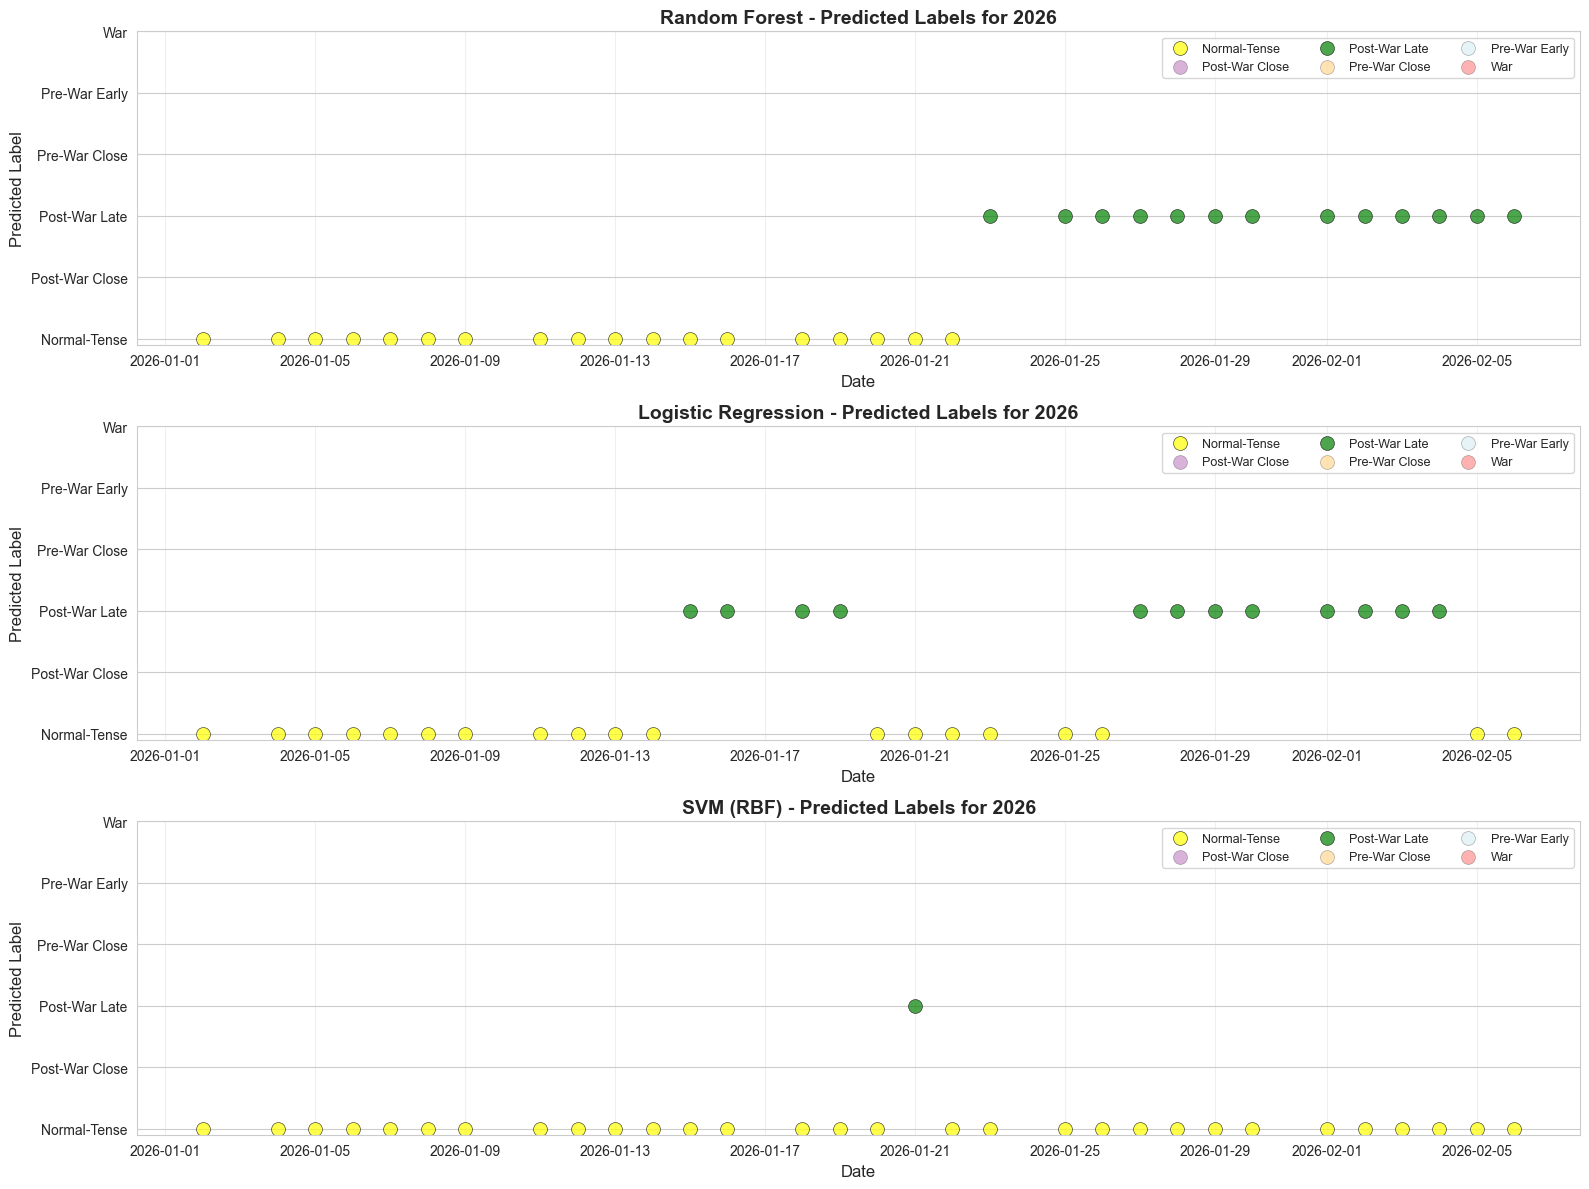

  💾 Saved: images/2026_prewar_war_probabilities.png


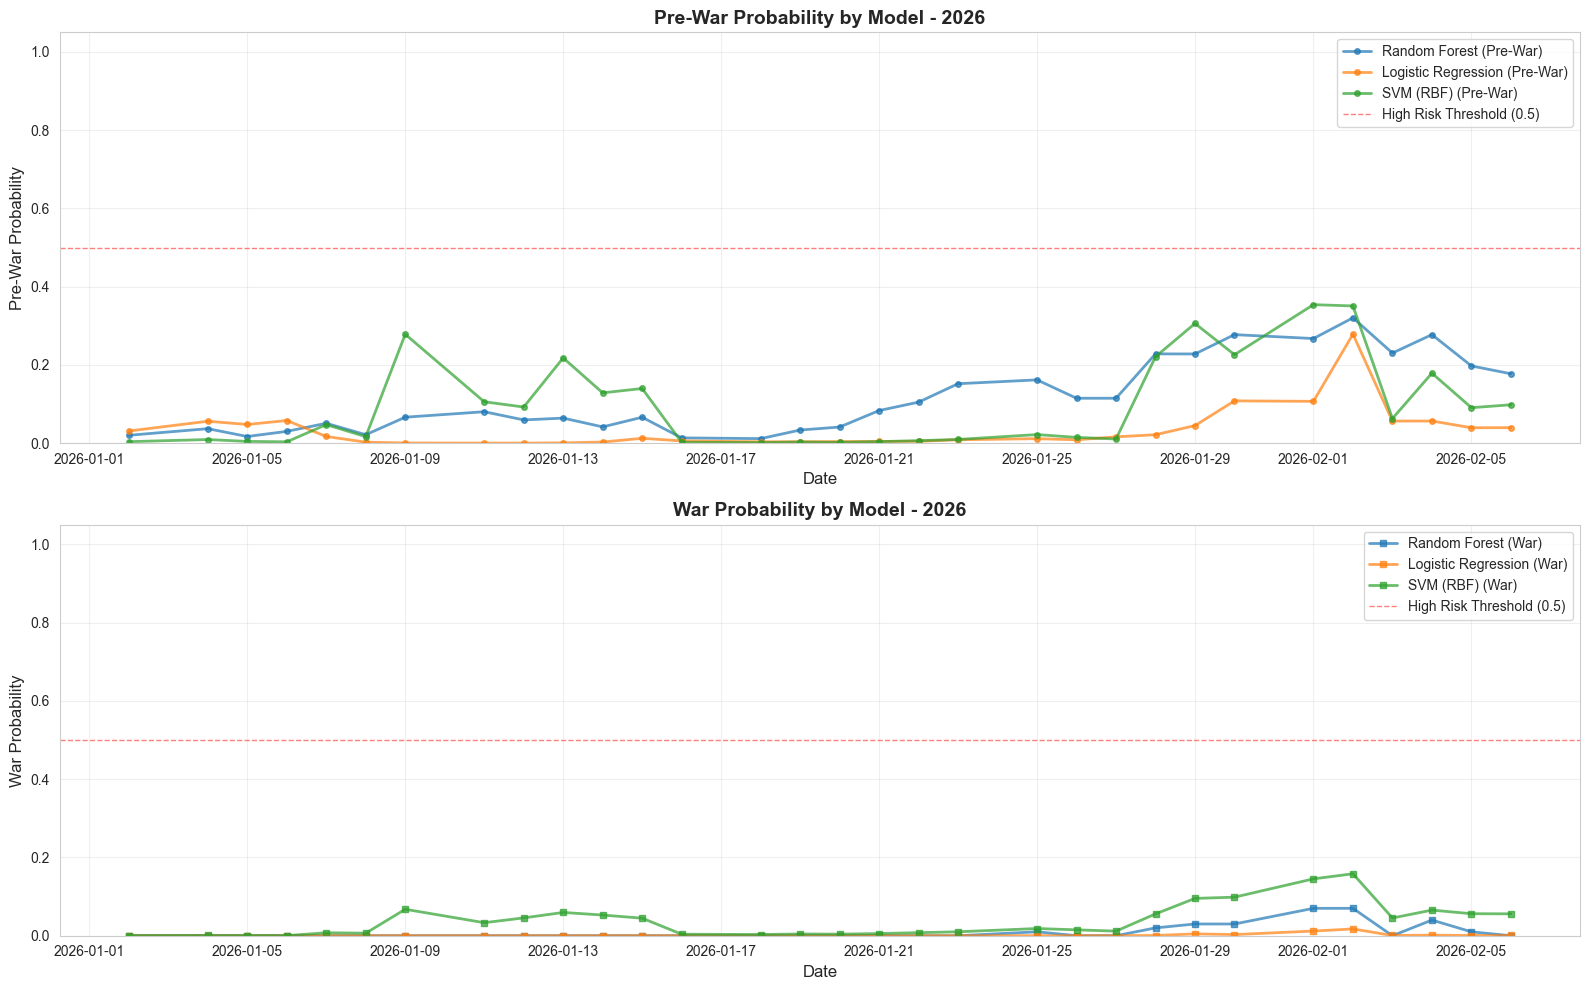

  💾 Saved: images/2026_individual_label_probabilities.png


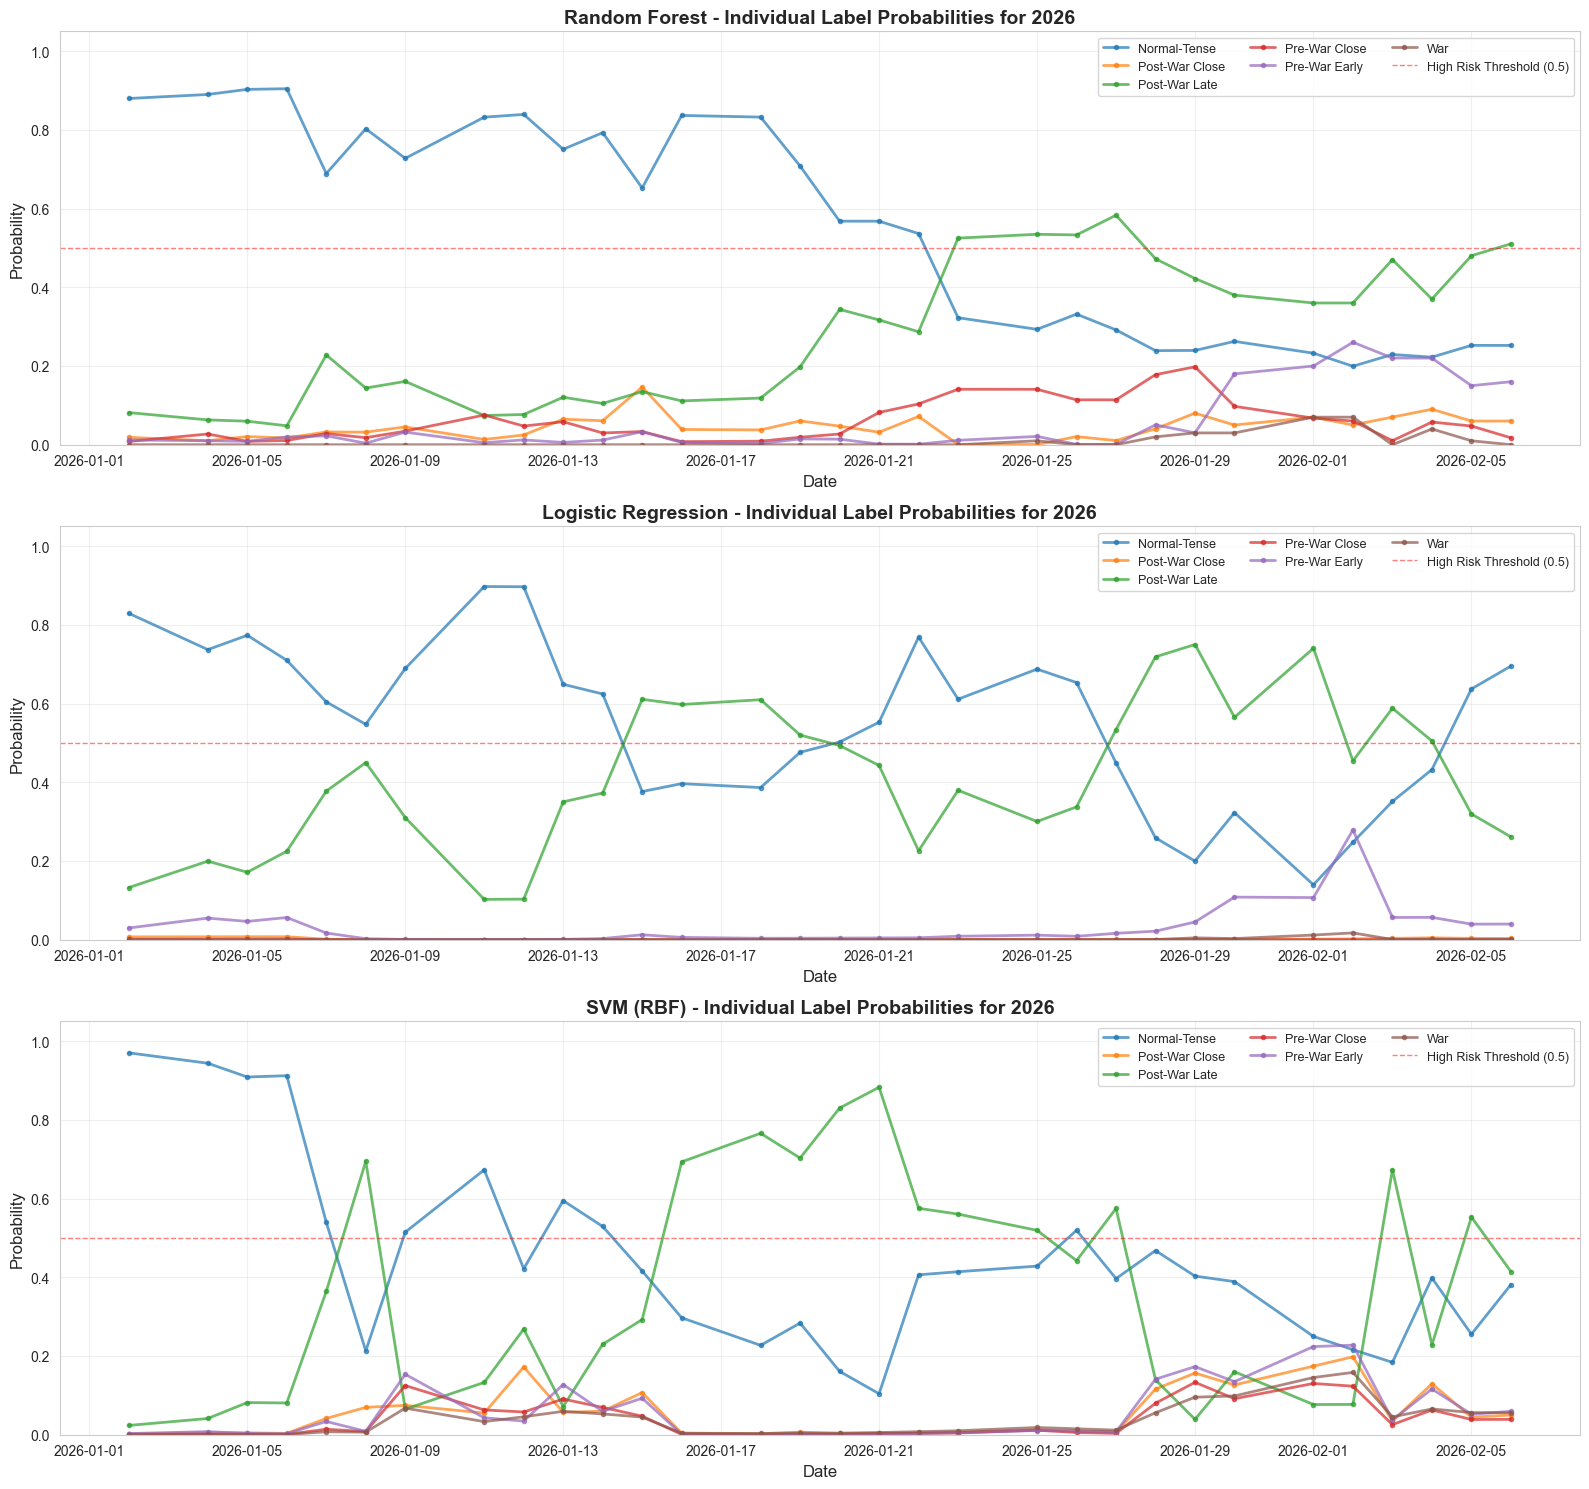

  💾 Saved: images/2026_risk_indicators_combined.png


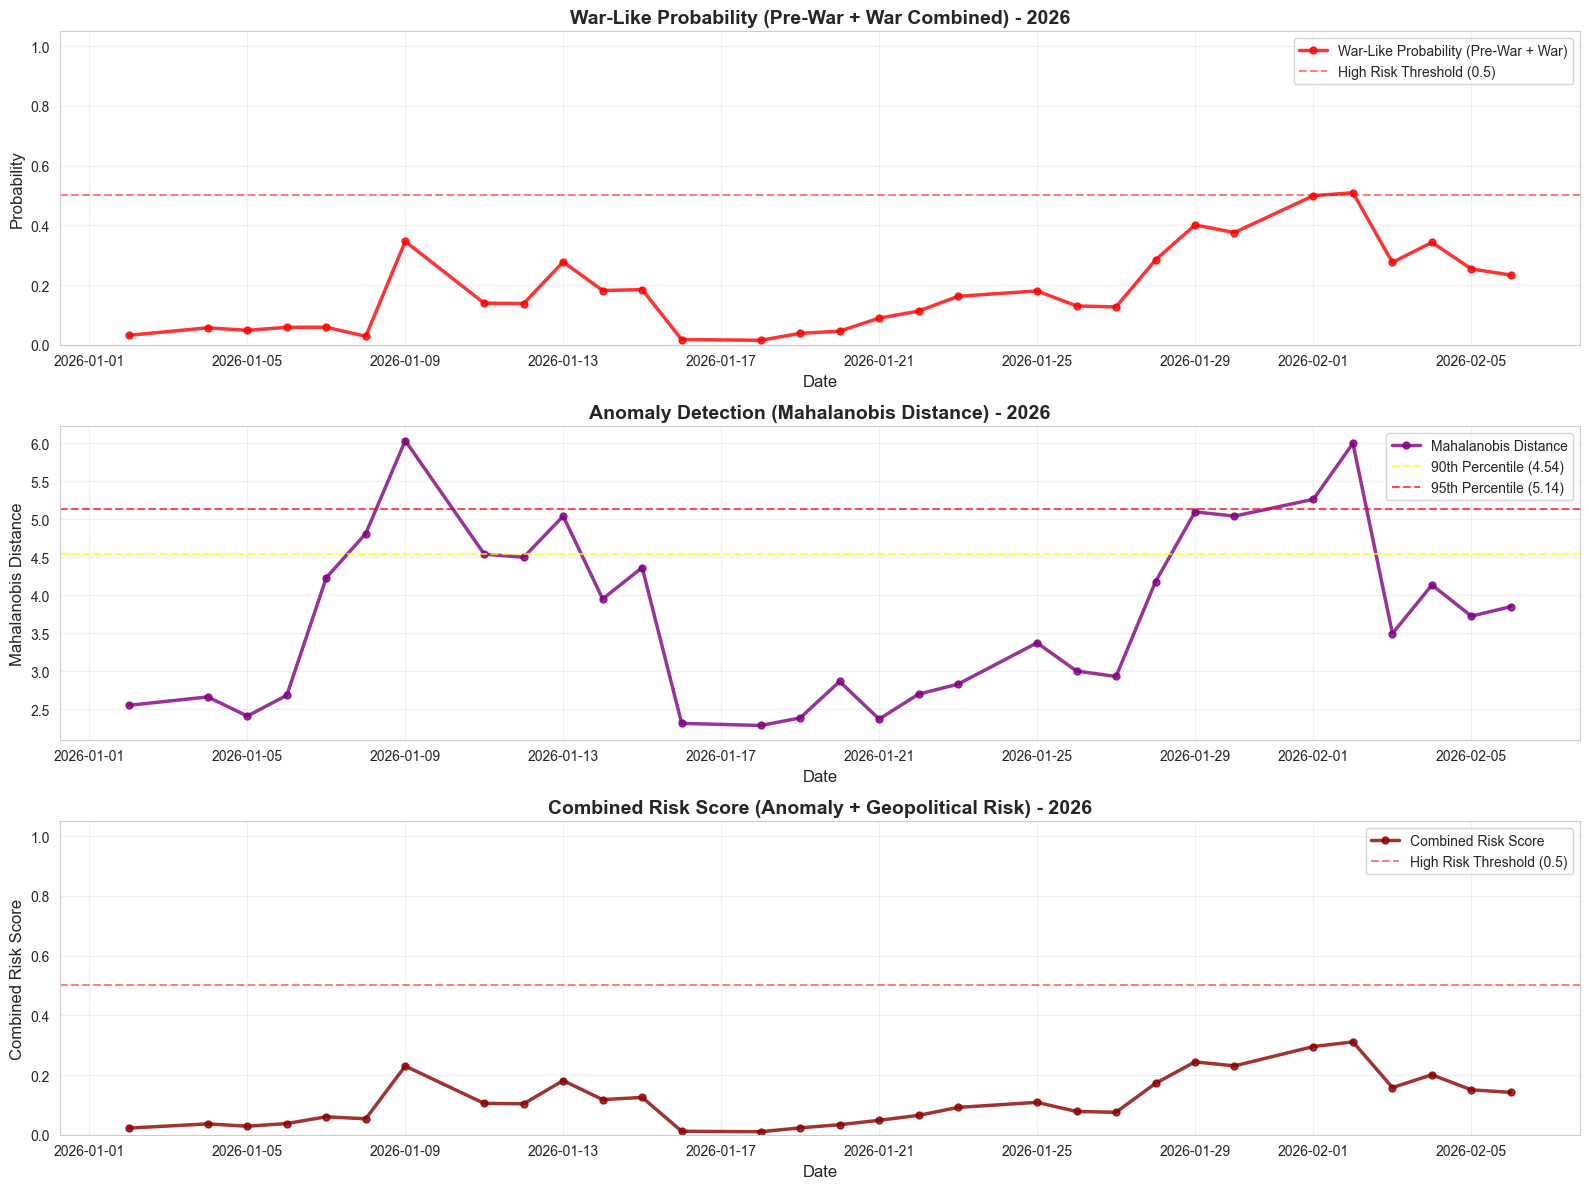


────────────────────────────────────────────────────────────────────────────────
DAILY DETAILED SUMMARY
────────────────────────────────────────────────────────────────────────────────

First 15 days of 2026:
      date most_common_label  max_pre_war_prob  max_war_prob  war_like_prob  mahalanobis_distance  combined_risk_score
2026-01-02      Normal-Tense          0.031200      0.000332       0.031532              2.550451             0.022143
2026-01-04      Normal-Tense          0.056189      0.000605       0.056794              2.660875             0.036380
2026-01-05      Normal-Tense          0.047866      0.000372       0.048238              2.409286             0.028442
2026-01-06      Normal-Tense          0.058056      0.000337       0.058393              2.681872             0.037485
2026-01-07      Normal-Tense          0.050959      0.007577       0.058536              4.229173             0.060068
2026-01-08      Normal-Tense          0.021736      0.006503       0.028239 

In [323]:
# ============================================================================
# 2026 UNLABELED DATA: COMPREHENSIVE RISK ASSESSMENT
# ============================================================================

print(f"{'='*80}")
print("2026 UNLABELED DATA - COMPREHENSIVE RISK ASSESSMENT")
print(f"{'='*80}")

# Get 2026 predictions from all models
if 'all_predictions' in locals() and 'test_2026' in all_predictions.get(list(all_predictions.keys())[0], {}):
    # Collect all 2026 predictions
    predictions_2026 = {}
    for model_name in all_predictions.keys():
        if 'test_2026' in all_predictions[model_name] and len(all_predictions[model_name]['test_2026']) > 0:
            predictions_2026[model_name] = all_predictions[model_name]['test_2026'].copy()
    
    if len(predictions_2026) > 0:
        # Get dates from first model (all should have same dates)
        first_model = list(predictions_2026.keys())[0]
        dates_2026 = predictions_2026[first_model]['date'].copy()
        dates_2026 = pd.to_datetime(dates_2026)
        if dates_2026.dt.tz is not None:
            dates_2026 = dates_2026.dt.tz_localize(None)
        dates_2026 = dates_2026.dt.normalize()
        
        # Remove duplicates and sort - this ensures unique dates
        dates_2026 = dates_2026.drop_duplicates().sort_values().reset_index(drop=True)
        
        # Create summary DataFrame with unique dates
        summary_2026 = pd.DataFrame({'date': dates_2026})
        
        # Add predicted labels from each model
        for model_name, pred_df in predictions_2026.items():
            pred_df_dates = pd.to_datetime(pred_df['date'])
            if pred_df_dates.dt.tz is not None:
                pred_df_dates = pred_df_dates.dt.tz_localize(None)
            pred_df_dates = pred_df_dates.dt.normalize()
            
            # Remove duplicates from source data before merging
            pred_df_normalized = pred_df.copy()
            pred_df_normalized['date_normalized'] = pred_df_dates
            # Keep only first occurrence of each date
            pred_df_normalized = pred_df_normalized.drop_duplicates(subset=['date_normalized'], keep='first')
            
            summary_2026['date_normalized'] = summary_2026['date']
            
            summary_2026 = summary_2026.merge(
                pred_df_normalized[['date_normalized', 'predicted_label']],
                on='date_normalized',
                how='left',
                suffixes=('', f'_{model_name}')
            )
            summary_2026[f'predicted_label_{model_name}'] = summary_2026['predicted_label']
            summary_2026 = summary_2026.drop(columns=['predicted_label'])
        
        # Add pre-war and war probabilities from each model, plus all individual probability columns
        for model_name, pred_df in predictions_2026.items():
            pred_df_dates = pd.to_datetime(pred_df['date'])
            if pred_df_dates.dt.tz is not None:
                pred_df_dates = pred_df_dates.dt.tz_localize(None)
            pred_df_dates = pred_df_dates.dt.normalize()
            
            pred_df_normalized = pred_df.copy()
            pred_df_normalized['date_normalized'] = pred_df_dates
            # Remove duplicates
            pred_df_normalized = pred_df_normalized.drop_duplicates(subset=['date_normalized'], keep='first')
            
            # Calculate pre-war probability (Pre-War Early + Pre-War Close)
            if 'prob_Pre-War Early' in pred_df_normalized.columns and 'prob_Pre-War Close' in pred_df_normalized.columns:
                pred_df_normalized['pre_war_prob'] = pred_df_normalized['prob_Pre-War Early'] + pred_df_normalized['prob_Pre-War Close']
            else:
                pred_df_normalized['pre_war_prob'] = 0.0
            
            # Get war probability
            if 'prob_War' in pred_df_normalized.columns:
                pred_df_normalized['war_prob'] = pred_df_normalized['prob_War']
            else:
                pred_df_normalized['war_prob'] = 0.0
            
            # Get all probability columns (prob_*)
            prob_cols = [col for col in pred_df_normalized.columns if col.startswith('prob_')]
            
            # Create columns to merge (excluding pre_war_prob and war_prob which we'll handle separately)
            prob_cols_to_merge = [col for col in prob_cols if col not in ['pre_war_prob', 'war_prob']]
            merge_cols = ['date_normalized', 'pre_war_prob', 'war_prob'] + prob_cols_to_merge
            
            # Merge
            summary_2026 = summary_2026.merge(
                pred_df_normalized[merge_cols],
                on='date_normalized',
                how='left',
                suffixes=('', f'_{model_name}')
            )
            
            # Rename columns with model suffix
            summary_2026[f'pre_war_prob_{model_name}'] = summary_2026['pre_war_prob']
            summary_2026[f'war_prob_{model_name}'] = summary_2026['war_prob']
            
            # Rename probability columns with model suffix
            for prob_col in prob_cols_to_merge:
                if prob_col in summary_2026.columns:
                    summary_2026[f'{prob_col}_{model_name}'] = summary_2026[prob_col]
                    summary_2026 = summary_2026.drop(columns=[prob_col])
            
            # Drop temporary columns
            if 'pre_war_prob' in summary_2026.columns:
                summary_2026 = summary_2026.drop(columns=['pre_war_prob'])
            if 'war_prob' in summary_2026.columns:
                summary_2026 = summary_2026.drop(columns=['war_prob'])
        
        # Calculate max pre-war and war probabilities across all models
        pre_war_cols = [col for col in summary_2026.columns if col.startswith('pre_war_prob_')]
        war_cols = [col for col in summary_2026.columns if col.startswith('war_prob_')]
        
        if len(pre_war_cols) > 0:
            summary_2026['max_pre_war_prob'] = summary_2026[pre_war_cols].max(axis=1)
        else:
            summary_2026['max_pre_war_prob'] = 0.0
        
        if len(war_cols) > 0:
            summary_2026['max_war_prob'] = summary_2026[war_cols].max(axis=1)
        else:
            summary_2026['max_war_prob'] = 0.0
        
        # Calculate "war-like" probability: pre-war + war (capped at 1.0)
        # This combines both pre-war and war probabilities as a single risk indicator
        summary_2026['war_like_prob'] = np.minimum(
            summary_2026['max_pre_war_prob'] + summary_2026['max_war_prob'],
            1.0
        )
        
        # Get Mahalanobis distances for 2026
        if 'mahal_df' in locals() and len(mahal_df) > 0:
            mahal_2026 = mahal_df[mahal_df['test_set'] == '2026+ (Unlabeled)'].copy()
            if len(mahal_2026) > 0:
                mahal_2026_dates = pd.to_datetime(mahal_2026['date'])
                if mahal_2026_dates.dt.tz is not None:
                    mahal_2026_dates = mahal_2026_dates.dt.tz_localize(None)
                mahal_2026_dates = mahal_2026_dates.dt.normalize()
                mahal_2026['date_normalized'] = mahal_2026_dates
                # Remove duplicates
                mahal_2026 = mahal_2026.drop_duplicates(subset=['date_normalized'], keep='first')
                
                summary_2026 = summary_2026.merge(
                    mahal_2026[['date_normalized', 'mahalanobis_distance']],
                    on='date_normalized',
                    how='left'
                )
            else:
                summary_2026['mahalanobis_distance'] = np.nan
        else:
            summary_2026['mahalanobis_distance'] = np.nan
        
        # Calculate combined risk score directly in this cell
        # This ensures it properly reflects peaks when both anomaly and probabilities are high
        if 'mahalanobis_distance' in summary_2026.columns and summary_2026['mahalanobis_distance'].notna().any():
            # Normalize Mahalanobis distance (0-1 scale)
            # Use min/max from all available Mahalanobis data if possible, otherwise use 2026 data
            if 'mahal_df' in locals() and len(mahal_df) > 0:
                mahal_all = mahal_df['mahalanobis_distance'].dropna()
                if len(mahal_all) > 0:
                    mahal_min = mahal_all.min()
                    mahal_max = mahal_all.max()
                else:
                    mahal_min = summary_2026['mahalanobis_distance'].min()
                    mahal_max = summary_2026['mahalanobis_distance'].max()
            else:
                mahal_min = summary_2026['mahalanobis_distance'].min()
                mahal_max = summary_2026['mahalanobis_distance'].max()
            
            # Normalize Mahalanobis distance to 0-1 scale
            summary_2026['mahalanobis_normalized'] = (
                (summary_2026['mahalanobis_distance'] - mahal_min) / (mahal_max - mahal_min + 1e-10)
            ).clip(0, 1)
            
            # Combined risk score: average of normalized Mahalanobis + war-like probability
            # This will show peaks when BOTH anomaly and probabilities are high
            summary_2026['combined_risk_score'] = (
                summary_2026['mahalanobis_normalized'] + summary_2026['war_like_prob']
            ) / 2
        else:
            summary_2026['mahalanobis_normalized'] = np.nan
            summary_2026['combined_risk_score'] = np.nan
        
        # Clean up and ensure no duplicates
        summary_2026 = summary_2026.drop(columns=['date_normalized'])
        summary_2026 = summary_2026.drop_duplicates(subset=['date'], keep='first')
        summary_2026 = summary_2026.sort_values('date').reset_index(drop=True)
        
        # Print summary table
        print(f"\n{'─'*80}")
        print("2026 DATA SUMMARY")
        print(f"{'─'*80}")
        print(f"\nTotal days: {len(summary_2026)}")
        print(f"Date range: {summary_2026['date'].min()} to {summary_2026['date'].max()}")
        print(f"Unique dates: {summary_2026['date'].nunique()}")
        
        # Show predictions by model
        print(f"\n{'─'*80}")
        print("PREDICTED LABELS BY MODEL")
        print(f"{'─'*80}")
        
        # Get all possible labels from label_encoder (if available) or define explicitly
        if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
            all_possible_labels = sorted(label_encoder.classes_)
        else:
            # Fallback: define all training labels explicitly
            all_possible_labels = ['Normal-Tense', 'Post-War Close', 'Post-War Late', 
                                  'Pre-War Close', 'Pre-War Early', 'War']
        
        for model_name in predictions_2026.keys():
            pred_col = f'predicted_label_{model_name}'
            if pred_col in summary_2026.columns:
                print(f"\n{model_name}:")
                # Get actual predictions
                pred_dist = summary_2026[pred_col].value_counts()
                # Show all possible labels, including those with 0 predictions
                for label in all_possible_labels:
                    count = pred_dist.get(label, 0)
                    pct = count / len(summary_2026) * 100
                    print(f"  {label}: {count} days ({pct:.1f}%)")
        
        # Create table with top predictions and probabilities for each model
        print(f"\n{'─'*80}")
        print("TOP PREDICTIONS WITH PROBABILITIES BY MODEL")
        print(f"{'─'*80}")
        
        # Get all possible labels from label_encoder
        if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
            all_labels = list(label_encoder.classes_)
        else:
            all_labels = ['Normal-Tense', 'Post-War Close', 'Post-War Late', 
                         'Pre-War Close', 'Pre-War Early', 'War']
        
        # Create a summary table for each model showing top predictions
        for model_name in predictions_2026.keys():
            print(f"\n{model_name}:")
            print(f"{'─'*80}")
            
            # Get probability columns for this model
            prob_cols_model = [col for col in summary_2026.columns 
                              if col.startswith('prob_') and col.endswith(f'_{model_name}')]
            
            if len(prob_cols_model) > 0:
                # Create a table showing top predictions for each day
                top_preds_list = []
                
                for idx, row in summary_2026.iterrows():
                    date_str = row['date'].strftime('%Y-%m-%d') if pd.notna(row['date']) else 'N/A'
                    pred_col = f'predicted_label_{model_name}'
                    predicted_label = row[pred_col] if pd.notna(row.get(pred_col)) else 'N/A'
                    
                    # Get probabilities for all labels
                    probs = {}
                    for label in all_labels:
                        prob_col = f'prob_{label}_{model_name}'
                        if prob_col in summary_2026.columns:
                            probs[label] = row[prob_col] if pd.notna(row.get(prob_col)) else 0.0
                        else:
                            probs[label] = 0.0
                    
                    # Sort by probability (descending)
                    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
                    
                    # Get top 3 predictions
                    top_preds_list.append({
                        'Date': date_str,
                        'Predicted': predicted_label,
                        'Top1_Label': sorted_probs[0][0] if len(sorted_probs) > 0 else 'N/A',
                        'Top1_Prob': f"{sorted_probs[0][1]:.3f}" if len(sorted_probs) > 0 else '0.000',
                        'Top2_Label': sorted_probs[1][0] if len(sorted_probs) > 1 else 'N/A',
                        'Top2_Prob': f"{sorted_probs[1][1]:.3f}" if len(sorted_probs) > 1 else '0.000',
                        'Top3_Label': sorted_probs[2][0] if len(sorted_probs) > 2 else 'N/A',
                        'Top3_Prob': f"{sorted_probs[2][1]:.3f}" if len(sorted_probs) > 2 else '0.000',
                    })
                
                top_preds_df = pd.DataFrame(top_preds_list)
                
                # Display table (show first 15 and last 5 rows if more than 20)
                if len(top_preds_df) <= 20:
                    print(top_preds_df.to_string(index=False))
                else:
                    print("First 15 days:")
                    print(top_preds_df.head(15).to_string(index=False))
                    print(f"\n... ({len(top_preds_df) - 20} days omitted) ...\n")
                    print("Last 5 days:")
                    print(top_preds_df.tail(5).to_string(index=False))
                
                # Summary statistics
                print(f"\nSummary Statistics:")
                print(f"  Days where predicted label matches top probability: "
                      f"{(top_preds_df['Predicted'] == top_preds_df['Top1_Label']).sum()} / {len(top_preds_df)}")
                print(f"  Average top probability: {top_preds_df['Top1_Prob'].astype(float).mean():.3f}")
                print(f"  Min top probability: {top_preds_df['Top1_Prob'].astype(float).min():.3f}")
                print(f"  Max top probability: {top_preds_df['Top1_Prob'].astype(float).max():.3f}")
            else:
                print(f"  ⚠️  Probability columns not found for {model_name}")
        
        # Show risk probabilities
        print(f"\n{'─'*80}")
        print("RISK PROBABILITIES")
        print(f"{'─'*80}")
        print(f"\nMax Pre-War Probability (across all models):")
        print(f"  Mean: {summary_2026['max_pre_war_prob'].mean():.4f}")
        print(f"  Max: {summary_2026['max_pre_war_prob'].max():.4f}")
        print(f"  Days > 0.5: {(summary_2026['max_pre_war_prob'] > 0.5).sum()} / {len(summary_2026)}")
        
        print(f"\nMax War Probability (across all models):")
        print(f"  Mean: {summary_2026['max_war_prob'].mean():.4f}")
        print(f"  Max: {summary_2026['max_war_prob'].max():.4f}")
        print(f"  Days > 0.5: {(summary_2026['max_war_prob'] > 0.5).sum()} / {len(summary_2026)}")
        
        print(f"\nWar-Like Probability (Pre-War + War, capped at 1.0):")
        print(f"  Mean: {summary_2026['war_like_prob'].mean():.4f}")
        print(f"  Max: {summary_2026['war_like_prob'].max():.4f}")
        print(f"  Days > 0.5: {(summary_2026['war_like_prob'] > 0.5).sum()} / {len(summary_2026)}")
        
        # Show Mahalanobis distances
        if 'mahalanobis_distance' in summary_2026.columns and summary_2026['mahalanobis_distance'].notna().any():
            print(f"\n{'─'*80}")
            print("MAHALANOBIS DISTANCE (Anomaly Detection)")
            print(f"{'─'*80}")
            mahal_valid = summary_2026['mahalanobis_distance'].dropna()
            if len(mahal_valid) > 0:
                print(f"  Mean: {mahal_valid.mean():.4f}")
                print(f"  Max: {mahal_valid.max():.4f}")
                if 'threshold_90' in locals() and not np.isnan(threshold_90):
                    above_90 = (summary_2026['mahalanobis_distance'] > threshold_90).sum()
                    above_95 = (summary_2026['mahalanobis_distance'] > threshold_95).sum()
                    print(f"  Days > 90th percentile ({threshold_90:.2f}): {above_90} / {len(summary_2026)}")
                    print(f"  Days > 95th percentile ({threshold_95:.2f}): {above_95} / {len(summary_2026)}")
        
        # Show combined risk
        if 'combined_risk_score' in summary_2026.columns and summary_2026['combined_risk_score'].notna().any():
            print(f"\n{'─'*80}")
            print("COMBINED RISK SCORE")
            print(f"{'─'*80}")
            risk_valid = summary_2026['combined_risk_score'].dropna()
            if len(risk_valid) > 0:
                print(f"  Mean: {risk_valid.mean():.4f}")
                print(f"  Max: {risk_valid.max():.4f}")
                print(f"  Days > 0.5: {(summary_2026['combined_risk_score'] > 0.5).sum()} / {len(summary_2026)}")
        
        # ============================================================================
        # VISUALIZATIONS
        # ============================================================================
        
        # Plot 1: Predicted Labels by Model (Stacked Bar or Timeline)
        fig1, axes1 = plt.subplots(len(predictions_2026), 1, figsize=(16, 4*len(predictions_2026)))
        if len(predictions_2026) == 1:
            axes1 = [axes1]
        
        label_colors_map = {
            'Normal-Tense': 'yellow',
            'Pre-War Early': 'lightblue',
            'Pre-War Close': 'orange',
            'War': 'red',
            'Post-War Close': 'purple',
            'Post-War Late': 'green'
        }
        
        # Get all possible labels
        if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
            all_possible_labels = list(label_encoder.classes_)
        else:
            all_possible_labels = ['Normal-Tense', 'Post-War Close', 'Post-War Late', 
                                  'Pre-War Close', 'Pre-War Early', 'War']
        
        for idx, model_name in enumerate(predictions_2026.keys()):
            ax = axes1[idx]
            pred_col = f'predicted_label_{model_name}'
            
            if pred_col in summary_2026.columns:
                # Create timeline plot - show ALL possible labels, not just predicted ones
                y_pos = 0
                for label in all_possible_labels:
                    mask = (summary_2026[pred_col] == label) & (summary_2026[pred_col].notna())
                    dates_for_label = summary_2026[mask]['date']
                    
                    # Always show label in legend, even if no predictions
                    if len(dates_for_label) > 0:
                        ax.scatter(dates_for_label, [y_pos]*len(dates_for_label),
                                 c=label_colors_map.get(label, 'gray'),
                                 label=label, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
                    else:
                        # Show label in legend even if no data points (for completeness)
                        ax.scatter([], [], c=label_colors_map.get(label, 'gray'),
                                 label=label, alpha=0.3, s=100, edgecolors='black', linewidth=0.5)
                    
                    y_pos += 1
                
                ax.set_xlabel('Date', fontsize=12)
                ax.set_ylabel('Predicted Label', fontsize=12)
                ax.set_title(f'{model_name} - Predicted Labels for 2026', fontsize=14, fontweight='bold')
                ax.legend(loc='best', fontsize=9, ncol=3)
                ax.grid(True, alpha=0.3, axis='x')
                # Set yticks to show all labels
                ax.set_yticks(range(len(all_possible_labels)))
                ax.set_yticklabels(all_possible_labels)
        
        plt.tight_layout()
        save_figure(fig1, filename='2026_predicted_labels_timeline')
        plt.show()
        
        # Plot 2: Pre-War and War Probabilities by Model
        fig2, axes2 = plt.subplots(2, 1, figsize=(16, 10))
        
        # Pre-War Probabilities
        ax = axes2[0]
        for model_name in predictions_2026.keys():
            pre_war_col = f'pre_war_prob_{model_name}'
            if pre_war_col in summary_2026.columns:
                ax.plot(summary_2026['date'], summary_2026[pre_war_col],
                       label=f'{model_name} (Pre-War)', linewidth=2, alpha=0.7, marker='o', markersize=4)
        ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High Risk Threshold (0.5)')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Pre-War Probability', fontsize=12)
        ax.set_title('Pre-War Probability by Model - 2026', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        # War Probabilities
        ax = axes2[1]
        for model_name in predictions_2026.keys():
            war_col = f'war_prob_{model_name}'
            if war_col in summary_2026.columns:
                ax.plot(summary_2026['date'], summary_2026[war_col],
                       label=f'{model_name} (War)', linewidth=2, alpha=0.7, marker='s', markersize=4)
        ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High Risk Threshold (0.5)')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('War Probability', fontsize=12)
        ax.set_title('War Probability by Model - 2026', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        plt.tight_layout()
        save_figure(fig2, filename='2026_prewar_war_probabilities')
        plt.show()
        
        # Plot 2.5: Individual Label Probabilities by Model
        # Get all possible labels
        if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
            all_labels = list(label_encoder.classes_)
        else:
            all_labels = ['Normal-Tense', 'Post-War Close', 'Post-War Late', 
                         'Pre-War Close', 'Pre-War Early', 'War']
        
        # Create subplots for each model
        n_models = len(predictions_2026)
        fig2_5, axes2_5 = plt.subplots(n_models, 1, figsize=(16, 5*n_models))
        if n_models == 1:
            axes2_5 = [axes2_5]
        
        for idx, model_name in enumerate(predictions_2026.keys()):
            ax = axes2_5[idx]
            
            # Plot probability for each label
            for label in all_labels:
                prob_col = f'prob_{label}_{model_name}'
                if prob_col in summary_2026.columns:
                    ax.plot(summary_2026['date'], summary_2026[prob_col],
                           label=label, linewidth=2, alpha=0.7, marker='o', markersize=3)
            
            ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='High Risk Threshold (0.5)')
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Probability', fontsize=12)
            ax.set_title(f'{model_name} - Individual Label Probabilities for 2026', fontsize=14, fontweight='bold')
            ax.legend(loc='best', fontsize=9, ncol=3)
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0, 1.05])
        
        plt.tight_layout()
        save_figure(fig2_5, filename='2026_individual_label_probabilities')
        plt.show()
        
        # Plot 3: War-Like Probability + Mahalanobis + Combined Risk
        fig3, axes3 = plt.subplots(3, 1, figsize=(16, 12))
        
        # War-Like Probability (Pre-War + War combined)
        ax = axes3[0]
        ax.plot(summary_2026['date'], summary_2026['war_like_prob'],
               label='War-Like Probability (Pre-War + War)', linewidth=2.5, color='red', alpha=0.8, marker='o', markersize=5)
        ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='High Risk Threshold (0.5)')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Probability', fontsize=12)
        ax.set_title('War-Like Probability (Pre-War + War Combined) - 2026', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        # Mahalanobis Distance
        ax = axes3[1]
        if 'mahalanobis_distance' in summary_2026.columns and summary_2026['mahalanobis_distance'].notna().any():
            ax.plot(summary_2026['date'], summary_2026['mahalanobis_distance'],
                   label='Mahalanobis Distance', linewidth=2.5, color='purple', alpha=0.8, marker='o', markersize=5)
            if 'threshold_90' in locals() and not np.isnan(threshold_90):
                ax.axhline(y=threshold_90, color='yellow', linestyle='--', linewidth=1.5, alpha=0.7, label=f'90th Percentile ({threshold_90:.2f})')
            if 'threshold_95' in locals() and not np.isnan(threshold_95):
                ax.axhline(y=threshold_95, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'95th Percentile ({threshold_95:.2f})')
        else:
            ax.text(0.5, 0.5, 'Mahalanobis distance data not available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Mahalanobis Distance', fontsize=12)
        ax.set_title('Anomaly Detection (Mahalanobis Distance) - 2026', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Combined Risk Score
        ax = axes3[2]
        if 'combined_risk_score' in summary_2026.columns and summary_2026['combined_risk_score'].notna().any():
            ax.plot(summary_2026['date'], summary_2026['combined_risk_score'],
                   label='Combined Risk Score', linewidth=2.5, color='darkred', alpha=0.8, marker='o', markersize=5)
            ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='High Risk Threshold (0.5)')
        else:
            ax.text(0.5, 0.5, 'Combined risk score data not available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Combined Risk Score', fontsize=12)
        ax.set_title('Combined Risk Score (Anomaly + Geopolitical Risk) - 2026', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        plt.tight_layout()
        save_figure(fig3, filename='2026_risk_indicators_combined')
        plt.show()
        
        # Plot 4: Daily Summary Table Visualization
        print(f"\n{'─'*80}")
        print("DAILY DETAILED SUMMARY")
        print(f"{'─'*80}")
        
        # Create a readable daily summary
        daily_summary = summary_2026[['date']].copy()
        
        # Add most common predicted label (agreement)
        pred_label_cols = [col for col in summary_2026.columns if col.startswith('predicted_label_')]
        if len(pred_label_cols) > 0:
            def get_most_common_label(row):
                labels = [row[col] for col in pred_label_cols if pd.notna(row[col])]
                if len(labels) > 0:
                    return max(set(labels), key=labels.count)
                return np.nan
            daily_summary['most_common_label'] = summary_2026.apply(get_most_common_label, axis=1)
        
        # Add max probabilities
        daily_summary['max_pre_war_prob'] = summary_2026['max_pre_war_prob']
        daily_summary['max_war_prob'] = summary_2026['max_war_prob']
        daily_summary['war_like_prob'] = summary_2026['war_like_prob']
        
        # Add Mahalanobis distance
        if 'mahalanobis_distance' in summary_2026.columns:
            daily_summary['mahalanobis_distance'] = summary_2026['mahalanobis_distance']
        
        # Add combined risk
        if 'combined_risk_score' in summary_2026.columns:
            daily_summary['combined_risk_score'] = summary_2026['combined_risk_score']
        
        # Print first 10 days
        print(f"\nFirst 15 days of 2026:")
        print(daily_summary.head(15).to_string(index=False))
        
        if len(daily_summary) > 10:
            print(f"\n... ({len(daily_summary) - 15} more days)")
            print(f"\nLast 10 days of 2026:")
            print(daily_summary.tail(10).to_string(index=False))
        
        print(f"\n{'='*80}")
        print("2026 RISK ASSESSMENT COMPLETE")
        print(f"{'='*80}")
        
    else:
        print(f"\n⚠️  No 2026 predictions found in all_predictions")
else:
    print(f"\n⚠️  all_predictions not available or test_2026 not found")

In [324]:
# ============================================================================
# CELL 1: PREPARE TRAINING PERIOD DATA FOR ANALYSIS (2024-2025)
# ============================================================================
# Extract different periods from training data and merge with price data

print(f"{'='*80}")
print("PREPARING TRAINING PERIOD DATA (2024-2025)")
print(f"{'='*80}\n")

# Initialize variables
prewar_2025_analysis = None
normal_tense_analysis = None
postwar_close_analysis = None
postwar_late_analysis = None

# Ensure Mahalanobis distance calculation function is available
if 'calculate_mahalanobis_distances' not in locals():
    def calculate_mahalanobis_distances(X_test_data, train_mean, train_cov_inv):
        """Calculate Mahalanobis distances for a test set"""
        # Remove NaN/inf values
        valid_mask = ~(np.isnan(X_test_data).any(axis=1) | np.isinf(X_test_data).any(axis=1))
        mahalanobis_distances = []
        
        for i, test_point in enumerate(X_test_data):
            if not valid_mask[i]:
                mahalanobis_distances.append(np.nan)
                continue
            
            try:
                diff = test_point - train_mean
                # Check for NaN/inf in diff
                if np.isnan(diff).any() or np.isinf(diff).any():
                    mahalanobis_distances.append(np.nan)
                    continue
                
                dist = np.sqrt(diff.T @ train_cov_inv @ diff)
                
                # Check if result is valid
                if np.isnan(dist) or np.isinf(dist):
                    mahalanobis_distances.append(np.nan)
                else:
                    mahalanobis_distances.append(dist)
            except:
                # Fallback to Euclidean distance if Mahalanobis fails
                dist = np.linalg.norm(test_point - train_mean)
                mahalanobis_distances.append(dist if not (np.isnan(dist) or np.isinf(dist)) else np.nan)
        
        return np.array(mahalanobis_distances)

# Ensure we have the required variables for Mahalanobis distance calculation
# If not available, calculate them from Normal-Tense baseline
if 'zscore_global_features' not in locals() or 'train_mean' not in locals() or 'train_cov_inv' not in locals():
    print("📊 Calculating Mahalanobis distance baseline from Normal-Tense data...")
    try:
        # Load processed data if df_train not available
        if 'df_train' not in locals() or df_train is None or len(df_train) == 0:
            df_processed_temp = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
            df_train_temp = df_processed_temp[
                (df_processed_temp['date'] >= '2024-01-01') & 
                (df_processed_temp['date'] < '2026-01-01') &
                (df_processed_temp['label'].isin(['Normal-Tense', 'Pre-War Early', 'Pre-War Close', 
                                                   'War', 'Post-War Close', 'Post-War Late']))
            ].copy()
        else:
            df_train_temp = df_train.copy()
        
        # Get global z-score features
        zscore_global_features = [col for col in df_train_temp.columns if col.endswith('_zscore_global')]
        
        if len(zscore_global_features) > 0:
            # Use only "Normal-Tense" from training set as baseline
            normal_tense_mask = df_train_temp['label'] == 'Normal-Tense'
            X_train_normal_tense = df_train_temp[normal_tense_mask][zscore_global_features].values
            
            # Remove any rows with NaN or inf values
            valid_mask = ~(np.isnan(X_train_normal_tense).any(axis=1) | np.isinf(X_train_normal_tense).any(axis=1))
            X_train_normal_tense = X_train_normal_tense[valid_mask]
            
            if len(X_train_normal_tense) > 0:
                # Calculate mean and covariance
                train_mean = np.mean(X_train_normal_tense, axis=0)
                train_cov = np.cov(X_train_normal_tense.T)
                
                # Calculate inverse covariance with regularization if needed
                try:
                    train_cov_inv = inv(train_cov)
                    if np.isnan(train_cov_inv).any() or np.isinf(train_cov_inv).any():
                        raise np.linalg.LinAlgError("Inverse contains NaN/inf")
                except (np.linalg.LinAlgError, ValueError):
                    # If matrix is singular, add regularization
                    train_cov_inv = inv(train_cov + np.eye(train_cov.shape[0]) * 1e-6)
                
                print(f"   ✅ Calculated baseline from {len(X_train_normal_tense)} Normal-Tense samples")
            else:
                print(f"   ⚠️  No valid Normal-Tense samples found for baseline")
        else:
            print(f"   ⚠️  No global z-score features found")
    except Exception as e:
        print(f"   ⚠️  Could not calculate Mahalanobis baseline: {e}")
        import traceback
        traceback.print_exc()

# Check if we have training predictions
if 'all_predictions' in locals() and len(all_predictions) > 0:
    # Get training data predictions (2024-2025 Iran-related periods)
    first_model = list(all_predictions.keys())[0]
    if 'train_iran_war' in all_predictions[first_model]:
        train_predictions = all_predictions[first_model]['train_iran_war'].copy()
        
        # Debug: Show available labels in train_predictions
        if 'label' in train_predictions.columns:
            print(f"📊 Available labels in train_predictions: {sorted(train_predictions['label'].unique())}")
            print(f"   Note: train_predictions only contains Iran war labels, not Normal-Tense\n")
        
        # Filter for 2025 pre-war periods
        train_predictions['date'] = pd.to_datetime(train_predictions['date'])
        prewar_2025 = train_predictions[
            (train_predictions['date'] >= '2025-01-01') & 
            (train_predictions['date'] < '2026-01-01') &
            (train_predictions['label'].isin(['Pre-War Early', 'Pre-War Close']))
        ].copy()
        
        if len(prewar_2025) > 0:
            print(f"✅ Found {len(prewar_2025)} days of 2025 pre-war period data")
            print(f"   Date range: {prewar_2025['date'].min()} to {prewar_2025['date'].max()}")
            label_counts = prewar_2025['label'].value_counts()
            print(f"   Labels: {label_counts.to_dict()}")
            # Verify we have the expected labels
            expected_labels = ['Pre-War Early', 'Pre-War Close']
            found_labels = set(prewar_2025['label'].unique())
            missing_labels = set(expected_labels) - found_labels
            if missing_labels:
                print(f"   ⚠️  Missing expected labels: {missing_labels}")
            print()
            
            # Load price data
            try:
                df_processed = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
                
                # Merge with price data
                prewar_2025['date_normalized'] = pd.to_datetime(prewar_2025['date'])
                if prewar_2025['date_normalized'].dt.tz is not None:
                    prewar_2025['date_normalized'] = prewar_2025['date_normalized'].dt.tz_localize(None)
                prewar_2025['date_normalized'] = prewar_2025['date_normalized'].dt.normalize()
                
                df_2025_prices = df_processed[
                    (df_processed['date'] >= '2025-01-01') & 
                    (df_processed['date'] < '2026-01-01')
                ].copy()
                df_2025_prices['date_normalized'] = pd.to_datetime(df_2025_prices['date'])
                if df_2025_prices['date_normalized'].dt.tz is not None:
                    df_2025_prices['date_normalized'] = df_2025_prices['date_normalized'].dt.tz_localize(None)
                df_2025_prices['date_normalized'] = df_2025_prices['date_normalized'].dt.normalize()
                
                # Debug: Check what columns are available
                print(f"   Price data columns: {list(df_2025_prices.columns)}")
                print(f"   Prewar data columns: {list(prewar_2025.columns)}")
                print(f"   Price data shape: {df_2025_prices.shape}")
                print(f"   Prewar data shape: {prewar_2025.shape}")
                
                # Check if we have matching dates
                matching_dates = prewar_2025['date_normalized'].isin(df_2025_prices['date_normalized'])
                print(f"   Matching dates: {matching_dates.sum()} / {len(prewar_2025)}")
                
                # Merge with price data - use suffixes to handle duplicate column names
                price_cols_to_merge = df_2025_prices[['date_normalized', 'WTI_price', 'BRENT_price', 'spread']].copy()
                prewar_2025_analysis = prewar_2025.merge(
                    price_cols_to_merge,
                    on='date_normalized',
                    how='left',
                    suffixes=('', '_price_data')
                )
                
                # Use the _price_data suffixed columns (from price data) or regular columns
                # Priority: _price_data suffix > _y suffix > regular column
                if 'WTI_price_price_data' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['WTI_price'] = prewar_2025_analysis['WTI_price_price_data']
                elif 'WTI_price_y' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['WTI_price'] = prewar_2025_analysis['WTI_price_y']
                
                if 'BRENT_price_price_data' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['BRENT_price'] = prewar_2025_analysis['BRENT_price_price_data']
                elif 'BRENT_price_y' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['BRENT_price'] = prewar_2025_analysis['BRENT_price_y']
                
                if 'spread_price_data' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['spread'] = prewar_2025_analysis['spread_price_data']
                elif 'spread_y' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['spread'] = prewar_2025_analysis['spread_y']
                
                # Check if merge worked
                print(f"   After merge shape: {prewar_2025_analysis.shape}")
                print(f"   After merge columns: {list(prewar_2025_analysis.columns)}")
                print(f"   WTI_price present: {'WTI_price' in prewar_2025_analysis.columns}")
                print(f"   WTI_price non-null: {prewar_2025_analysis['WTI_price'].notna().sum() if 'WTI_price' in prewar_2025_analysis.columns else 0}")
                print(f"   BRENT_price present: {'BRENT_price' in prewar_2025_analysis.columns}")
                print(f"   BRENT_price non-null: {prewar_2025_analysis['BRENT_price'].notna().sum() if 'BRENT_price' in prewar_2025_analysis.columns else 0}")
                print(f"   spread present: {'spread' in prewar_2025_analysis.columns}")
                print(f"   spread non-null: {prewar_2025_analysis['spread'].notna().sum() if 'spread' in prewar_2025_analysis.columns else 0}")
                
                # Calculate price metrics
                prewar_2025_analysis = prewar_2025_analysis.sort_values('date').reset_index(drop=True)
                
                # Calculate spread if still missing (spread = BRENT - WTI)
                if 'spread' not in prewar_2025_analysis.columns or prewar_2025_analysis['spread'].isna().all():
                    if 'BRENT_price' in prewar_2025_analysis.columns and 'WTI_price' in prewar_2025_analysis.columns:
                        prewar_2025_analysis['spread'] = prewar_2025_analysis['BRENT_price'] - prewar_2025_analysis['WTI_price']
                        print(f"   ✅ Calculated spread from BRENT - WTI")
                
                # Only calculate if we have price data
                if 'WTI_price' in prewar_2025_analysis.columns and prewar_2025_analysis['WTI_price'].notna().any():
                    prewar_2025_analysis['WTI_return_1d'] = prewar_2025_analysis['WTI_price'].pct_change(1)
                    if 'BRENT_price' in prewar_2025_analysis.columns:
                        prewar_2025_analysis['BRENT_return_1d'] = prewar_2025_analysis['BRENT_price'].pct_change(1)
                    if 'spread' in prewar_2025_analysis.columns:
                        prewar_2025_analysis['spread_change_1d'] = prewar_2025_analysis['spread'].diff(1)
                        if 'spread_change_1d' in prewar_2025_analysis.columns:
                            prewar_2025_analysis['spread_volatility_5d'] = prewar_2025_analysis['spread_change_1d'].rolling(window=5).std()
                    
                    prewar_2025_analysis['WTI_return_5d'] = prewar_2025_analysis['WTI_price'].pct_change(5)
                    if 'BRENT_price' in prewar_2025_analysis.columns:
                        prewar_2025_analysis['BRENT_return_5d'] = prewar_2025_analysis['BRENT_price'].pct_change(5)
                    
                    if 'WTI_return_1d' in prewar_2025_analysis.columns:
                        prewar_2025_analysis['WTI_volatility_5d'] = prewar_2025_analysis['WTI_return_1d'].rolling(window=5).std()
                    if 'BRENT_return_1d' in prewar_2025_analysis.columns:
                        prewar_2025_analysis['BRENT_volatility_5d'] = prewar_2025_analysis['BRENT_return_1d'].rolling(window=5).std()
                    
                    # Absolute price change: magnitude of price movement in dollar terms
                    # This is essentially "volatility in dollar terms" - measures the magnitude
                    # of price movement (ignoring direction), similar to volatility but in USD
                    # rather than percentage. Both measure magnitude/variability, just different units.
                    prewar_2025_analysis['WTI_abs_change'] = prewar_2025_analysis['WTI_price'].diff(1).abs()
                    if 'BRENT_price' in prewar_2025_analysis.columns:
                        prewar_2025_analysis['BRENT_abs_change'] = prewar_2025_analysis['BRENT_price'].diff(1).abs()
                    
                    # Note: We're NOT using normalized price levels in correlation analysis
                    # because normalized price is about price LEVELS, not price CHANGES.
                    # For risk analysis, we focus on:
                    # - Returns (percentage changes) - what people actually look at
                    # - Volatility - measure of uncertainty/risk
                    # - Spread changes - relative price movements
                    # Normalized price levels are more about absolute price position,
                    # which is less relevant for risk assessment than price changes/volatility.
                else:
                    print("   ⚠️  Warning: No WTI_price data found after merge. Price metrics will not be calculated.")
                
                # Calculate risk indicators from probabilities
                if 'prob_Pre-War Early' in prewar_2025_analysis.columns and 'prob_Pre-War Close' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['pre_war_prob'] = prewar_2025_analysis['prob_Pre-War Early'] + prewar_2025_analysis['prob_Pre-War Close']
                else:
                    prewar_2025_analysis['pre_war_prob'] = 0.0
                
                if 'prob_War' in prewar_2025_analysis.columns:
                    prewar_2025_analysis['war_prob'] = prewar_2025_analysis['prob_War']
                else:
                    prewar_2025_analysis['war_prob'] = 0.0
                
                prewar_2025_analysis['war_like_prob'] = np.minimum(prewar_2025_analysis['pre_war_prob'] + prewar_2025_analysis['war_prob'], 1.0)
                
                # Get Mahalanobis distance if available
                mahal_found = False
                if 'mahal_df' in locals() and len(mahal_df) > 0:
                    mahal_2025 = mahal_df[
                        (mahal_df['test_set'] == 'Training (Iran-Related War Periods)') &
                        (pd.to_datetime(mahal_df['date']) >= '2025-01-01') &
                        (pd.to_datetime(mahal_df['date']) < '2026-01-01')
                    ].copy()
                    if len(mahal_2025) > 0:
                        mahal_2025['date_normalized'] = pd.to_datetime(mahal_2025['date'])
                        if mahal_2025['date_normalized'].dt.tz is not None:
                            mahal_2025['date_normalized'] = mahal_2025['date_normalized'].dt.tz_localize(None)
                        mahal_2025['date_normalized'] = mahal_2025['date_normalized'].dt.normalize()
                        prewar_2025_analysis = prewar_2025_analysis.merge(
                            mahal_2025[['date_normalized', 'mahalanobis_distance']],
                            on='date_normalized',
                            how='left'
                        )
                        mahal_found = prewar_2025_analysis['mahalanobis_distance'].notna().sum() > 0
                        if mahal_found:
                            print(f"   ✅ Merged {prewar_2025_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Pre-War 2025")
                
                # If not found in mahal_df, calculate it on the fly
                if not mahal_found:
                    if 'zscore_global_features' in locals() and 'train_mean' in locals() and 'train_cov_inv' in locals():
                        try:
                            # Calculate Mahalanobis distance for Pre-War 2025
                            X_prewar = prewar_2025_analysis[zscore_global_features].values
                            mahal_distances = calculate_mahalanobis_distances(X_prewar, train_mean, train_cov_inv)
                            prewar_2025_analysis['mahalanobis_distance'] = mahal_distances
                            print(f"   ✅ Calculated {prewar_2025_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Pre-War 2025")
                        except Exception as e:
                            print(f"   ⚠️  Could not calculate Mahalanobis distance: {e}")
                    else:
                        print(f"   ⚠️  Cannot calculate Mahalanobis distance - missing required variables (zscore_global_features, train_mean, train_cov_inv)")
                
                print(f"✅ Prepared {len(prewar_2025_analysis)} days of 2025 pre-war data with price and risk indicators")
                
                # Check which price metrics were successfully calculated
                price_metric_cols = ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d',
                                   'WTI_volatility_5d', 'BRENT_volatility_5d', 'WTI_abs_change', 'BRENT_abs_change',
                                   'spread', 'spread_change_1d', 'spread_volatility_5d']
                available_metrics = [col for col in price_metric_cols if col in prewar_2025_analysis.columns]
                print(f"   Available price metrics: {available_metrics}")
                for col in price_metric_cols:
                    if col in prewar_2025_analysis.columns:
                        non_null = prewar_2025_analysis[col].notna().sum()
                        print(f"      {col}: {non_null} non-null values")
                    else:
                        print(f"      {col}: MISSING")
                print()
                
            except Exception as e:
                print(f"❌ Error preparing 2025 pre-war data: {e}")
                import traceback
                traceback.print_exc()
        else:
            print("⚠️  No 2025 pre-war period data found in training predictions")
        
        # ========================================================================
        # PREPARE NORMAL-TENSE PERIOD DATA (2024-2025)
        # ========================================================================
        print(f"\n{'─'*80}")
        print("PREPARING NORMAL-TENSE PERIOD DATA (2024-2025)")
        print(f"{'─'*80}\n")
        
        # Get Normal-Tense data from original training data (not train_predictions, 
        # which only contains Iran war labels)
        # First try to get from df_train if available, otherwise from processed CSV
        if 'df_train' in locals() and df_train is not None and len(df_train) > 0:
            normal_tense = df_train[
                (df_train['date'] >= '2024-01-01') & 
                (df_train['date'] < '2026-01-01') &
                (df_train['label'] == 'Normal-Tense')
            ].copy()
        else:
            # Fallback: load from processed CSV
            df_processed_temp = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
            normal_tense = df_processed_temp[
                (df_processed_temp['date'] >= '2024-01-01') & 
                (df_processed_temp['date'] < '2026-01-01') &
                (df_processed_temp['label'] == 'Normal-Tense')
            ].copy()
        
        # Generate predictions for Normal-Tense using trained models
        if len(normal_tense) > 0 and 'trained_models' in locals() and 'label_encoder' in locals() and 'zscore_rolling_features' in locals():
            try:
                # Prepare features for prediction
                X_normal_tense = normal_tense[zscore_rolling_features].values
                
                # Generate predictions for each model
                for model_name, model in trained_models.items():
                    if model_name in all_predictions:
                        # Predict labels and probabilities
                        y_pred = model.predict(X_normal_tense)
                        y_proba = model.predict_proba(X_normal_tense)
                        
                        # Add predictions to normal_tense dataframe
                        normal_tense[f'predicted_label_{model_name}'] = label_encoder.inverse_transform(y_pred)
                        normal_tense[f'predicted_label_encoded_{model_name}'] = y_pred
                        
                        # Add probability columns for each label
                        for i, label in enumerate(label_encoder.classes_):
                            normal_tense[f'prob_{label}_{model_name}'] = y_proba[:, i]
                        
                        # For compatibility, use first model's predictions as default
                        if model_name == list(trained_models.keys())[0]:
                            normal_tense['predicted_label'] = normal_tense[f'predicted_label_{model_name}']
                            for i, label in enumerate(label_encoder.classes_):
                                normal_tense[f'prob_{label}'] = normal_tense[f'prob_{label}_{model_name}']
            except Exception as e:
                print(f"   ⚠️  Could not generate predictions for Normal-Tense: {e}")
        
        if len(normal_tense) > 0:
            print(f"✅ Found {len(normal_tense)} days of Normal-Tense period data")
            print(f"   Date range: {normal_tense['date'].min()} to {normal_tense['date'].max()}")
            # Verify labels
            if 'label' in normal_tense.columns:
                label_counts = normal_tense['label'].value_counts()
                print(f"   Labels found: {label_counts.to_dict()}")
            print()
            
            try:
                df_processed = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
                
                # Merge with price data
                normal_tense['date_normalized'] = pd.to_datetime(normal_tense['date'])
                if normal_tense['date_normalized'].dt.tz is not None:
                    normal_tense['date_normalized'] = normal_tense['date_normalized'].dt.tz_localize(None)
                normal_tense['date_normalized'] = normal_tense['date_normalized'].dt.normalize()
                
                df_normal_tense_prices = df_processed[
                    (df_processed['date'] >= '2024-01-01') & 
                    (df_processed['date'] < '2026-01-01')
                ].copy()
                df_normal_tense_prices['date_normalized'] = pd.to_datetime(df_normal_tense_prices['date'])
                if df_normal_tense_prices['date_normalized'].dt.tz is not None:
                    df_normal_tense_prices['date_normalized'] = df_normal_tense_prices['date_normalized'].dt.tz_localize(None)
                df_normal_tense_prices['date_normalized'] = df_normal_tense_prices['date_normalized'].dt.normalize()
                
                price_cols_to_merge = df_normal_tense_prices[['date_normalized', 'WTI_price', 'BRENT_price', 'spread']].copy()
                normal_tense_analysis = normal_tense.merge(
                    price_cols_to_merge,
                    on='date_normalized',
                    how='left',
                    suffixes=('', '_price_data')
                )
                
                # Use the _price_data suffixed columns
                if 'WTI_price_price_data' in normal_tense_analysis.columns:
                    normal_tense_analysis['WTI_price'] = normal_tense_analysis['WTI_price_price_data']
                elif 'WTI_price_y' in normal_tense_analysis.columns:
                    normal_tense_analysis['WTI_price'] = normal_tense_analysis['WTI_price_y']
                
                if 'BRENT_price_price_data' in normal_tense_analysis.columns:
                    normal_tense_analysis['BRENT_price'] = normal_tense_analysis['BRENT_price_price_data']
                elif 'BRENT_price_y' in normal_tense_analysis.columns:
                    normal_tense_analysis['BRENT_price'] = normal_tense_analysis['BRENT_price_y']
                
                if 'spread_price_data' in normal_tense_analysis.columns:
                    normal_tense_analysis['spread'] = normal_tense_analysis['spread_price_data']
                elif 'spread_y' in normal_tense_analysis.columns:
                    normal_tense_analysis['spread'] = normal_tense_analysis['spread_y']
                
                # Calculate spread if still missing
                if 'spread' not in normal_tense_analysis.columns or normal_tense_analysis['spread'].isna().all():
                    if 'BRENT_price' in normal_tense_analysis.columns and 'WTI_price' in normal_tense_analysis.columns:
                        normal_tense_analysis['spread'] = normal_tense_analysis['BRENT_price'] - normal_tense_analysis['WTI_price']
                
                # Calculate all price metrics (same as pre-war)
                normal_tense_analysis = normal_tense_analysis.sort_values('date').reset_index(drop=True)
                
                if 'WTI_price' in normal_tense_analysis.columns and normal_tense_analysis['WTI_price'].notna().any():
                    normal_tense_analysis['WTI_return_1d'] = normal_tense_analysis['WTI_price'].pct_change(1)
                    if 'BRENT_price' in normal_tense_analysis.columns:
                        normal_tense_analysis['BRENT_return_1d'] = normal_tense_analysis['BRENT_price'].pct_change(1)
                    if 'spread' in normal_tense_analysis.columns:
                        normal_tense_analysis['spread_change_1d'] = normal_tense_analysis['spread'].diff(1)
                        if 'spread_change_1d' in normal_tense_analysis.columns:
                            normal_tense_analysis['spread_volatility_5d'] = normal_tense_analysis['spread_change_1d'].rolling(window=5).std()
                    
                    normal_tense_analysis['WTI_return_5d'] = normal_tense_analysis['WTI_price'].pct_change(5)
                    if 'BRENT_price' in normal_tense_analysis.columns:
                        normal_tense_analysis['BRENT_return_5d'] = normal_tense_analysis['BRENT_price'].pct_change(5)
                    
                    if 'WTI_return_1d' in normal_tense_analysis.columns:
                        normal_tense_analysis['WTI_volatility_5d'] = normal_tense_analysis['WTI_return_1d'].rolling(window=5).std()
                    if 'BRENT_return_1d' in normal_tense_analysis.columns:
                        normal_tense_analysis['BRENT_volatility_5d'] = normal_tense_analysis['BRENT_return_1d'].rolling(window=5).std()
                    
                    # Absolute price change: magnitude of price movement in dollar terms
                    normal_tense_analysis['WTI_abs_change'] = normal_tense_analysis['WTI_price'].diff(1).abs()
                    if 'BRENT_price' in normal_tense_analysis.columns:
                        normal_tense_analysis['BRENT_abs_change'] = normal_tense_analysis['BRENT_price'].diff(1).abs()
                
                # Calculate risk indicators
                if 'prob_Pre-War Early' in normal_tense_analysis.columns and 'prob_Pre-War Close' in normal_tense_analysis.columns:
                    normal_tense_analysis['pre_war_prob'] = normal_tense_analysis['prob_Pre-War Early'] + normal_tense_analysis['prob_Pre-War Close']
                else:
                    normal_tense_analysis['pre_war_prob'] = 0.0
                
                if 'prob_War' in normal_tense_analysis.columns:
                    normal_tense_analysis['war_prob'] = normal_tense_analysis['prob_War']
                else:
                    normal_tense_analysis['war_prob'] = 0.0
                
                normal_tense_analysis['war_like_prob'] = np.minimum(normal_tense_analysis['pre_war_prob'] + normal_tense_analysis['war_prob'], 1.0)
                
                # Get Mahalanobis distance if available
                mahal_found = False
                if 'mahal_df' in locals() and len(mahal_df) > 0:
                    mahal_normal = mahal_df[
                        (mahal_df['test_set'] == 'Training (Iran-Related War Periods)') &
                        (pd.to_datetime(mahal_df['date']) >= '2024-01-01') &
                        (pd.to_datetime(mahal_df['date']) < '2026-01-01')
                    ].copy()
                    if len(mahal_normal) > 0:
                        mahal_normal['date_normalized'] = pd.to_datetime(mahal_normal['date'])
                        if mahal_normal['date_normalized'].dt.tz is not None:
                            mahal_normal['date_normalized'] = mahal_normal['date_normalized'].dt.tz_localize(None)
                        mahal_normal['date_normalized'] = mahal_normal['date_normalized'].dt.normalize()
                        normal_tense_analysis = normal_tense_analysis.merge(
                            mahal_normal[['date_normalized', 'mahalanobis_distance']],
                            on='date_normalized',
                            how='left'
                        )
                        mahal_found = normal_tense_analysis['mahalanobis_distance'].notna().sum() > 0
                        if mahal_found:
                            print(f"   ✅ Merged {normal_tense_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Normal-Tense")
                
                # If not found in mahal_df, calculate it on the fly
                if not mahal_found:
                    if 'zscore_global_features' in locals() and 'train_mean' in locals() and 'train_cov_inv' in locals():
                        try:
                            # Calculate Mahalanobis distance for Normal-Tense
                            X_normal = normal_tense_analysis[zscore_global_features].values
                            mahal_distances = calculate_mahalanobis_distances(X_normal, train_mean, train_cov_inv)
                            normal_tense_analysis['mahalanobis_distance'] = mahal_distances
                            print(f"   ✅ Calculated {normal_tense_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Normal-Tense")
                        except Exception as e:
                            print(f"   ⚠️  Could not calculate Mahalanobis distance: {e}")
                    else:
                        print(f"   ⚠️  Cannot calculate Mahalanobis distance - missing required variables (zscore_global_features, train_mean, train_cov_inv)")
                
                print(f"✅ Prepared {len(normal_tense_analysis)} days of Normal-Tense data\n")
                
            except Exception as e:
                print(f"❌ Error preparing Normal-Tense data: {e}")
                import traceback
                traceback.print_exc()
        else:
            print("⚠️  No Normal-Tense period data found")
        
        # ========================================================================
        # PREPARE POST-WAR CLOSE PERIOD DATA (2024-2025)
        # ========================================================================
        print(f"\n{'─'*80}")
        print("PREPARING POST-WAR CLOSE PERIOD DATA (2024-2025)")
        print(f"{'─'*80}\n")
        
        postwar_close = train_predictions[
            (train_predictions['date'] >= '2024-01-01') & 
            (train_predictions['date'] < '2026-01-01') &
            (train_predictions['label'] == 'Post-War Close')
        ].copy()
        
        if len(postwar_close) > 0:
            print(f"✅ Found {len(postwar_close)} days of Post-War Close period data")
            print(f"   Date range: {postwar_close['date'].min()} to {postwar_close['date'].max()}")
            if 'label' in postwar_close.columns:
                label_counts = postwar_close['label'].value_counts()
                print(f"   Labels found: {label_counts.to_dict()}")
            print()
            
            try:
                df_processed = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
                
                # Merge with price data
                postwar_close['date_normalized'] = pd.to_datetime(postwar_close['date'])
                if postwar_close['date_normalized'].dt.tz is not None:
                    postwar_close['date_normalized'] = postwar_close['date_normalized'].dt.tz_localize(None)
                postwar_close['date_normalized'] = postwar_close['date_normalized'].dt.normalize()
                
                df_postwar_prices = df_processed[
                    (df_processed['date'] >= '2024-01-01') & 
                    (df_processed['date'] < '2026-01-01')
                ].copy()
                df_postwar_prices['date_normalized'] = pd.to_datetime(df_postwar_prices['date'])
                if df_postwar_prices['date_normalized'].dt.tz is not None:
                    df_postwar_prices['date_normalized'] = df_postwar_prices['date_normalized'].dt.tz_localize(None)
                df_postwar_prices['date_normalized'] = df_postwar_prices['date_normalized'].dt.normalize()
                
                price_cols_to_merge = df_postwar_prices[['date_normalized', 'WTI_price', 'BRENT_price', 'spread']].copy()
                postwar_close_analysis = postwar_close.merge(
                    price_cols_to_merge,
                    on='date_normalized',
                    how='left',
                    suffixes=('', '_price_data')
                )
                
                # Use the _price_data suffixed columns
                if 'WTI_price_price_data' in postwar_close_analysis.columns:
                    postwar_close_analysis['WTI_price'] = postwar_close_analysis['WTI_price_price_data']
                elif 'WTI_price_y' in postwar_close_analysis.columns:
                    postwar_close_analysis['WTI_price'] = postwar_close_analysis['WTI_price_y']
                
                if 'BRENT_price_price_data' in postwar_close_analysis.columns:
                    postwar_close_analysis['BRENT_price'] = postwar_close_analysis['BRENT_price_price_data']
                elif 'BRENT_price_y' in postwar_close_analysis.columns:
                    postwar_close_analysis['BRENT_price'] = postwar_close_analysis['BRENT_price_y']
                
                if 'spread_price_data' in postwar_close_analysis.columns:
                    postwar_close_analysis['spread'] = postwar_close_analysis['spread_price_data']
                elif 'spread_y' in postwar_close_analysis.columns:
                    postwar_close_analysis['spread'] = postwar_close_analysis['spread_y']
                
                # Calculate spread if still missing
                if 'spread' not in postwar_close_analysis.columns or postwar_close_analysis['spread'].isna().all():
                    if 'BRENT_price' in postwar_close_analysis.columns and 'WTI_price' in postwar_close_analysis.columns:
                        postwar_close_analysis['spread'] = postwar_close_analysis['BRENT_price'] - postwar_close_analysis['WTI_price']
                
                # Calculate all price metrics
                postwar_close_analysis = postwar_close_analysis.sort_values('date').reset_index(drop=True)
                
                if 'WTI_price' in postwar_close_analysis.columns and postwar_close_analysis['WTI_price'].notna().any():
                    postwar_close_analysis['WTI_return_1d'] = postwar_close_analysis['WTI_price'].pct_change(1)
                    if 'BRENT_price' in postwar_close_analysis.columns:
                        postwar_close_analysis['BRENT_return_1d'] = postwar_close_analysis['BRENT_price'].pct_change(1)
                    if 'spread' in postwar_close_analysis.columns:
                        postwar_close_analysis['spread_change_1d'] = postwar_close_analysis['spread'].diff(1)
                        if 'spread_change_1d' in postwar_close_analysis.columns:
                            postwar_close_analysis['spread_volatility_5d'] = postwar_close_analysis['spread_change_1d'].rolling(window=5).std()
                    
                    postwar_close_analysis['WTI_return_5d'] = postwar_close_analysis['WTI_price'].pct_change(5)
                    if 'BRENT_price' in postwar_close_analysis.columns:
                        postwar_close_analysis['BRENT_return_5d'] = postwar_close_analysis['BRENT_price'].pct_change(5)
                    
                    if 'WTI_return_1d' in postwar_close_analysis.columns:
                        postwar_close_analysis['WTI_volatility_5d'] = postwar_close_analysis['WTI_return_1d'].rolling(window=5).std()
                    if 'BRENT_return_1d' in postwar_close_analysis.columns:
                        postwar_close_analysis['BRENT_volatility_5d'] = postwar_close_analysis['BRENT_return_1d'].rolling(window=5).std()
                    
                    # Absolute price change: magnitude of price movement in dollar terms
                    postwar_close_analysis['WTI_abs_change'] = postwar_close_analysis['WTI_price'].diff(1).abs()
                    if 'BRENT_price' in postwar_close_analysis.columns:
                        postwar_close_analysis['BRENT_abs_change'] = postwar_close_analysis['BRENT_price'].diff(1).abs()
                
                # Calculate risk indicators
                if 'prob_Post-War Close' in postwar_close_analysis.columns:
                    postwar_close_analysis['post_war_prob'] = postwar_close_analysis['prob_Post-War Close']
                else:
                    postwar_close_analysis['post_war_prob'] = 0.0
                
                if 'prob_War' in postwar_close_analysis.columns:
                    postwar_close_analysis['war_prob'] = postwar_close_analysis['prob_War']
                else:
                    postwar_close_analysis['war_prob'] = 0.0
                
                postwar_close_analysis['war_like_prob'] = np.minimum(postwar_close_analysis['post_war_prob'] + postwar_close_analysis['war_prob'], 1.0)
                
                # Get Mahalanobis distance if available
                mahal_found = False
                if 'mahal_df' in locals() and len(mahal_df) > 0:
                    mahal_postwar = mahal_df[
                        (mahal_df['test_set'] == 'Training (Iran-Related War Periods)') &
                        (pd.to_datetime(mahal_df['date']) >= '2024-01-01') &
                        (pd.to_datetime(mahal_df['date']) < '2026-01-01')
                    ].copy()
                    if len(mahal_postwar) > 0:
                        mahal_postwar['date_normalized'] = pd.to_datetime(mahal_postwar['date'])
                        if mahal_postwar['date_normalized'].dt.tz is not None:
                            mahal_postwar['date_normalized'] = mahal_postwar['date_normalized'].dt.tz_localize(None)
                        mahal_postwar['date_normalized'] = mahal_postwar['date_normalized'].dt.normalize()
                        postwar_close_analysis = postwar_close_analysis.merge(
                            mahal_postwar[['date_normalized', 'mahalanobis_distance']],
                            on='date_normalized',
                            how='left'
                        )
                        mahal_found = postwar_close_analysis['mahalanobis_distance'].notna().sum() > 0
                        if mahal_found:
                            print(f"   ✅ Merged {postwar_close_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Post-War Close")
                
                # If not found in mahal_df, calculate it on the fly
                if not mahal_found:
                    if 'zscore_global_features' in locals() and 'train_mean' in locals() and 'train_cov_inv' in locals():
                        try:
                            # Calculate Mahalanobis distance for Post-War Close
                            X_postwar = postwar_close_analysis[zscore_global_features].values
                            mahal_distances = calculate_mahalanobis_distances(X_postwar, train_mean, train_cov_inv)
                            postwar_close_analysis['mahalanobis_distance'] = mahal_distances
                            print(f"   ✅ Calculated {postwar_close_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Post-War Close")
                        except Exception as e:
                            print(f"   ⚠️  Could not calculate Mahalanobis distance: {e}")
                    else:
                        print(f"   ⚠️  Cannot calculate Mahalanobis distance - missing required variables (zscore_global_features, train_mean, train_cov_inv)")
                
                print(f"✅ Prepared {len(postwar_close_analysis)} days of Post-War Close data\n")
                
            except Exception as e:
                print(f"❌ Error preparing Post-War Close data: {e}")
                import traceback
                traceback.print_exc()
        else:
            print("⚠️  No Post-War Close period data found")
        
        # ========================================================================
        # PREPARE POST-WAR LATE PERIOD DATA (2024-2025)
        # ========================================================================
        print(f"\n{'─'*80}")
        print("PREPARING POST-WAR LATE PERIOD DATA (2024-2025)")
        print(f"{'─'*80}\n")
        
        postwar_late = train_predictions[
            (train_predictions['date'] >= '2024-01-01') & 
            (train_predictions['date'] < '2026-01-01') &
            (train_predictions['label'] == 'Post-War Late')
        ].copy()
        
        if len(postwar_late) > 0:
            print(f"✅ Found {len(postwar_late)} days of Post-War Late period data")
            print(f"   Date range: {postwar_late['date'].min()} to {postwar_late['date'].max()}")
            if 'label' in postwar_late.columns:
                label_counts = postwar_late['label'].value_counts()
                print(f"   Labels found: {label_counts.to_dict()}")
            print()
            
            try:
                df_processed = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
                
                # Merge with price data
                postwar_late['date_normalized'] = pd.to_datetime(postwar_late['date'])
                if postwar_late['date_normalized'].dt.tz is not None:
                    postwar_late['date_normalized'] = postwar_late['date_normalized'].dt.tz_localize(None)
                postwar_late['date_normalized'] = postwar_late['date_normalized'].dt.normalize()
                
                df_postwar_prices = df_processed[
                    (df_processed['date'] >= '2024-01-01') & 
                    (df_processed['date'] < '2026-01-01')
                ].copy()
                df_postwar_prices['date_normalized'] = pd.to_datetime(df_postwar_prices['date'])
                if df_postwar_prices['date_normalized'].dt.tz is not None:
                    df_postwar_prices['date_normalized'] = df_postwar_prices['date_normalized'].dt.tz_localize(None)
                df_postwar_prices['date_normalized'] = df_postwar_prices['date_normalized'].dt.normalize()
                
                price_cols_to_merge = df_postwar_prices[['date_normalized', 'WTI_price', 'BRENT_price', 'spread']].copy()
                postwar_late_analysis = postwar_late.merge(
                    price_cols_to_merge,
                    on='date_normalized',
                    how='left',
                    suffixes=('', '_price_data')
                )
                
                # Use the _price_data suffixed columns
                if 'WTI_price_price_data' in postwar_late_analysis.columns:
                    postwar_late_analysis['WTI_price'] = postwar_late_analysis['WTI_price_price_data']
                elif 'WTI_price_y' in postwar_late_analysis.columns:
                    postwar_late_analysis['WTI_price'] = postwar_late_analysis['WTI_price_y']
                
                if 'BRENT_price_price_data' in postwar_late_analysis.columns:
                    postwar_late_analysis['BRENT_price'] = postwar_late_analysis['BRENT_price_price_data']
                elif 'BRENT_price_y' in postwar_late_analysis.columns:
                    postwar_late_analysis['BRENT_price'] = postwar_late_analysis['BRENT_price_y']
                
                if 'spread_price_data' in postwar_late_analysis.columns:
                    postwar_late_analysis['spread'] = postwar_late_analysis['spread_price_data']
                elif 'spread_y' in postwar_late_analysis.columns:
                    postwar_late_analysis['spread'] = postwar_late_analysis['spread_y']
                
                # Calculate spread if still missing
                if 'spread' not in postwar_late_analysis.columns or postwar_late_analysis['spread'].isna().all():
                    if 'BRENT_price' in postwar_late_analysis.columns and 'WTI_price' in postwar_late_analysis.columns:
                        postwar_late_analysis['spread'] = postwar_late_analysis['BRENT_price'] - postwar_late_analysis['WTI_price']
                
                # Calculate all price metrics
                postwar_late_analysis = postwar_late_analysis.sort_values('date').reset_index(drop=True)
                
                if 'WTI_price' in postwar_late_analysis.columns and postwar_late_analysis['WTI_price'].notna().any():
                    postwar_late_analysis['WTI_return_1d'] = postwar_late_analysis['WTI_price'].pct_change(1)
                    if 'BRENT_price' in postwar_late_analysis.columns:
                        postwar_late_analysis['BRENT_return_1d'] = postwar_late_analysis['BRENT_price'].pct_change(1)
                    if 'spread' in postwar_late_analysis.columns:
                        postwar_late_analysis['spread_change_1d'] = postwar_late_analysis['spread'].diff(1)
                        if 'spread_change_1d' in postwar_late_analysis.columns:
                            postwar_late_analysis['spread_volatility_5d'] = postwar_late_analysis['spread_change_1d'].rolling(window=5).std()
                    
                    postwar_late_analysis['WTI_return_5d'] = postwar_late_analysis['WTI_price'].pct_change(5)
                    if 'BRENT_price' in postwar_late_analysis.columns:
                        postwar_late_analysis['BRENT_return_5d'] = postwar_late_analysis['BRENT_price'].pct_change(5)
                    
                    if 'WTI_return_1d' in postwar_late_analysis.columns:
                        postwar_late_analysis['WTI_volatility_5d'] = postwar_late_analysis['WTI_return_1d'].rolling(window=5).std()
                    if 'BRENT_return_1d' in postwar_late_analysis.columns:
                        postwar_late_analysis['BRENT_volatility_5d'] = postwar_late_analysis['BRENT_return_1d'].rolling(window=5).std()
                    
                    # Absolute price change: magnitude of price movement in dollar terms
                    postwar_late_analysis['WTI_abs_change'] = postwar_late_analysis['WTI_price'].diff(1).abs()
                    if 'BRENT_price' in postwar_late_analysis.columns:
                        postwar_late_analysis['BRENT_abs_change'] = postwar_late_analysis['BRENT_price'].diff(1).abs()
                
                # Calculate risk indicators
                if 'prob_Post-War Late' in postwar_late_analysis.columns:
                    postwar_late_analysis['post_war_prob'] = postwar_late_analysis['prob_Post-War Late']
                else:
                    postwar_late_analysis['post_war_prob'] = 0.0
                
                if 'prob_War' in postwar_late_analysis.columns:
                    postwar_late_analysis['war_prob'] = postwar_late_analysis['prob_War']
                else:
                    postwar_late_analysis['war_prob'] = 0.0
                
                postwar_late_analysis['war_like_prob'] = np.minimum(postwar_late_analysis['post_war_prob'] + postwar_late_analysis['war_prob'], 1.0)
                
                # Get Mahalanobis distance if available
                mahal_found = False
                if 'mahal_df' in locals() and len(mahal_df) > 0:
                    mahal_postwar = mahal_df[
                        (mahal_df['test_set'] == 'Training (Iran-Related War Periods)') &
                        (pd.to_datetime(mahal_df['date']) >= '2024-01-01') &
                        (pd.to_datetime(mahal_df['date']) < '2026-01-01')
                    ].copy()
                    if len(mahal_postwar) > 0:
                        mahal_postwar['date_normalized'] = pd.to_datetime(mahal_postwar['date'])
                        if mahal_postwar['date_normalized'].dt.tz is not None:
                            mahal_postwar['date_normalized'] = mahal_postwar['date_normalized'].dt.tz_localize(None)
                        mahal_postwar['date_normalized'] = mahal_postwar['date_normalized'].dt.normalize()
                        postwar_late_analysis = postwar_late_analysis.merge(
                            mahal_postwar[['date_normalized', 'mahalanobis_distance']],
                            on='date_normalized',
                            how='left'
                        )
                        mahal_found = postwar_late_analysis['mahalanobis_distance'].notna().sum() > 0
                        if mahal_found:
                            print(f"   ✅ Merged {postwar_late_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Post-War Late")
                
                # If not found in mahal_df, calculate it on the fly
                if not mahal_found:
                    if 'zscore_global_features' in locals() and 'train_mean' in locals() and 'train_cov_inv' in locals():
                        try:
                            # Calculate Mahalanobis distance for Post-War Late
                            X_postwar = postwar_late_analysis[zscore_global_features].values
                            mahal_distances = calculate_mahalanobis_distances(X_postwar, train_mean, train_cov_inv)
                            postwar_late_analysis['mahalanobis_distance'] = mahal_distances
                            print(f"   ✅ Calculated {postwar_late_analysis['mahalanobis_distance'].notna().sum()} Mahalanobis distances for Post-War Late")
                        except Exception as e:
                            print(f"   ⚠️  Could not calculate Mahalanobis distance: {e}")
                    else:
                        print(f"   ⚠️  Cannot calculate Mahalanobis distance - missing required variables (zscore_global_features, train_mean, train_cov_inv)")
                
                print(f"✅ Prepared {len(postwar_late_analysis)} days of Post-War Late data\n")
                
            except Exception as e:
                print(f"❌ Error preparing Post-War Late data: {e}")
                import traceback
                traceback.print_exc()
        else:
            print("⚠️  No Post-War Late period data found")
    else:
        print("⚠️  Training predictions not found in all_predictions")
else:
    print("⚠️  all_predictions not available. Please run the predictions cell first.")

PREPARING TRAINING PERIOD DATA (2024-2025)

📊 Available labels in train_predictions: ['Post-War Close', 'Post-War Late', 'Pre-War Close', 'Pre-War Early', 'War']
   Note: train_predictions only contains Iran war labels, not Normal-Tense

✅ Found 102 days of 2025 pre-war period data
   Date range: 2025-02-13 01:00:00+00:00 to 2025-06-12 00:00:00+00:00
   Labels: {'Pre-War Early': 51, 'Pre-War Close': 51}

   Price data columns: ['date', 'WTI_price', 'BRENT_price', 'label', 'spread', 'spread_vol_24h', 'spread_vol_5d', 'spread_vol_30d', 'WTI_return_1d', 'WTI_return_5d', 'WTI_return_30d', 'WTI_price_vol_24h', 'WTI_price_vol_5d', 'WTI_price_vol_30d', 'WTI_abs_change', 'BRENT_abs_change', 'spread_zscore_rolling', 'spread_vol_24h_zscore_rolling', 'spread_vol_5d_zscore_rolling', 'spread_vol_30d_zscore_rolling', 'WTI_return_1d_zscore_rolling', 'WTI_return_5d_zscore_rolling', 'WTI_return_30d_zscore_rolling', 'WTI_price_vol_24h_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 'WTI_price_vol_30

In [325]:
# ============================================================================
# CELL 2: CORRELATION ANALYSIS - MODEL PREDICTIONS vs SIMPLE OIL PRICE CHANGES
# ============================================================================
# Goal: Determine if model is just tracking oil price changes or doing deeper analysis

print(f"{'='*80}")
print("MODEL PREDICTIONS vs OIL PRICE CHANGES ANALYSIS")
print(f"{'='*80}\n")

# ============================================================================
# PART 1: 2026 ANALYSIS
# ============================================================================

print("PART 1: 2026 ANALYSIS")
print(f"{'─'*80}\n")

corr_df_2026 = None
analysis_df_2026 = None

# Check if we have 2026 data
if 'summary_2026' in locals() and summary_2026 is not None and len(summary_2026) > 0:
    try:
        df_processed = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
        df_2026_prices = df_processed[df_processed['date'] >= '2026-01-01'].copy()
        
        if len(df_2026_prices) > 0:
            # Merge with summary_2026
            df_2026_prices['date_normalized'] = pd.to_datetime(df_2026_prices['date'])
            if df_2026_prices['date_normalized'].dt.tz is not None:
                df_2026_prices['date_normalized'] = df_2026_prices['date_normalized'].dt.tz_localize(None)
            df_2026_prices['date_normalized'] = df_2026_prices['date_normalized'].dt.normalize()
            
            summary_2026_merged = summary_2026.copy()
            summary_2026_merged['date_normalized'] = pd.to_datetime(summary_2026_merged['date'])
            if summary_2026_merged['date_normalized'].dt.tz is not None:
                summary_2026_merged['date_normalized'] = summary_2026_merged['date_normalized'].dt.tz_localize(None)
            summary_2026_merged['date_normalized'] = summary_2026_merged['date_normalized'].dt.normalize()
            
            analysis_df_2026 = summary_2026_merged.merge(
                df_2026_prices[['date_normalized', 'WTI_price', 'BRENT_price', 'spread']],
                on='date_normalized',
                how='left'
            )
            
            # Calculate price metrics
            analysis_df_2026 = analysis_df_2026.sort_values('date').reset_index(drop=True)
            analysis_df_2026['WTI_return_1d'] = analysis_df_2026['WTI_price'].pct_change(1)
            analysis_df_2026['BRENT_return_1d'] = analysis_df_2026['BRENT_price'].pct_change(1)
            analysis_df_2026['spread_change_1d'] = analysis_df_2026['spread'].diff(1)
            analysis_df_2026['spread_volatility_5d'] = analysis_df_2026['spread_change_1d'].rolling(window=5).std()
            analysis_df_2026['WTI_return_5d'] = analysis_df_2026['WTI_price'].pct_change(5)
            analysis_df_2026['BRENT_return_5d'] = analysis_df_2026['BRENT_price'].pct_change(5)
            analysis_df_2026['WTI_volatility_5d'] = analysis_df_2026['WTI_return_1d'].rolling(window=5).std()
            analysis_df_2026['BRENT_volatility_5d'] = analysis_df_2026['BRENT_return_1d'].rolling(window=5).std()
            
            # Absolute price change: magnitude of price movement in dollar terms
            # This is essentially "volatility in dollar terms" - measures the magnitude
            # of price movement (ignoring direction), similar to volatility but in USD
            # rather than percentage. Both measure magnitude/variability, just different units.
            analysis_df_2026['WTI_abs_change'] = analysis_df_2026['WTI_price'].diff(1).abs()
            analysis_df_2026['BRENT_abs_change'] = analysis_df_2026['BRENT_price'].diff(1).abs()
            
            # Note: We're NOT using normalized price levels in correlation analysis
            # because normalized price is about price LEVELS, not price CHANGES.
            # For risk analysis, we focus on returns, volatility, and spread changes.
            
            print(f"✅ Loaded {len(analysis_df_2026)} days of 2026 data\n")
            
            # Correlation analysis
            risk_indicators = ['war_like_prob', 'max_pre_war_prob', 'max_war_prob', 
                             'mahalanobis_distance', 'combined_risk_score']
            # Focus on price CHANGES (returns, volatility) not price LEVELS
            # These are what traders/investors actually look at for risk assessment
            # Note: Spread itself is included as it's a key indicator of market stress
            # Note: Absolute change is like "volatility in dollar terms" - measures magnitude
            # of price movement (similar to volatility but in USD rather than percentage)
            price_metrics = ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d',
                           'WTI_volatility_5d', 'BRENT_volatility_5d', 'WTI_abs_change', 'BRENT_abs_change',
                           'spread', 'spread_change_1d', 'spread_volatility_5d']
            
            # Verify spread is available
            if 'spread' in analysis_df_2026.columns:
                print(f"✅ Spread column available: {analysis_df_2026['spread'].notna().sum()} non-null values")
            else:
                print("⚠️  Warning: Spread column not found in 2026 data")
            
            corr_data_2026 = []
            for risk_ind in risk_indicators:
                if risk_ind in analysis_df_2026.columns:
                    for price_met in price_metrics:
                        if price_met in analysis_df_2026.columns:
                            valid_data = analysis_df_2026[[risk_ind, price_met]].dropna()
                            if len(valid_data) > 5:
                                corr = valid_data[risk_ind].corr(valid_data[price_met])
                                corr_data_2026.append({
                                    'Risk_Indicator': risk_ind,
                                    'Price_Metric': price_met,
                                    'Correlation': corr,
                                    'N': len(valid_data)
                                })
            
            if corr_data_2026:
                corr_df_2026 = pd.DataFrame(corr_data_2026)
                corr_pivot_2026 = corr_df_2026.pivot(index='Risk_Indicator', columns='Price_Metric', values='Correlation')
                print("Correlation Matrix (2026):")
                print(corr_pivot_2026.round(3).to_string())
                print()
                
                strong_corr_2026 = corr_df_2026[corr_df_2026['Correlation'].abs() > 0.3].sort_values('Correlation', key=abs, ascending=False)
                if len(strong_corr_2026) > 0:
                    print("Strongest Correlations (|r| > 0.3):")
                    for _, row in strong_corr_2026.iterrows():
                        print(f"  {row['Risk_Indicator']:25} <-> {row['Price_Metric']:25}: {row['Correlation']:6.3f}")
                else:
                    print("No strong correlations found (|r| > 0.3)")
                print()
        else:
            print("⚠️  No price data found for 2026 period")
    except Exception as e:
        print(f"❌ Error analyzing 2026 data: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️  summary_2026 not available. Please run the 2026 assessment cell first.")

# ============================================================================
# PART 2: 2025 PRE-WAR ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("PART 2: 2025 PRE-WAR PERIOD ANALYSIS")
print(f"{'─'*80}\n")

corr_df_2025 = None

if 'prewar_2025_analysis' in locals() and prewar_2025_analysis is not None and len(prewar_2025_analysis) > 0:
    analysis_2025_df = prewar_2025_analysis.copy()
    
    print(f"✅ Using {len(analysis_2025_df)} days of 2025 pre-war data\n")
    
    # Calculate additional risk indicators for comparison with 2026
    # Get max probabilities across all models (if multiple models available)
    if 'all_predictions' in locals() and len(all_predictions) > 0:
        # Check if we have probability columns from multiple models
        prob_cols = [col for col in analysis_2025_df.columns if col.startswith('prob_')]
        if len(prob_cols) > 0:
            # Calculate max pre-war and war probabilities across models
            pre_war_cols = [col for col in prob_cols if 'Pre-War' in col]
            war_cols = [col for col in prob_cols if col.endswith('_War') and 'Pre-War' not in col]
            
            if len(pre_war_cols) > 0:
                analysis_2025_df['max_pre_war_prob'] = analysis_2025_df[pre_war_cols].max(axis=1)
            else:
                analysis_2025_df['max_pre_war_prob'] = analysis_2025_df.get('pre_war_prob', 0.0)
            
            if len(war_cols) > 0:
                analysis_2025_df['max_war_prob'] = analysis_2025_df[war_cols].max(axis=1)
            else:
                analysis_2025_df['max_war_prob'] = analysis_2025_df.get('war_prob', 0.0)
        else:
            # Fallback to single model probabilities
            analysis_2025_df['max_pre_war_prob'] = analysis_2025_df.get('pre_war_prob', 0.0)
            analysis_2025_df['max_war_prob'] = analysis_2025_df.get('war_prob', 0.0)
    
    # Calculate combined risk score (similar to 2026)
    if 'mahalanobis_distance' in analysis_2025_df.columns and 'war_like_prob' in analysis_2025_df.columns:
        # Normalize Mahalanobis distance to 0-1 scale (using period-specific min/max)
        mahal_min = analysis_2025_df['mahalanobis_distance'].min()
        mahal_max = analysis_2025_df['mahalanobis_distance'].max()
        if mahal_max > mahal_min:
            mahal_normalized = (analysis_2025_df['mahalanobis_distance'] - mahal_min) / (mahal_max - mahal_min)
        else:
            mahal_normalized = 0.0
        # Combined risk = average of normalized Mahalanobis + war-like probability
        analysis_2025_df['combined_risk_score'] = (mahal_normalized + analysis_2025_df['war_like_prob']) / 2.0
    else:
        analysis_2025_df['combined_risk_score'] = analysis_2025_df.get('war_like_prob', 0.0)
    
    # Correlation analysis - use same risk indicators as 2026 for fair comparison
    risk_indicators_2025 = ['war_like_prob', 'pre_war_prob', 'war_prob', 'max_pre_war_prob', 'max_war_prob']
    if 'mahalanobis_distance' in analysis_2025_df.columns:
        risk_indicators_2025.append('mahalanobis_distance')
    if 'combined_risk_score' in analysis_2025_df.columns:
        risk_indicators_2025.append('combined_risk_score')
    
    # Focus on price CHANGES (returns, volatility) not price LEVELS
    # Note: Spread itself is included as it's a key indicator of market stress
    # Note: Absolute change is like "volatility in dollar terms" - measures magnitude
    # of price movement (similar to volatility but in USD rather than percentage)
    price_metrics_2025 = ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d',
                         'WTI_volatility_5d', 'BRENT_volatility_5d', 'WTI_abs_change', 'BRENT_abs_change',
                         'spread', 'spread_change_1d', 'spread_volatility_5d']
    
    # Verify spread and other metrics are available
    print("Checking available columns in 2025 data:")
    print(f"   All columns: {list(analysis_2025_df.columns)}")
    for price_met in price_metrics_2025:
        if price_met in analysis_2025_df.columns:
            non_null = analysis_2025_df[price_met].notna().sum()
            print(f"   ✅ {price_met}: {non_null} non-null values")
        else:
            print(f"   ❌ {price_met}: MISSING")
    print()
    
    corr_data_2025 = []
    for risk_ind in risk_indicators_2025:
        if risk_ind in analysis_2025_df.columns:
            for price_met in price_metrics_2025:
                if price_met in analysis_2025_df.columns:
                    valid_data = analysis_2025_df[[risk_ind, price_met]].dropna()
                    if len(valid_data) > 5:
                        corr = valid_data[risk_ind].corr(valid_data[price_met])
                        corr_data_2025.append({
                            'Risk_Indicator': risk_ind,
                            'Price_Metric': price_met,
                            'Correlation': corr,
                            'N': len(valid_data)
                        })
                    else:
                        print(f"   ⚠️  {risk_ind} vs {price_met}: Only {len(valid_data)} valid data points (need >5)")
    
    if corr_data_2025:
        corr_df_2025 = pd.DataFrame(corr_data_2025)
        corr_pivot_2025 = corr_df_2025.pivot(index='Risk_Indicator', columns='Price_Metric', values='Correlation')
        print("Correlation Matrix (2025 Pre-War Period):")
        print(corr_pivot_2025.round(3).to_string())
        print()
        
        strong_corr_2025 = corr_df_2025[corr_df_2025['Correlation'].abs() > 0.3].sort_values('Correlation', key=abs, ascending=False)
        if len(strong_corr_2025) > 0:
            print("Strongest Correlations (|r| > 0.3):")
            for _, row in strong_corr_2025.iterrows():
                print(f"  {row['Risk_Indicator']:25} <-> {row['Price_Metric']:25}: {row['Correlation']:6.3f}")
        else:
            print("No strong correlations found (|r| > 0.3)")
        print()
else:
    print("⚠️  prewar_2025_analysis not available. Please run the previous cell first.")

# ============================================================================
# PART 3: NORMAL-TENSE PERIOD ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("PART 3: NORMAL-TENSE PERIOD ANALYSIS (2024-2025)")
print(f"{'─'*80}\n")

corr_df_normal = None

if 'normal_tense_analysis' in locals() and normal_tense_analysis is not None and len(normal_tense_analysis) > 0:
    analysis_normal_df = normal_tense_analysis.copy()
    
    print(f"✅ Using {len(analysis_normal_df)} days of Normal-Tense data\n")
    
    # Calculate additional risk indicators (same as pre-war)
    if 'all_predictions' in locals() and len(all_predictions) > 0:
        prob_cols = [col for col in analysis_normal_df.columns if col.startswith('prob_')]
        if len(prob_cols) > 0:
            pre_war_cols = [col for col in prob_cols if 'Pre-War' in col]
            war_cols = [col for col in prob_cols if col.endswith('_War') and 'Pre-War' not in col]
            
            if len(pre_war_cols) > 0:
                analysis_normal_df['max_pre_war_prob'] = analysis_normal_df[pre_war_cols].max(axis=1)
            else:
                analysis_normal_df['max_pre_war_prob'] = analysis_normal_df.get('pre_war_prob', 0.0)
            
            if len(war_cols) > 0:
                analysis_normal_df['max_war_prob'] = analysis_normal_df[war_cols].max(axis=1)
            else:
                analysis_normal_df['max_war_prob'] = analysis_normal_df.get('war_prob', 0.0)
        else:
            analysis_normal_df['max_pre_war_prob'] = analysis_normal_df.get('pre_war_prob', 0.0)
            analysis_normal_df['max_war_prob'] = analysis_normal_df.get('war_prob', 0.0)
    
    # Calculate combined risk score
    if 'mahalanobis_distance' in analysis_normal_df.columns and 'war_like_prob' in analysis_normal_df.columns:
        mahal_min = analysis_normal_df['mahalanobis_distance'].min()
        mahal_max = analysis_normal_df['mahalanobis_distance'].max()
        if mahal_max > mahal_min:
            mahal_normalized = (analysis_normal_df['mahalanobis_distance'] - mahal_min) / (mahal_max - mahal_min)
        else:
            mahal_normalized = 0.0
        analysis_normal_df['combined_risk_score'] = (mahal_normalized + analysis_normal_df['war_like_prob']) / 2.0
    else:
        analysis_normal_df['combined_risk_score'] = analysis_normal_df.get('war_like_prob', 0.0)
    
    # Correlation analysis
    risk_indicators_normal = ['war_like_prob', 'pre_war_prob', 'war_prob', 'max_pre_war_prob', 'max_war_prob']
    if 'mahalanobis_distance' in analysis_normal_df.columns:
        risk_indicators_normal.append('mahalanobis_distance')
    if 'combined_risk_score' in analysis_normal_df.columns:
        risk_indicators_normal.append('combined_risk_score')
    
    price_metrics_normal = ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d',
                           'WTI_volatility_5d', 'BRENT_volatility_5d', 'WTI_abs_change', 'BRENT_abs_change',
                           'spread', 'spread_change_1d', 'spread_volatility_5d']
    
    corr_data_normal = []
    for risk_ind in risk_indicators_normal:
        if risk_ind in analysis_normal_df.columns:
            for price_met in price_metrics_normal:
                if price_met in analysis_normal_df.columns:
                    valid_data = analysis_normal_df[[risk_ind, price_met]].dropna()
                    if len(valid_data) > 5:
                        corr = valid_data[risk_ind].corr(valid_data[price_met])
                        corr_data_normal.append({
                            'Risk_Indicator': risk_ind,
                            'Price_Metric': price_met,
                            'Correlation': corr,
                            'N': len(valid_data)
                        })
    
    if corr_data_normal:
        corr_df_normal = pd.DataFrame(corr_data_normal)
        corr_pivot_normal = corr_df_normal.pivot(index='Risk_Indicator', columns='Price_Metric', values='Correlation')
        print("Correlation Matrix (Normal-Tense Period):")
        print(corr_pivot_normal.round(3).to_string())
        print()
        
        strong_corr_normal = corr_df_normal[corr_df_normal['Correlation'].abs() > 0.3].sort_values('Correlation', key=abs, ascending=False)
        if len(strong_corr_normal) > 0:
            print("Strongest Correlations (|r| > 0.3):")
            for _, row in strong_corr_normal.iterrows():
                print(f"  {row['Risk_Indicator']:25} <-> {row['Price_Metric']:25}: {row['Correlation']:6.3f}")
        else:
            print("No strong correlations found (|r| > 0.3)")
        print()
else:
    print("⚠️  normal_tense_analysis not available. Please run the previous cell first.")

# ============================================================================
# PART 4: POST-WAR CLOSE PERIOD ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("PART 4: POST-WAR CLOSE PERIOD ANALYSIS (2024-2025)")
print(f"{'─'*80}\n")

corr_df_postwar_close = None

if 'postwar_close_analysis' in locals() and postwar_close_analysis is not None and len(postwar_close_analysis) > 0:
    analysis_postwar_close_df = postwar_close_analysis.copy()
    
    print(f"✅ Using {len(analysis_postwar_close_df)} days of Post-War Close data\n")
    
    # Calculate additional risk indicators
    if 'all_predictions' in locals() and len(all_predictions) > 0:
        prob_cols = [col for col in analysis_postwar_close_df.columns if col.startswith('prob_')]
        if len(prob_cols) > 0:
            post_war_cols = [col for col in prob_cols if 'Post-War Close' in col]
            war_cols = [col for col in prob_cols if col.endswith('_War') and 'Post-War' not in col and 'Pre-War' not in col]
            
            if len(post_war_cols) > 0:
                analysis_postwar_close_df['max_post_war_prob'] = analysis_postwar_close_df[post_war_cols].max(axis=1)
            else:
                analysis_postwar_close_df['max_post_war_prob'] = analysis_postwar_close_df.get('post_war_prob', 0.0)
            
            if len(war_cols) > 0:
                analysis_postwar_close_df['max_war_prob'] = analysis_postwar_close_df[war_cols].max(axis=1)
            else:
                analysis_postwar_close_df['max_war_prob'] = analysis_postwar_close_df.get('war_prob', 0.0)
        else:
            analysis_postwar_close_df['max_post_war_prob'] = analysis_postwar_close_df.get('post_war_prob', 0.0)
            analysis_postwar_close_df['max_war_prob'] = analysis_postwar_close_df.get('war_prob', 0.0)
    
    # Calculate combined risk score
    if 'mahalanobis_distance' in analysis_postwar_close_df.columns and 'war_like_prob' in analysis_postwar_close_df.columns:
        mahal_min = analysis_postwar_close_df['mahalanobis_distance'].min()
        mahal_max = analysis_postwar_close_df['mahalanobis_distance'].max()
        if mahal_max > mahal_min:
            mahal_normalized = (analysis_postwar_close_df['mahalanobis_distance'] - mahal_min) / (mahal_max - mahal_min)
        else:
            mahal_normalized = 0.0
        analysis_postwar_close_df['combined_risk_score'] = (mahal_normalized + analysis_postwar_close_df['war_like_prob']) / 2.0
    else:
        analysis_postwar_close_df['combined_risk_score'] = analysis_postwar_close_df.get('war_like_prob', 0.0)
    
    # Correlation analysis
    risk_indicators_postwar = ['war_like_prob', 'post_war_prob', 'war_prob', 'max_post_war_prob', 'max_war_prob']
    if 'mahalanobis_distance' in analysis_postwar_close_df.columns:
        risk_indicators_postwar.append('mahalanobis_distance')
    if 'combined_risk_score' in analysis_postwar_close_df.columns:
        risk_indicators_postwar.append('combined_risk_score')
    
    price_metrics_postwar = ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d',
                             'WTI_volatility_5d', 'BRENT_volatility_5d', 'WTI_abs_change', 'BRENT_abs_change',
                             'spread', 'spread_change_1d', 'spread_volatility_5d']
    
    corr_data_postwar_close = []
    for risk_ind in risk_indicators_postwar:
        if risk_ind in analysis_postwar_close_df.columns:
            for price_met in price_metrics_postwar:
                if price_met in analysis_postwar_close_df.columns:
                    valid_data = analysis_postwar_close_df[[risk_ind, price_met]].dropna()
                    if len(valid_data) > 5:
                        corr = valid_data[risk_ind].corr(valid_data[price_met])
                        corr_data_postwar_close.append({
                            'Risk_Indicator': risk_ind,
                            'Price_Metric': price_met,
                            'Correlation': corr,
                            'N': len(valid_data)
                        })
    
    if corr_data_postwar_close:
        corr_df_postwar_close = pd.DataFrame(corr_data_postwar_close)
        corr_pivot_postwar_close = corr_df_postwar_close.pivot(index='Risk_Indicator', columns='Price_Metric', values='Correlation')
        print("Correlation Matrix (Post-War Close Period):")
        print(corr_pivot_postwar_close.round(3).to_string())
        print()
        
        strong_corr_postwar_close = corr_df_postwar_close[corr_df_postwar_close['Correlation'].abs() > 0.3].sort_values('Correlation', key=abs, ascending=False)
        if len(strong_corr_postwar_close) > 0:
            print("Strongest Correlations (|r| > 0.3):")
            for _, row in strong_corr_postwar_close.iterrows():
                print(f"  {row['Risk_Indicator']:25} <-> {row['Price_Metric']:25}: {row['Correlation']:6.3f}")
        else:
            print("No strong correlations found (|r| > 0.3)")
        print()
else:
    print("⚠️  postwar_close_analysis not available. Please run the previous cell first.")

# ============================================================================
# PART 4B: POST-WAR LATE PERIOD ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("PART 4B: POST-WAR LATE PERIOD ANALYSIS (2024-2025)")
print(f"{'─'*80}\n")

corr_df_postwar_late = None

if 'postwar_late_analysis' in locals() and postwar_late_analysis is not None and len(postwar_late_analysis) > 0:
    analysis_postwar_late_df = postwar_late_analysis.copy()
    
    print(f"✅ Using {len(analysis_postwar_late_df)} days of Post-War Late data\n")
    
    # Calculate additional risk indicators
    if 'all_predictions' in locals() and len(all_predictions) > 0:
        prob_cols = [col for col in analysis_postwar_late_df.columns if col.startswith('prob_')]
        if len(prob_cols) > 0:
            post_war_cols = [col for col in prob_cols if 'Post-War Late' in col]
            war_cols = [col for col in prob_cols if col.endswith('_War') and 'Post-War' not in col and 'Pre-War' not in col]
            
            if len(post_war_cols) > 0:
                analysis_postwar_late_df['max_post_war_prob'] = analysis_postwar_late_df[post_war_cols].max(axis=1)
            else:
                analysis_postwar_late_df['max_post_war_prob'] = analysis_postwar_late_df.get('post_war_prob', 0.0)
            
            if len(war_cols) > 0:
                analysis_postwar_late_df['max_war_prob'] = analysis_postwar_late_df[war_cols].max(axis=1)
            else:
                analysis_postwar_late_df['max_war_prob'] = analysis_postwar_late_df.get('war_prob', 0.0)
        else:
            analysis_postwar_late_df['max_post_war_prob'] = analysis_postwar_late_df.get('post_war_prob', 0.0)
            analysis_postwar_late_df['max_war_prob'] = analysis_postwar_late_df.get('war_prob', 0.0)
    
    # Calculate combined risk score
    if 'mahalanobis_distance' in analysis_postwar_late_df.columns and 'war_like_prob' in analysis_postwar_late_df.columns:
        mahal_min = analysis_postwar_late_df['mahalanobis_distance'].min()
        mahal_max = analysis_postwar_late_df['mahalanobis_distance'].max()
        if mahal_max > mahal_min:
            mahal_normalized = (analysis_postwar_late_df['mahalanobis_distance'] - mahal_min) / (mahal_max - mahal_min)
        else:
            mahal_normalized = 0.0
        analysis_postwar_late_df['combined_risk_score'] = (mahal_normalized + analysis_postwar_late_df['war_like_prob']) / 2.0
    else:
        analysis_postwar_late_df['combined_risk_score'] = analysis_postwar_late_df.get('war_like_prob', 0.0)
    
    # Correlation analysis
    risk_indicators_postwar = ['war_like_prob', 'post_war_prob', 'war_prob', 'max_post_war_prob', 'max_war_prob']
    if 'mahalanobis_distance' in analysis_postwar_late_df.columns:
        risk_indicators_postwar.append('mahalanobis_distance')
    if 'combined_risk_score' in analysis_postwar_late_df.columns:
        risk_indicators_postwar.append('combined_risk_score')
    
    price_metrics_postwar = ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d',
                             'WTI_volatility_5d', 'BRENT_volatility_5d', 'WTI_abs_change', 'BRENT_abs_change',
                             'spread', 'spread_change_1d', 'spread_volatility_5d']
    
    corr_data_postwar_late = []
    for risk_ind in risk_indicators_postwar:
        if risk_ind in analysis_postwar_late_df.columns:
            for price_met in price_metrics_postwar:
                if price_met in analysis_postwar_late_df.columns:
                    valid_data = analysis_postwar_late_df[[risk_ind, price_met]].dropna()
                    if len(valid_data) > 5:
                        corr = valid_data[risk_ind].corr(valid_data[price_met])
                        corr_data_postwar_late.append({
                            'Risk_Indicator': risk_ind,
                            'Price_Metric': price_met,
                            'Correlation': corr,
                            'N': len(valid_data)
                        })
    
    if corr_data_postwar_late:
        corr_df_postwar_late = pd.DataFrame(corr_data_postwar_late)
        corr_pivot_postwar_late = corr_df_postwar_late.pivot(index='Risk_Indicator', columns='Price_Metric', values='Correlation')
        print("Correlation Matrix (Post-War Late Period):")
        print(corr_pivot_postwar_late.round(3).to_string())
        print()
        
        strong_corr_postwar_late = corr_df_postwar_late[corr_df_postwar_late['Correlation'].abs() > 0.3].sort_values('Correlation', key=abs, ascending=False)
        if len(strong_corr_postwar_late) > 0:
            print("Strongest Correlations (|r| > 0.3):")
            for _, row in strong_corr_postwar_late.iterrows():
                print(f"  {row['Risk_Indicator']:25} <-> {row['Price_Metric']:25}: {row['Correlation']:6.3f}")
        else:
            print("No strong correlations found (|r| > 0.3)")
        print()
else:
    print("⚠️  postwar_late_analysis not available. Please run the previous cell first.")

# ============================================================================
# PART 5: COMPREHENSIVE COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("PART 5: COMPREHENSIVE COMPARISON - All Periods")
print(f"{'─'*80}\n")

# Collect all correlation results
all_periods = {}
if corr_df_2026 is not None and len(corr_df_2026) > 0:
    all_periods['2026'] = corr_df_2026
if corr_df_2025 is not None and len(corr_df_2025) > 0:
    all_periods['2025 Pre-War'] = corr_df_2025
if corr_df_normal is not None and len(corr_df_normal) > 0:
    all_periods['Normal-Tense'] = corr_df_normal
if corr_df_postwar_close is not None and len(corr_df_postwar_close) > 0:
    all_periods['Post-War Close'] = corr_df_postwar_close
if corr_df_postwar_late is not None and len(corr_df_postwar_late) > 0:
    all_periods['Post-War Late'] = corr_df_postwar_late

if len(all_periods) > 0:
    print("Strongest Correlations by Period:")
    print(f"{'─'*80}")
    for period_name, corr_df in all_periods.items():
        if len(corr_df) > 0:
            max_corr = corr_df.loc[corr_df['Correlation'].abs().idxmax()]
            print(f"{period_name:20} - {max_corr['Risk_Indicator']:25} <-> {max_corr['Price_Metric']:25}: {max_corr['Correlation']:6.3f}")
    print()
    
    # Summary statistics
    print("Summary Statistics:")
    print(f"{'─'*80}")
    for period_name, corr_df in all_periods.items():
        if len(corr_df) > 0:
            max_abs_corr = corr_df['Correlation'].abs().max()
            mean_abs_corr = corr_df['Correlation'].abs().mean()
            strong_corr_count = (corr_df['Correlation'].abs() > 0.3).sum()
            print(f"{period_name:20} - Max |r|: {max_abs_corr:.3f}, Mean |r|: {mean_abs_corr:.3f}, Strong corr (|r|>0.3): {strong_corr_count}")
    print()
    
    # Interpretation
    print("Interpretation:")
    print(f"{'─'*80}")
    weak_corr_periods = [name for name, df in all_periods.items() if len(df) > 0 and df['Correlation'].abs().max() < 0.3]
    moderate_corr_periods = [name for name, df in all_periods.items() if len(df) > 0 and 0.3 <= df['Correlation'].abs().max() < 0.6]
    strong_corr_periods = [name for name, df in all_periods.items() if len(df) > 0 and df['Correlation'].abs().max() >= 0.6]
    
    if len(weak_corr_periods) > 0:
        print(f"✅ Periods with WEAK correlations (< 0.3): {', '.join(weak_corr_periods)}")
        print("   These periods suggest the model captures deeper patterns beyond simple price changes.")
    
    if len(moderate_corr_periods) > 0:
        print(f"⚠️  Periods with MODERATE correlations (0.3-0.6): {', '.join(moderate_corr_periods)}")
        print("   These periods show mixed signals - model may partially track prices but also captures other patterns.")
    
    if len(strong_corr_periods) > 0:
        print(f"⚠️  Periods with STRONG correlations (≥ 0.6): {', '.join(strong_corr_periods)}")
        print("   These periods show strong price correlation - model may be primarily tracking price movements.")
    print()
else:
    print("⚠️  Cannot compare - missing correlation data from one or more periods")

print(f"{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")

MODEL PREDICTIONS vs OIL PRICE CHANGES ANALYSIS

PART 1: 2026 ANALYSIS
────────────────────────────────────────────────────────────────────────────────

✅ Loaded 31 days of 2026 data

✅ Spread column available: 31 non-null values
Correlation Matrix (2026):
Price_Metric          BRENT_abs_change  BRENT_return_1d  BRENT_return_5d  BRENT_volatility_5d  WTI_abs_change  WTI_return_1d  WTI_return_5d  WTI_volatility_5d  spread  spread_change_1d  spread_volatility_5d
Risk_Indicator                                                                                                                                                                                                
combined_risk_score              0.623            0.070            0.412                0.453           0.587          0.086          0.457              0.424   0.367            -0.150                -0.385
mahalanobis_distance             0.715            0.089            0.502                0.524           0.675          0.0

In [326]:
# ============================================================================
# FOCUSED ANALYSIS: Combined Risk Score Correlations Across All Periods
# ============================================================================

print(f"\n{'='*80}")
print("FOCUSED ANALYSIS: Combined Risk Score vs Price Metrics (All Periods)")
print(f"{'='*80}\n")

# Collect all periods with their correlation data
periods_data = {
    '2026': corr_df_2026 if 'corr_df_2026' in locals() and corr_df_2026 is not None else None,
    '2025 Pre-War': corr_df_2025 if 'corr_df_2025' in locals() and corr_df_2025 is not None else None,
    'Normal-Tense': corr_df_normal if 'corr_df_normal' in locals() and corr_df_normal is not None else None,
    'Post-War Close': corr_df_postwar_close if 'corr_df_postwar_close' in locals() and corr_df_postwar_close is not None else None,
    'Post-War Late': corr_df_postwar_late if 'corr_df_postwar_late' in locals() and corr_df_postwar_late is not None else None,
}

# All price metrics we want to compare
all_price_metrics = ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d',
                     'WTI_volatility_5d', 'BRENT_volatility_5d', 'WTI_abs_change', 'BRENT_abs_change',
                     'spread', 'spread_change_1d', 'spread_volatility_5d']

# Build correlation matrix: Periods x Price Metrics (only combined_risk_score)
correlation_matrix = []
for period_name, corr_df in periods_data.items():
    if corr_df is not None and len(corr_df) > 0:
        period_corrs = {}
        combined_corrs = corr_df[corr_df['Risk_Indicator'] == 'combined_risk_score'].copy()
        
        for metric in all_price_metrics:
            matching = combined_corrs[combined_corrs['Price_Metric'] == metric]
            if len(matching) > 0:
                period_corrs[metric] = matching.iloc[0]['Correlation']
            else:
                period_corrs[metric] = np.nan
        
        period_corrs['Period'] = period_name
        correlation_matrix.append(period_corrs)

if len(correlation_matrix) > 0:
    corr_comparison_df = pd.DataFrame(correlation_matrix)
    corr_comparison_df = corr_comparison_df.set_index('Period')
    
    print("CORRELATION MATRIX: Combined Risk Score vs Price Metrics")
    print(f"{'─'*80}")
    print(corr_comparison_df.round(3).to_string())
    print()
    
    # ========================================================================
    # PART 1: Which Period is 2026 Most Similar To?
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PART 1: Which Period is 2026 Most Similar To?")
    print(f"{'─'*80}\n")
    
    if '2026' in corr_comparison_df.index:
        corr_2026 = corr_comparison_df.loc['2026'].dropna()
        
        similarities = []
        for period_name in corr_comparison_df.index:
            if period_name != '2026':
                corr_period = corr_comparison_df.loc[period_name].dropna()
                
                # Find common metrics (non-NaN in both)
                common_metrics = corr_2026.index.intersection(corr_period.index)
                common_metrics = [m for m in common_metrics if pd.notna(corr_2026[m]) and pd.notna(corr_period[m])]
                
                if len(common_metrics) >= 5:  # Need at least 5 common metrics
                    corr_2026_values = [corr_2026[m] for m in common_metrics]
                    corr_period_values = [corr_period[m] for m in common_metrics]
                    
                    # Calculate similarity metrics (NOT correlation of correlations!)
                    # 1. Mean absolute difference (lower is better)
                    mean_abs_diff = np.mean([abs(corr_2026[m] - corr_period[m]) for m in common_metrics])
                    
                    # 2. Euclidean distance (lower is better)
                    euclidean_dist = np.sqrt(sum([(corr_2026[m] - corr_period[m])**2 for m in common_metrics]))
                    
                    # 3. Same sign percentage (higher is better)
                    same_sign_count = sum(1 for m in common_metrics 
                                         if np.sign(corr_2026[m]) == np.sign(corr_period[m]))
                    same_sign_pct = same_sign_count / len(common_metrics) * 100
                    
                    # 4. Spearman rank correlation (how similar are the rankings of correlations)
                    from scipy.stats import spearmanr
                    try:
                        rank_corr, rank_p = spearmanr(corr_2026_values, corr_period_values)
                        if np.isnan(rank_corr):
                            rank_corr = 0.0
                    except:
                        rank_corr = 0.0
                    
                    # 5. Similarity score: weighted combination (higher is better)
                    # Normalize mean_abs_diff (assume max diff is 2.0, so 1 - diff/2)
                    # Normalize euclidean_dist (assume max is sqrt(11*4) = ~6.6, so 1 - dist/6.6)
                    normalized_mean_diff = 1 - min(mean_abs_diff / 2.0, 1.0)
                    normalized_euclidean = 1 - min(euclidean_dist / 6.6, 1.0)
                    normalized_same_sign = same_sign_pct / 100.0
                    normalized_rank = (rank_corr + 1) / 2.0  # Convert from [-1,1] to [0,1]
                    
                    # Weighted similarity score
                    similarity_score = (
                        normalized_mean_diff * 0.25 +      # Mean difference
                        normalized_euclidean * 0.25 +      # Euclidean distance
                        normalized_same_sign * 0.30 +       # Same sign (important)
                        normalized_rank * 0.20              # Rank correlation
                    )
                    
                    similarities.append({
                        'Period': period_name,
                        'Mean_Abs_Diff': mean_abs_diff,
                        'Euclidean_Dist': euclidean_dist,
                        'Same_Sign_Pct': same_sign_pct,
                        'Rank_Correlation': rank_corr,
                        'Similarity_Score': similarity_score,
                        'Common_Metrics': len(common_metrics)
                    })
        
        if len(similarities) > 0:
            sim_df = pd.DataFrame(similarities).sort_values('Similarity_Score', ascending=False)
            
            print("Similarity to 2026 (based on direct comparison of correlation values):")
            print(f"{'─'*80}")
            print(f"{'Period':20} {'Similarity':12} {'Mean |Diff|':12} {'Euclidean':12} {'Same Sign':12} {'Rank Corr':12}")
            print(f"{'─'*80}")
            for _, row in sim_df.iterrows():
                print(f"{row['Period']:20} {row['Similarity_Score']:12.3f} {row['Mean_Abs_Diff']:12.3f} "
                      f"{row['Euclidean_Dist']:12.3f} {row['Same_Sign_Pct']:11.1f}% {row['Rank_Correlation']:12.3f}")
            print()
            
            # Most similar period
            most_similar = sim_df.iloc[0]
            print(f"✅ 2026 is MOST SIMILAR to: {most_similar['Period']}")
            print(f"   Similarity Score: {most_similar['Similarity_Score']:.3f} (higher = more similar)")
            print(f"   Mean absolute difference: {most_similar['Mean_Abs_Diff']:.3f} (lower = more similar)")
            print(f"   Euclidean distance: {most_similar['Euclidean_Dist']:.3f} (lower = more similar)")
            print(f"   Same sign percentage: {most_similar['Same_Sign_Pct']:.1f}% (higher = more similar)")
            print(f"   Rank correlation: {most_similar['Rank_Correlation']:.3f} (higher = more similar)")
            print()
            
            # Show which metrics are most similar/different
            if '2026' in corr_comparison_df.index and most_similar['Period'] in corr_comparison_df.index:
                print("Metric-by-Metric Comparison (2026 vs Most Similar Period):")
                print(f"{'─'*80}")
                corr_2026_vals = corr_comparison_df.loc['2026']
                corr_similar_vals = corr_comparison_df.loc[most_similar['Period']]
                
                metric_comparison = []
                for metric in all_price_metrics:
                    if pd.notna(corr_2026_vals[metric]) and pd.notna(corr_similar_vals[metric]):
                        diff = abs(corr_2026_vals[metric] - corr_similar_vals[metric])
                        same_sign = np.sign(corr_2026_vals[metric]) == np.sign(corr_similar_vals[metric])
                        metric_comparison.append({
                            'Metric': metric,
                            '2026': corr_2026_vals[metric],
                            most_similar['Period']: corr_similar_vals[metric],
                            'Difference': diff,
                            'Same_Sign': same_sign
                        })
                
                if metric_comparison:
                    metric_comp_df = pd.DataFrame(metric_comparison).sort_values('Difference')
                    print(metric_comp_df.to_string(index=False))
                    print()
    
    # ========================================================================
    # PART 2: Which Price Metrics Are Most Stable Across Periods?
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PART 2: Which Price Metrics Are Most Stable/Predictive of Combined Risk?")
    print(f"{'─'*80}\n")
    
    # For each price metric, calculate:
    # 1. Mean absolute correlation across all periods
    # 2. Standard deviation of correlations (stability)
    # 3. Consistency of sign (how often same sign)
    # 4. Range (max - min)
    
    metric_stability = []
    for metric in all_price_metrics:
        metric_corrs = []
        signs = []
        
        for period_name in corr_comparison_df.index:
            corr_val = corr_comparison_df.loc[period_name, metric]
            if pd.notna(corr_val):
                metric_corrs.append(corr_val)
                signs.append(np.sign(corr_val))
        
        if len(metric_corrs) >= 3:  # Need at least 3 periods
            mean_abs_corr = np.mean([abs(c) for c in metric_corrs])
            std_corr = np.std(metric_corrs)
            mean_corr = np.mean(metric_corrs)
            
            # Consistency: how often same sign
            if len(set(signs)) == 1:  # All same sign
                sign_consistency = 100.0
            else:
                # Most common sign
                from collections import Counter
                sign_counts = Counter(signs)
                most_common_sign_count = sign_counts.most_common(1)[0][1]
                sign_consistency = most_common_sign_count / len(signs) * 100
            
            corr_range = max(metric_corrs) - min(metric_corrs)
            
            metric_stability.append({
                'Metric': metric,
                'Mean_Abs_Corr': mean_abs_corr,
                'Mean_Corr': mean_corr,
                'Std_Corr': std_corr,
                'Corr_Range': corr_range,
                'Sign_Consistency_Pct': sign_consistency,
                'N_Periods': len(metric_corrs)
            })
    
    if len(metric_stability) > 0:
        stability_df = pd.DataFrame(metric_stability)
        
        # Sort by stability (low std, high mean abs corr, high sign consistency)
        stability_df['Stability_Score'] = (
            stability_df['Mean_Abs_Corr'] * 0.4 +  # Higher correlation is better
            (1 - stability_df['Std_Corr'] / (stability_df['Corr_Range'] + 0.1)) * 0.3 +  # Lower std relative to range
            stability_df['Sign_Consistency_Pct'] / 100 * 0.3  # Higher sign consistency
        )
        stability_df = stability_df.sort_values('Stability_Score', ascending=False)
        
        print("Price Metric Stability (Most Stable = Most Predictive Across Periods):")
        print(f"{'─'*80}")
        print(stability_df[['Metric', 'Mean_Abs_Corr', 'Mean_Corr', 'Std_Corr', 
                           'Corr_Range', 'Sign_Consistency_Pct', 'N_Periods', 'Stability_Score']].to_string(index=False))
        print()
        
        # IMPORTANT CLARIFICATION: Show ranking by Mean_Abs_Corr alone vs Stability_Score
        print("⚠️  IMPORTANT: Understanding 'Stability' vs 'Highest Correlation'")
        print(f"{'─'*80}")
        print("The Stability_Score combines three factors:")
        print("  1. Mean Absolute Correlation (40% weight) - How strong is the relationship?")
        print("  2. Consistency/Stability (30% weight) - How stable across periods? (lower std/range = better)")
        print("  3. Sign Consistency (30% weight) - Does direction stay the same? (higher % = better)")
        print()
        print("Ranking by MEAN ABSOLUTE CORRELATION alone (highest correlation):")
        print(f"{'─'*80}")
        corr_ranked = stability_df.sort_values('Mean_Abs_Corr', ascending=False)
        for i, (_, row) in enumerate(corr_ranked.head(5).iterrows(), 1):
            print(f"{i}. {row['Metric']:25} - Mean |Corr|: {row['Mean_Abs_Corr']:.3f}, "
                  f"Std: {row['Std_Corr']:.3f}, Sign Consistency: {row['Sign_Consistency_Pct']:.1f}%")
        print()
        print("Ranking by STABILITY_SCORE (most consistent/predictable across periods):")
        print(f"{'─'*80}")
        for i, (_, row) in enumerate(stability_df.head(5).iterrows(), 1):
            print(f"{i}. {row['Metric']:25} - Stability Score: {row['Stability_Score']:.3f}, "
                  f"Mean |Corr|: {row['Mean_Abs_Corr']:.3f}, Std: {row['Std_Corr']:.3f}, "
                  f"Sign Consistency: {row['Sign_Consistency_Pct']:.1f}%")
        print()
        print("Key Insight: A metric can have HIGH correlation but LOW stability if it varies")
        print("wildly across periods. 'Most stable' = most reliable/predictable, not necessarily strongest.")
        print()
        
        # Top 3 most stable
        print("TOP 3 MOST STABLE METRICS (Best Predictors of Combined Risk):")
        print(f"{'─'*80}")
        for i, (_, row) in enumerate(stability_df.head(3).iterrows(), 1):
            print(f"{i}. {row['Metric']:25}")
            print(f"   Mean |Correlation|: {row['Mean_Abs_Corr']:.3f}")
            print(f"   Mean Correlation: {row['Mean_Corr']:+.3f}")
            print(f"   Std Deviation: {row['Std_Corr']:.3f}")
            print(f"   Sign Consistency: {row['Sign_Consistency_Pct']:.1f}%")
            print(f"   Range: {row['Corr_Range']:.3f}")
            print()
        
        # Show correlations for top stable metrics across all periods
        print("Correlations for Top Stable Metrics Across All Periods:")
        print(f"{'─'*80}")
        top_metrics = stability_df.head(3)['Metric'].tolist()
        for metric in top_metrics:
            print(f"\n{metric}:")
            for period_name in corr_comparison_df.index:
                corr_val = corr_comparison_df.loc[period_name, metric]
                if pd.notna(corr_val):
                    print(f"  {period_name:20} - {corr_val:+.3f}")
    
    # ========================================================================
    # PART 3: Grouped Analysis by Metric Type
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PART 3: Grouped Similarity Analysis by Metric Type")
    print(f"{'─'*80}\n")
    
    # Group metrics by type
    metric_groups = {
        'Returns (Simple)': ['WTI_return_1d', 'BRENT_return_1d', 'WTI_return_5d', 'BRENT_return_5d'],
        'Volatility': ['WTI_volatility_5d', 'BRENT_volatility_5d'],
        'Spread (Level)': ['spread'],
        'Spread Changes': ['spread_change_1d', 'spread_volatility_5d'],
        'Absolute Changes': ['WTI_abs_change', 'BRENT_abs_change']
    }
    
    if '2026' in corr_comparison_df.index:
        corr_2026 = corr_comparison_df.loc['2026']
        
        print("2026 Similarity by Metric Group:")
        print(f"{'─'*80}\n")
        
        for group_name, metrics in metric_groups.items():
            print(f"📊 {group_name}:")
            print(f"{'─'*60}")
            
            # Get 2026 correlations for this group
            corr_2026_group = {}
            for metric in metrics:
                if metric in corr_2026.index and pd.notna(corr_2026[metric]):
                    corr_2026_group[metric] = corr_2026[metric]
            
            if len(corr_2026_group) == 0:
                print("   ⚠️  No data available for this group\n")
                continue
            
            # Compare to other periods
            period_similarities = []
            for period_name in corr_comparison_df.index:
                if period_name != '2026':
                    corr_period = corr_comparison_df.loc[period_name]
                    
                    # Get correlations for this group
                    corr_period_group = {}
                    for metric in metrics:
                        if metric in corr_period.index and pd.notna(corr_period[metric]):
                            corr_period_group[metric] = corr_period[metric]
                    
                    if len(corr_period_group) > 0:
                        # Find common metrics
                        common_metrics = set(corr_2026_group.keys()) & set(corr_period_group.keys())
                        
                        if len(common_metrics) > 0:
                            # Calculate mean absolute difference
                            mean_abs_diff = np.mean([abs(corr_2026_group[m] - corr_period_group[m]) 
                                                    for m in common_metrics])
                            
                            # Calculate same sign percentage
                            same_sign_count = sum(1 for m in common_metrics 
                                                if np.sign(corr_2026_group[m]) == np.sign(corr_period_group[m]))
                            same_sign_pct = same_sign_count / len(common_metrics) * 100
                            
                            # Calculate mean correlation (to see if similar magnitude)
                            mean_corr_2026 = np.mean([abs(corr_2026_group[m]) for m in common_metrics])
                            mean_corr_period = np.mean([abs(corr_period_group[m]) for m in common_metrics])
                            
                            period_similarities.append({
                                'Period': period_name,
                                'Mean_Abs_Diff': mean_abs_diff,
                                'Same_Sign_Pct': same_sign_pct,
                                'Mean_Abs_Corr_2026': mean_corr_2026,
                                'Mean_Abs_Corr_Period': mean_corr_period,
                                'N_Metrics': len(common_metrics)
                            })
            
            if len(period_similarities) > 0:
                sim_df_group = pd.DataFrame(period_similarities).sort_values('Mean_Abs_Diff')
                
                print(f"   Most similar periods (by mean absolute difference):")
                for _, row in sim_df_group.iterrows():
                    print(f"     {row['Period']:20} - Mean |Diff|: {row['Mean_Abs_Diff']:6.3f}, "
                          f"Same Sign: {row['Same_Sign_Pct']:5.1f}%, "
                          f"2026 Mean |r|: {row['Mean_Abs_Corr_2026']:5.3f}, "
                          f"Period Mean |r|: {row['Mean_Abs_Corr_Period']:5.3f}")
                
                # Most similar
                most_similar = sim_df_group.iloc[0]
                print(f"\n   ✅ 2026 is MOST SIMILAR to: {most_similar['Period']}")
                print(f"      Mean |Diff|: {most_similar['Mean_Abs_Diff']:.3f}")
                print(f"      Same Sign: {most_similar['Same_Sign_Pct']:.1f}%")
                
                # Check if 2026 is between two periods (transition state)
                if len(sim_df_group) >= 2:
                    second_similar = sim_df_group.iloc[1]
                    # Check if 2026's mean correlation is between the two periods
                    mean_corrs = sorted([most_similar['Mean_Abs_Corr_Period'], 
                                        second_similar['Mean_Abs_Corr_Period']])
                    if mean_corrs[0] <= most_similar['Mean_Abs_Corr_2026'] <= mean_corrs[1]:
                        print(f"      📍 2026 appears to be in TRANSITION between:")
                        print(f"         {most_similar['Period']} (Mean |r|: {most_similar['Mean_Abs_Corr_Period']:.3f})")
                        print(f"         and {second_similar['Period']} (Mean |r|: {second_similar['Mean_Abs_Corr_Period']:.3f})")
                        print(f"         2026 Mean |r|: {most_similar['Mean_Abs_Corr_2026']:.3f}")
            print()
        
        # Summary table
        print(f"\n{'='*80}")
        print("SUMMARY: 2026 Similarity by Metric Group")
        print(f"{'─'*80}\n")
        print(f"{'Metric Group':25} {'Most Similar Period':25} {'Mean |Diff|':12} {'Same Sign %':12}")
        print(f"{'─'*80}")
        
        summary_data = []
        for group_name, metrics in metric_groups.items():
            corr_2026_group = {}
            for metric in metrics:
                if metric in corr_2026.index and pd.notna(corr_2026[metric]):
                    corr_2026_group[metric] = corr_2026[metric]
            
            if len(corr_2026_group) > 0:
                period_similarities = []
                for period_name in corr_comparison_df.index:
                    if period_name != '2026':
                        corr_period = corr_comparison_df.loc[period_name]
                        corr_period_group = {}
                        for metric in metrics:
                            if metric in corr_period.index and pd.notna(corr_period[metric]):
                                corr_period_group[metric] = corr_period[metric]
                        
                        if len(corr_period_group) > 0:
                            common_metrics = set(corr_2026_group.keys()) & set(corr_period_group.keys())
                            if len(common_metrics) > 0:
                                mean_abs_diff = np.mean([abs(corr_2026_group[m] - corr_period_group[m]) 
                                                        for m in common_metrics])
                                same_sign_count = sum(1 for m in common_metrics 
                                                    if np.sign(corr_2026_group[m]) == np.sign(corr_period_group[m]))
                                same_sign_pct = same_sign_count / len(common_metrics) * 100
                                period_similarities.append({
                                    'Period': period_name,
                                    'Mean_Abs_Diff': mean_abs_diff,
                                    'Same_Sign_Pct': same_sign_pct
                                })
                
                if len(period_similarities) > 0:
                    sim_df_group = pd.DataFrame(period_similarities).sort_values('Mean_Abs_Diff')
                    most_similar = sim_df_group.iloc[0]
                    summary_data.append({
                        'Metric_Group': group_name,
                        'Most_Similar': most_similar['Period'],
                        'Mean_Diff': most_similar['Mean_Abs_Diff'],
                        'Same_Sign': most_similar['Same_Sign_Pct']
                    })
        
        if len(summary_data) > 0:
            summary_df = pd.DataFrame(summary_data)
            for _, row in summary_df.iterrows():
                print(f"{row['Metric_Group']:25} {row['Most_Similar']:25} {row['Mean_Diff']:12.3f} {row['Same_Sign']:11.1f}%")
        print()
    
    # ========================================================================
    # PART 4: Summary and Interpretation
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PART 4: Summary and Interpretation")
    print(f"{'─'*80}\n")
    
    print("KEY INSIGHTS:\n")
    
    print("1. 2026 OVERALL CORRELATION PATTERN:")
    if 'similarities' in locals() and len(similarities) > 0:
        most_similar = sim_df.iloc[0]
        print(f"   → Overall most similar to: {most_similar['Period']}")
        print(f"   → Similarity Score: {most_similar['Similarity_Score']:.3f}")
        print(f"   → This suggests 2026 market behavior is most like {most_similar['Period']}\n")
    
    print("2. 2026 BY METRIC TYPE (Nuanced View):")
    print("   Based on grouped analysis, 2026 shows different patterns for different metric types:")
    if 'summary_data' in locals() and len(summary_data) > 0:
        for row in summary_data:
            print(f"   → {row['Metric_Group']:25} → Most similar to: {row['Most_Similar']}")
        print()
        print("   Interpretation:")
        print("   - 2026 is NOT uniformly similar to one period")
        print("   - Different market aspects (returns, volatility, spread) show different patterns")
        print("   - This suggests 2026 may be in a TRANSITIONAL state\n")
    
    if 'stability_df' in locals() and len(stability_df) > 0:
        top_metric = stability_df.iloc[0]
        print(f"3. MOST STABLE PREDICTOR:")
        print(f"   → {top_metric['Metric']} is the most consistent predictor across all periods")
        print(f"   → Mean |correlation|: {top_metric['Mean_Abs_Corr']:.3f}")
        print(f"   → Sign consistency: {top_metric['Sign_Consistency_Pct']:.1f}%")
        print(f"   → This metric can be reliably used to predict combined risk\n")
        
        # Check if 2026 follows the pattern
        if '2026' in corr_comparison_df.index:
            corr_2026_top = corr_comparison_df.loc['2026', top_metric['Metric']]
            if pd.notna(corr_2026_top):
                expected_sign = np.sign(top_metric['Mean_Corr'])
                actual_sign = np.sign(corr_2026_top)
                if expected_sign == actual_sign:
                    print(f"3. 2026 VALIDATION:")
                    print(f"   → 2026 follows the stable pattern for {top_metric['Metric']}")
                    print(f"   → Correlation: {corr_2026_top:+.3f} (expected sign: {expected_sign:+.0f})")
                    print(f"   → ✅ Combined risk score is behaving consistently\n")
                else:
                    print(f"3. 2026 ANOMALY:")
                    print(f"   → 2026 does NOT follow the stable pattern for {top_metric['Metric']}")
                    print(f"   → Correlation: {corr_2026_top:+.3f} (expected sign: {expected_sign:+.0f})")
                    print(f"   → ⚠️  This may indicate different market dynamics in 2026\n")
    
    print("4. PRACTICAL RECOMMENDATION:")
    print("   → Use combined_risk_score as the primary risk indicator")
    print("   → Monitor the top stable price metrics for early warning signals")
    print("   → For 2026 analysis, consider metric-specific similarities:")
    print("     * Returns: Compare to Post-War Close patterns")
    print("     * Volatility: May be transitioning between Normal-Tense and Pre-War")
    print("     * Spread: Compare to Post-War Late patterns")
    print("     * Absolute Changes: Compare to Pre-War patterns")
    print("   → 2026 appears to be in a TRANSITIONAL state with mixed characteristics\n")


FOCUSED ANALYSIS: Combined Risk Score vs Price Metrics (All Periods)

CORRELATION MATRIX: Combined Risk Score vs Price Metrics
────────────────────────────────────────────────────────────────────────────────
                WTI_return_1d  BRENT_return_1d  WTI_return_5d  BRENT_return_5d  WTI_volatility_5d  BRENT_volatility_5d  WTI_abs_change  BRENT_abs_change  spread  spread_change_1d  spread_volatility_5d
Period                                                                                                                                                                                                  
2026                    0.086            0.070          0.457            0.412              0.424                0.453           0.587             0.623   0.367            -0.150                -0.385
2025 Pre-War           -0.194           -0.197         -0.447           -0.446              0.583                0.573           0.472             0.469   0.153            -0.001          